<a href="https://colab.research.google.com/github/DidierAgamez/EduFinance_Simulator/blob/main/Proyecto_MR_EDUFinance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<!-- Portada + Descripción general -->
<details open>
<summary><h2 style="display:inline; font-size:64px; color:#2b6cb0">📘 EduFinance - Simulator</h2></summary>

<p style="margin:0;color:#555">
Herramienta académica y de simulación financiera: desde el EDA hasta modelos, dashboard y conclusiones.
</p>

---

### 🎯 Propósito
Construir una herramienta **académica y reproducible** que permita:
- Obtener **series de tiempo reales** (ETFs, acciones y criptomonedas).
- **Normalizar calendarios** para comparabilidad entre activos.
- Realizar **análisis exploratorio (EDA)** con estadísticas, correlaciones y visualizaciones.
- (Fases siguientes) Entrenar y comparar **modelos clásicos y redes neuronales**, y presentar resultados en un **dashboard** interactivo, con **intervalos de confianza de hasta 95%** y lenguaje de **escenarios probabilísticos**.

###  Alcance de esta versión del notebook
- **Conjunto piloto:** VOO, QQQ, EUNL.DE, XAR, TSLA, V, BTC-USD, XRP-USD.  
- **Frecuencia:** diaria.  
- **Fecha de corte fija (reproducibilidad):** **2025-09-05**.  
- **Moneda:** USD (salvo EUNL.DE en EUR).  
- **Fuente:** Yahoo Finance vía `yfinance` (precios **ajustados**: dividendos/splits).

> ℹ️ Este notebook es el **contenedor principal del proyecto** y crecerá por secciones:  
> 1) Preparación del entorno · 2) Descarga de datos · 3) Normalización · 4) EDA ·  
> 5) Modelos (ARIMA/GARCH/Prophet/LSTM) · 6) Dashboard · 7) Resultados y conclusiones.

### 🛡️ Aviso académico
Este material es **pedagógico**. Los resultados son escenarios **probabilísticos** derivados de datos y modelos; **no constituyen asesoría financiera**.

### 🔁 Reproducibilidad
- Fechas y dependencias documentadas en el propio notebook.
- Descarga **programática** de datos desde `yfinance`.
- Normalización a **días hábiles (L–V)** para comparabilidad entre clases de activos.

</details>



<!-- Preparación del entorno -->
<details open>
<summary><h1 style="display:inline; font-size:36px; color:#2b6cb0">🔧 1. Preparación del entorno</h1></summary>

En esta sección configuramos el entorno de trabajo en **Google Colab** para asegurar que el
notebook sea **reproducible en cualquier máquina**.  

### Objetivos
- Verificar la versión de Python instalada.  
- Instalar y/o actualizar las librerías necesarias:  
  - **pandas, numpy** → manipulación de datos.  
  - **matplotlib, seaborn, plotly** → visualización.  
  - **yfinance** → descarga de datos de acciones y ETFs.  
  - **pycoingecko** → (opcional, criptos si fuese necesario).  
  - **pyyaml** → guardar metadatos (dataset cards).  

### Notas importantes
- En Colab algunas librerías ya vienen instaladas, pero las forzamos para evitar diferencias de versión.  
- El comando `subprocess.run([...])` permite instalar paquetes de forma programática.  
- Esta sección **solo instala y configura dependencias**, no descarga aún los datos.  

</details>


In [1]:
"""
Imports de librerias
"""

import sys, subprocess
import pandas as pd        # DataFrames y manipulación de datos
import numpy as np         # Cálculo numérico vectorizado

# Visualización
import warnings
warnings.filterwarnings("ignore")

from math import floor
import matplotlib.pyplot as plt   # Gráficos base
import seaborn as sns             # Estética y funciones estadísticas sobre Matplotlib
import plotly.io as pio           # Tema global para gráficos interactivos
import re
from types import ModuleType

# Utilidades

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf as sm_acf, pacf as sm_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from functools import lru_cache    # Memoización de funciones costosas (p.ej., metadatos de tickers)
from typing import Tuple, Dict     # Anotaciones de tipo para mayor claridad
from IPython.display import display_html
import importlib, datetime

# Datos de mercados
import yfinance as yf             # Descarga de precios (ETFs/acciones/criptos)
import yaml                       # Lectura/escritura de YAML (dataset cards/metadata)

def apply_global_style():
    """
    Aplica un estilo visual consistente a matplotlib, seaborn y plotly.
    Llama a esta función una vez al inicio del notebook.
    """
    # --- seaborn (sobre matplotlib) ---
    sns.set_theme(
        context="notebook",   # tamaño de textos para notebooks
        style="whitegrid",    # fondo claro con grilla suave
        palette="deep"        # paleta sobria
    )
    # Ajustes base de matplotlib
    plt.rcParams.update({
        "figure.figsize": (10, 4),   # tamaño por defecto
        "axes.titlesize": 12,
        "axes.labelsize": 11,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "axes.grid": True,
        "grid.alpha": 0.25,
        "grid.linestyle": "-",
        "legend.frameon": False,
        "savefig.dpi": 300,          # PNGs nítidos
        "savefig.bbox": "tight",
    })
    # --- plotly ---
    # pio.templates.default = "plotly_white" # Commented out to fix ModuleNotFoundError

apply_global_style()
print("🎨 Estilo global aplicado (matplotlib, seaborn y plotly).")

# ---------- Verificación de versiones (útil para reproducibilidad en GitHub/README) ----------
def version_of(pkg_name: str) -> str:
    try:
        m = importlib.import_module(pkg_name)
        return getattr(m, "__version__", "N/D")
    except Exception:
        return "No importado"

versions = {
    "python": sys.version.split()[0],
    "pandas": version_of("pandas"),
    "numpy": version_of("numpy"),
    "matplotlib": version_of("matplotlib"),
    "seaborn": version_of("seaborn"),
    "plotly": version_of("plotly"),
    "yfinance": version_of("yfinance"),
    "yaml (PyYAML)": version_of("yaml"),
    "scipy": version_of("scipy"),
    "statsmodels": version_of("statsmodels"),
}
versions

🎨 Estilo global aplicado (matplotlib, seaborn y plotly).


{'python': '3.12.12',
 'pandas': '2.2.2',
 'numpy': '2.0.2',
 'matplotlib': '3.10.0',
 'seaborn': '0.13.2',
 'plotly': '5.24.1',
 'yfinance': '0.2.66',
 'yaml (PyYAML)': '6.0.3',
 'scipy': '1.16.2',
 'statsmodels': '0.14.5'}

In [2]:
"""
En caso de presentar incompatibildad en las version de las librerias, ejecute
esta celda para actualizarlas y reinicie el entorno de desarrollo.
"""
#!pip install -U --force-reinstall --no-cache-dir numpy==1.26.4 scipy==1.12.0 pandas==2.1.4 statsmodels==0.14.2


'\nEn caso de presentar incompatibildad en las version de las librerias, ejecute \nesta celda para actualizarlas y reinicie el entorno de desarrollo.\n'

<!-- Obtención de datos y EDA inicial -->
<details open>
<summary><h1 style="display:inline; font-size:36px; color:#2b6cb0"> 2. Obtención de datos y análisis exploratorio inicial</h1></summary>

En esta sección iniciamos el **pipeline de datos** del proyecto.  
El objetivo es construir un dataset homogéneo y confiable que sirva de base para los modelos posteriores.

---

<h2 style="font-size:36px; color:#2b6cb0"> Objetivos de esta fase</h2>  

1. **Descargar series de tiempo** en frecuencia diaria para el conjunto piloto de activos:
   - ETFs → VOO, QQQ, EUNL.DE, XAR  
   - Acciones → TSLA, V  
   - Criptos → BTC-USD, XRP-USD  

2. **Variables a recolectar:**
   - `date` → fecha de negociación.  
   - `ticker` → identificador único del activo.  
   - `asset_class` → tipo de activo (ETF/acción/cripto).  
   - `close` → precio de cierre ajustado (incluye dividendos y splits).
   - `currency` → moneda en la que se encuentra el activo.

3. **Rango temporal:**  
   - Inicio: **2015-01-02**  
   - Corte fijo: **2025-09-05**  

4. **Construir un DataFrame “tidy”** con los activos alineados por fecha.

---

<h2 style="font-size:36px; color:#2b6cb0"> Conjunto piloto de activos</h2>  

Para el primer análisis exploratorio de datos vamos a definir un **conjunto de datos piloto** de activos, los cuales nos servirán como base para posteriormente escalar el proyecto.  

Este conjunto piloto está conformado por **3 tipos de activos**: **ETFs, acciones individuales y criptomonedas**.  

A continuación se presenta una breve descripción de cada uno, con sus características y la justificación de su inclusión:  

---

### **ETF (Exchange Traded Fund)**  
Un **ETF** es un fondo cotizado en bolsa que agrupa diversos activos financieros (acciones, bonos o materias primas). Se puede comprar y vender como si fuera una acción, y en general replica un índice.  

#### ETFs seleccionados:
- **VOO – Vanguard S&P 500 ETF**  
  *Replica el S&P 500 (500 grandes compañías de EE. UU.)*  
  - **¿Por qué escogerlo?**: Nos da una base sobre el mercado estadounidense y su comportamiento.  

- **QQQ – Invesco QQQ Trust (Nasdaq-100)**  
  *Replica el Nasdaq-100 (100 grandes compañías no financieras del Nasdaq)*  
  - **¿Por qué escogerlo?**: Permite analizar el comportamiento del sector tecnológico y compararlo frente a índices más diversificados.  

- **EUNL – iShares Core MSCI World UCITS ETF (Acc)**  
  *Replica el MSCI World (mercados desarrollados, acumulativo)*  
  - **¿Por qué escogerlo?**: Aporta cobertura global y reinvierte dividendos, lo que permite analizar diversificación internacional.  

- **XAR – SPDR S&P Aerospace & Defense ETF**  
  *Replica el S&P Aerospace & Defense Select Industry Index, con ponderación equitativa entre compañías*  
  - **¿Por qué escogerlo?**: Da exposición diversificada al sector defensa, considerado más estable, ideal para contrastar con ETFs amplios o tecnológicos.  

---

### **Acciones**  
Una acción representa una **porción del capital** de una empresa.  

#### Acciones seleccionadas:
- **TSLA – Tesla, Inc.**  
  *Vehículos eléctricos y energías renovables, empresa de alto crecimiento.*  
  - **¿Por qué escogerlo?**: Alta volatilidad y fuerte correlación con sectores de innovación. Representa un perfil “growth”.  

- **V – Visa Inc.**  
  *Red global de pagos electrónicos.*  
  - **¿Por qué escogerlo?**: Menor volatilidad, perfil más estable. Representa un sector defensivo y ligado al consumo global.  

---

### **Criptomonedas**  
Las **criptomonedas** son dinero digital descentralizado, asegurado mediante tecnología **blockchain**. No dependen de bancos ni gobiernos, funcionan de manera **24/7**.  

#### Criptos seleccionadas:
- **BTC – Bitcoin**  
  *Primera criptomoneda (2009), considerada reserva digital de valor.*  
  - **¿Por qué escogerlo?**: Alta volatilidad, opera sin restricciones horarias, referente principal del ecosistema cripto.  

- **XRP – XRP Ledger**  
  *Cripto enfocada en pagos rápidos y de bajo costo.*  
  - **¿Por qué escogerlo?**: Aporta diversidad frente a BTC, ya que está enfocada en utilidad transaccional más que en reserva de valor.  

---

<h2 style="font-size:36px; color:#2b6cb0"> EDA inicial (antes de limpieza)</h2>  

Con los datos descargados, realizaremos un **primer análisis exploratorio** para:  
- Revisar cuántos datos válidos tenemos por activo.  
- Detectar valores nulos (cierres vacíos, feriados, fines de semana en criptos, etc.).  
- Calcular estadísticas básicas por activo: media, desviación estándar.  
- Visualizar correlaciones entre activos mediante un **heatmap**.  

Este paso **no sustituye la limpieza**, sino que nos ayuda a entender la calidad y consistencia del dataset crudo.

---

<h2 style="font-size:36px; color:#2b6cb0"> Flujo del proceso</h2>  

1. Descarga → datos crudos diarios desde **Yahoo Finance** (`yfinance`).  
2. EDA previo → estadísticos y gráficas para detectar inconsistencias.  
3. Normalización y limpieza (en la siguiente fase).  

</details>



In [3]:
"""
Constantes del proyecto (fase EDA)
- Tickers del conjunto piloto con comentario corto por cada uno.
- Fechas fijas para reproducibilidad (no cambiar sin dejar constancia en el README).
"""

TICKERS_YF = [
    "VOO",      # Vanguard S&P 500 ETF (EE. UU., 500 grandes empresas)
    "QQQ",      # Invesco Nasdaq-100 ETF (tecnología/crecimiento)
    "EUNL.DE",  # iShares MSCI World (Xetra, EUR; exposición global desarrollados)
    "XAR",      # SPDR Aerospace & Defense ETF (sector defensa)
    "TSLA",     # Tesla Inc. (vehículos eléctricos / energía)
    "V",        # Visa Inc. (pagos electrónicos)
    "BTC-USD",  # Bitcoin en USD (cripto 24/7)
    "XRP-USD"   # XRP en USD (cripto 24/7)
]

START_DATE = "2015-01-02"  # fecha de inicio fija acordada
END_DATE   = "2025-09-05"  # fecha de corte fija acordada

print("✅ Constantes definidas.")
print("Tickers:", TICKERS_YF)
print("Rango:", START_DATE, "→", END_DATE)


✅ Constantes definidas.
Tickers: ['VOO', 'QQQ', 'EUNL.DE', 'XAR', 'TSLA', 'V', 'BTC-USD', 'XRP-USD']
Rango: 2015-01-02 → 2025-09-05


In [4]:
@lru_cache(maxsize=None)
def _get_meta_from_yf(tk: str) -> dict:
    """
    Función: _get_meta_from_yf
    -------------------------------------
    Obtiene metadatos básicos de un ticker financiero desde Yahoo Finance.

    Propósito
    --------
    - Determinar de manera automática:
        • 'asset_class' → Clase de activo (ej.: Stock, ETF, Crypto, etc.)
        • 'currency'    → Moneda principal de cotización (ej.: USD, EUR).
    - Utilizar primero métodos rápidos (fast_info) y, en caso de no encontrar
      la información, usar métodos más completos (info).
    - Proporcionar **reglas de respaldo (heurísticas)** para casos en los que
      Yahoo Finance no devuelve la información esperada.

    Parámetros
    ----------
    tk : str
        Símbolo del activo en Yahoo Finance.
        Ejemplos:
        - "VOO"       → Vanguard S&P 500 ETF
        - "TSLA"      → Tesla Inc.
        - "BTC-USD"   → Bitcoin en USD
        - "EUNL.DE"   → iShares MSCI World en Xetra (EUR)

    Retorna
    -------
    dict
        Diccionario con dos claves:
        {
            "asset_class": str, #clase del activo (Stock, ETF, Crypto, Unknown...)
            "currency": str     #moneda principal de negociación (USD, EUR, ...)
        }

    Detalles de implementación
    --------------------------
    1. Intento inicial con `fast_info`
       - Es un acceso rápido proporcionado por `yfinance`.
       - Extraemos `currency` y `quoteType` si están disponibles.
       - Mapeamos `quoteType` a una clase de activo conocida.

    2. Intento secundario con `info`
       - Más costoso en tiempo y puede fallar.
       - Usado solo si no se obtuvieron valores de `fast_info`.

    3. Reglas de respaldo (heurísticas)
       - Si el ticker tiene formato `XXX-USD`, `XXX-EUR`, etc. → se asume "Crypto".
       - Si termina en `.DE` (mercado Xetra, Alemania) → se asigna "EUR" como moneda.
       - Otros patrones podrían añadirse según se amplíe el proyecto.

    4. Valores por defecto
       - Si no se logra inferir el tipo de activo → "Unknown".
       - Si no se logra inferir la moneda → "USD".

    Decorador
    ---------
    @lru_cache(maxsize=None)
    - Memoriza resultados en caché.
    - Evita consultas repetidas a Yahoo Finance para el mismo ticker,
      mejorando la eficiencia.

    """
    #Se instancia el objeto tickerde yfinance para el simbolo solicitado
    t = yf.Ticker(tk)

    #Inicializamos las variables
    asset_class = None
    currency    = None

    # 1) Hacemos un intento rapido cons fast_info
    try:
        fi = getattr(t, "fast_info", None) or {}
        if hasattr(fi, "__dict__"):
            fi = fi.__dict__
        #Moneda de cotizacion
        currency    = fi.get("currency", None)
        #Tipo de instrumento (si esta disponible): mapeamos la clase
        quote_type  = fi.get("quoteType", None)
        if quote_type:
          asset_class = {
              "EQUITY": "Stock",
              "ETF": "ETF",
              "MUTUAL_FUND": "Mutual Fund",
              "CRYPTOCURRENCY": "Crypto",
              "INDEX": "Index",
          }.get(str(quote_type).upper(), None)
    except Exception: pass

    # 2) Intento completo con info (más costoso y propenso a fallos)
    #  - Sólo se consulta si aún faltan datos (asset_class o currency).
    if asset_class is None or currency is None:
        try:
            info = t.info  # Puede tardar / lanzar excepciones según el ticker
            if currency is None:
                currency = info.get("currency", None)
            if asset_class is None:
                qt = info.get("quoteType", None)
                if qt:
                    asset_class = {
                        "EQUITY": "Stock",
                        "ETF": "ETF",
                        "CRYPTOCURRENCY": "Crypto",
                        "MUTUALFUND": "Fund",
                        "INDEX": "Index",
                    }.get(str(qt).upper(), None)
        except Exception: pass


    # 3) Heurísticas de respaldo
    #  - Si no pudimos inferir la clase/moneda por API, deducimos por patrón.

    if asset_class is None:
        # Patrones típicos de tickers cripto: 'XXX-USD', 'XXX-EUR', 'XXX-USDT', etc.
        if "-" in tk and tk.split("-")[-1] in {"USD", "EUR", "USDT", "BTC", "ETH"}:
            asset_class = "Crypto"

    if currency is None:
        # Si el ticker contiene '-', el segmento final suele ser la divisa
        # (p. ej., 'BTC-USD' → 'USD').
        if "-" in tk:
            maybe_ccy = tk.split("-")[-1]
            # Códigos ISO típicos de 3 letras (o 4 en el caso de USDT)
            if len(maybe_ccy) in (3, 4):
                currency = maybe_ccy

        # Sufijo de bolsa alemana (.DE) → eurístico a EUR (Xetra)
        if currency is None and tk.endswith(".DE"):
            currency = "EUR"

    # 4) Valores por defecto si no se pudo inferir
    asset_class = asset_class or "Unknown"
    currency = currency or "USD"

    # Retornamos los metadatos consolidados
    return {"asset_class": asset_class, "currency": currency}


In [5]:
def download_yf(tickers, start, end) -> pd.DataFrame:
    """
    Descarga diaria (precios ajustados) desde Yahoo Finance para múltiples tickers,
    devolviendo un DataFrame en formato 'tidy'.
    """
    import yfinance as yf
    import pandas as pd

    raw = yf.download(
        tickers=tickers,
        start=start,
        end=end,
        interval="1d",
        auto_adjust=True,
        group_by="ticker",
        threads=True
    )

    frames = []

    for tk in tickers:
        try:
            df_tk = raw[tk].copy()
        except Exception:
            df_tk = raw.copy()

        # Verificamos columnas válidas
        cols = [c for c in df_tk.columns if c.lower() in ("close", "adj close")]
        if not cols:
            print(f"⚠️ No se encontró columna de cierre para {tk}. Ticker omitido.")
            continue

        # Renombramos a 'close'
        df_tk = df_tk[cols].rename(columns={"Adj Close": "close", "Close": "close"})

        # Aseguramos la columna de fecha
        df_tk = df_tk.copy()
        df_tk = df_tk.reset_index(names="date") if df_tk.index.name else df_tk.reset_index()
        if "Date" in df_tk.columns:
            df_tk = df_tk.rename(columns={"Date": "date"})
        if "index" in df_tk.columns:
            df_tk = df_tk.rename(columns={"index": "date"})

        # Llamamos a la función auxiliar de metadatos
        meta = _get_meta_from_yf(tk)

        # Armamos el DataFrame final por ticker
        df_tk["ticker"] = tk
        df_tk["asset_class"] = meta["asset_class"]
        df_tk["currency"] = meta["currency"]
        df_tk = df_tk[["date", "ticker", "asset_class", "close", "currency"]]

        frames.append(df_tk)

    # Eliminamos posibles DataFrames vacíos
    frames = [f for f in frames if not f.empty]
    if not frames:
        raise RuntimeError("❌ Ningún ticker produjo datos válidos. Revisa los símbolos o las fechas.")

    # Concatenamos todo con seguridad
    out = pd.concat(frames, ignore_index=True, axis=0)
    out["date"] = pd.to_datetime(out["date"], errors="coerce").dt.date
    out = (
        out.dropna(subset=["date"])
           .sort_values(["ticker", "date"])
           .drop_duplicates()
           .reset_index(drop=True)
    )

    # Sanity checks
    if out.empty:
        raise RuntimeError("❌ La descarga produjo un DataFrame vacío. Verifica tickers o conexión.")
    if out["close"].isna().mean() > 0.5:
        print("⚠️ Más del 50% de 'close' es NaN; revisa conexión o símbolos.")

    return out


# Ejemplo de ejecución
market_df = download_yf(TICKERS_YF, START_DATE, END_DATE)


[*********************100%***********************]  8 of 8 completed


In [6]:
"""
Sanity check: Cobertura temporal por ticker

El objetivo de este bloque es verificar que la descarga de datos
desde Yahoo Finance fue correcta para cada activo.

1. Agrupamos por 'ticker'.
2. Calculamos:
  - first_date: primera fecha disponible en la serie.
  - last_date : última fecha disponible.
  - n_rows    : cantidad total de observaciones (filas).
  - n_missing : cantidad de valores nulos en 'close'.
3. Ordenamos los resultados por ticker para facilitar la inspección.

Este chequeo es importante porque:
  - Nos ayuda a identificar si algún activo tiene un rango temporal
    mucho más corto que el resto (ej. XRP con datos recientes).
  - Detecta gaps grandes o descargas vacías.
  - Nos da un panorama rápido de la consistencia antes de pasar
  a la normalización de fechas.

"""

checks = (
    market_df
    .groupby("ticker")
    .agg(
        first_date=("date", "min"),   # primera fecha disponible
        last_date=("date", "max"),    # última fecha disponible
        n_rows=("date", "count"), # cantidad de observaciones
        n_missing = ("close", lambda s: s.isna().sum()), # nulos en 'close'
        asset_class = ("asset_class", "first"), # clase del activo
        currency = ("currency", "first")
    )
    .sort_index()
)

checks


first_date   last_date  n_rows  n_missing asset_class currency
ticker                                                                 
BTC-USD  2015-01-02  2025-09-04    3899          0      Crypto      USD
EUNL.DE  2015-01-02  2025-09-04    3899       1184         ETF      EUR
QQQ      2015-01-02  2025-09-04    3899       1215         ETF      USD
TSLA     2015-01-02  2025-09-04    3899       1215       Stock      USD
V        2015-01-02  2025-09-04    3899       1215       Stock      USD
VOO      2015-01-02  2025-09-04    3899       1215         ETF      USD
XAR      2015-01-02  2025-09-04    3899       1215         ETF      USD
XRP-USD  2015-01-02  2025-09-04    3899       1042      Crypto      USD

In [7]:
"""
Agrupación en base al ticker (para visualización)
"""
for ticker, group in market_df.groupby('ticker'):
    print(f"Ticker: {ticker}")
    print(group.head(10))
    print("\n" + "="*50 + "\n") # Separador para una mejor visualización

Ticker: BTC-USD
Price        date   ticker asset_class       close currency
0      2015-01-02  BTC-USD      Crypto  315.032013      USD
1      2015-01-03  BTC-USD      Crypto  281.082001      USD
2      2015-01-04  BTC-USD      Crypto  264.195007      USD
3      2015-01-05  BTC-USD      Crypto  274.473999      USD
4      2015-01-06  BTC-USD      Crypto  286.188995      USD
5      2015-01-07  BTC-USD      Crypto  294.337006      USD
6      2015-01-08  BTC-USD      Crypto  283.348999      USD
7      2015-01-09  BTC-USD      Crypto  290.407990      USD
8      2015-01-10  BTC-USD      Crypto  274.795990      USD
9      2015-01-11  BTC-USD      Crypto  265.660004      USD


Ticker: EUNL.DE
Price        date   ticker asset_class      close currency
3899   2015-01-02  EUNL.DE         ETF  34.259998      EUR
3900   2015-01-03  EUNL.DE         ETF        NaN      EUR
3901   2015-01-04  EUNL.DE         ETF        NaN      EUR
3902   2015-01-05  EUNL.DE         ETF  33.939999      EUR
3903   2015

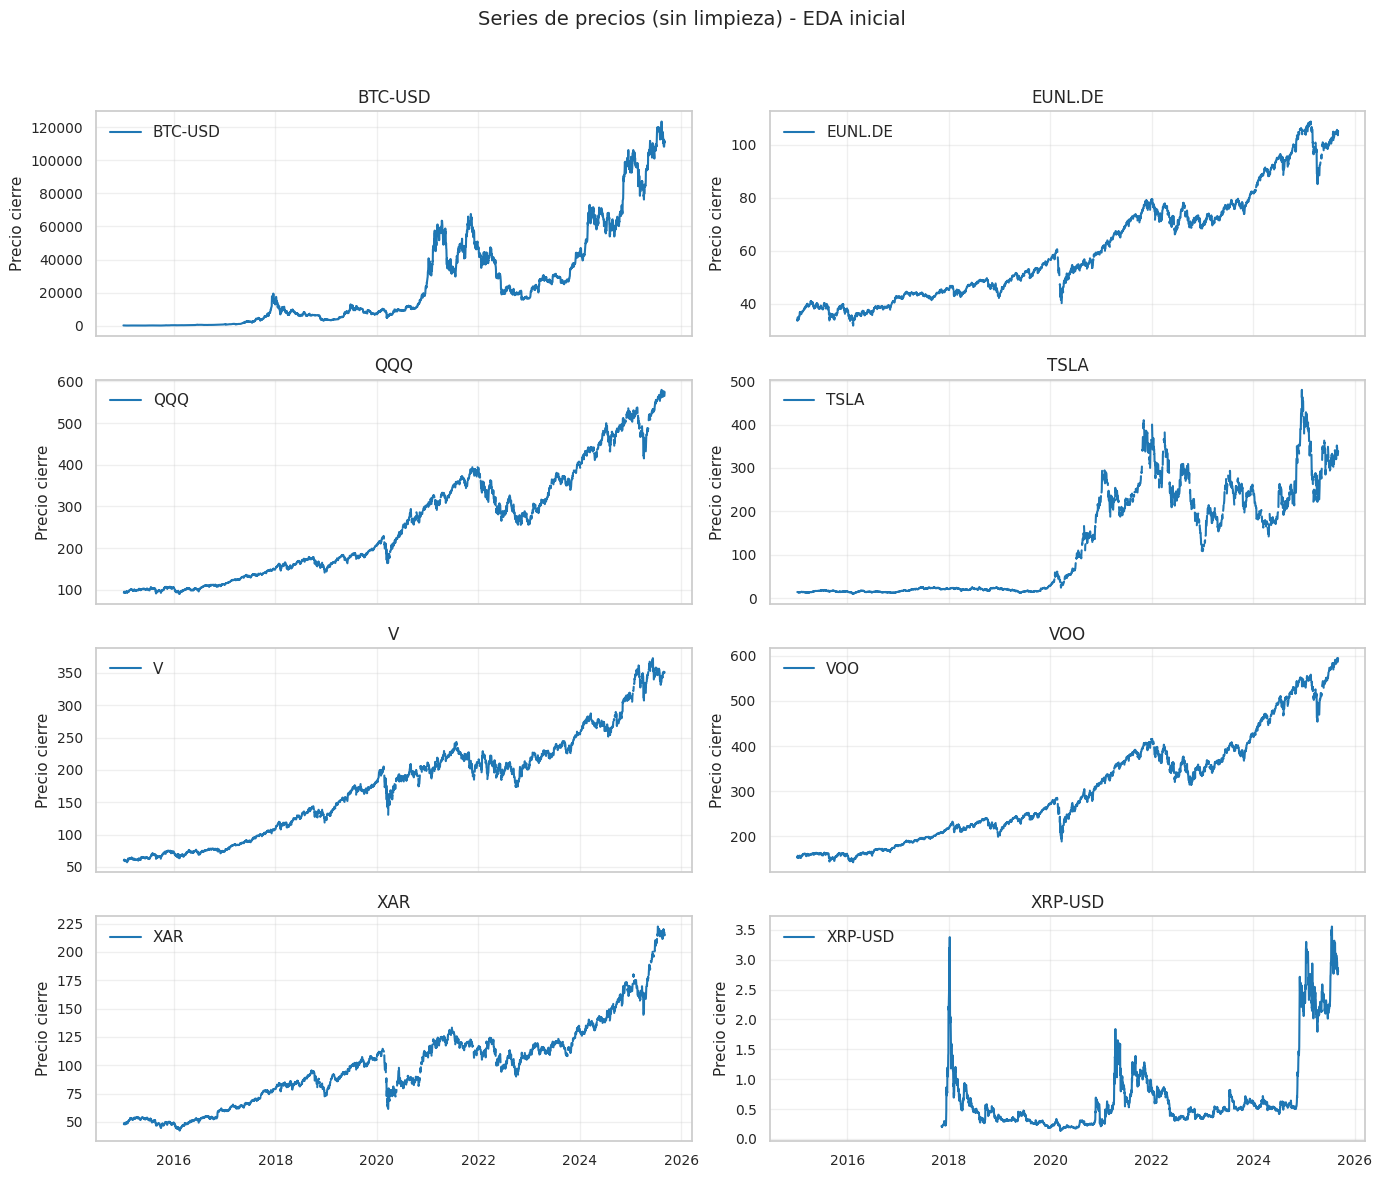

In [8]:
def plot_subplots(df: pd.DataFrame):
    """
    Genera subplots de series de precios (sin limpieza previa) para cada ticker
    contenido en un DataFrame en formato tidy.

    Propósito
    ---------
    - Visualizar de forma rápida la evolución de precios de cierre ajustados
      para todos los tickers disponibles en el dataset.
    - Explorar tendencias, volatilidad y posibles anomalías antes de la fase
      de limpieza y normalización.
    - Ofrecer una visión comparativa mediante subplots ordenados en cuadrícula.

    Parámetros
    ----------
    df : pd.DataFrame
        DataFrame en formato tidy con las columnas mínimas:
        - 'date'   : fecha (datetime.date)
        - 'ticker' : símbolo del activo
        - 'close'  : precio de cierre ajustado

    Notas
    -----
    - El número de filas en la cuadrícula de subplots se calcula dinámicamente
      en función del número total de tickers.
    - Se crean siempre 2 columnas de gráficos para mejor legibilidad.
    - Si el número de tickers es impar, los ejes sobrantes se eliminan.
    - Cada subplot incluye título con el ticker, leyenda y grilla ligera.
    - El gráfico general incluye un título común a todos los subplots.

    Ejemplos
    --------
    >>> plot_subplots(market_df)
    # Devuelve una cuadrícula de gráficos con la serie de precios por ticker.
    """
    tickers = df["ticker"].unique()
    n = len(tickers)

    # Definimos tamaño de figura (filas dinámicas, 2 columnas)
    ncols = 2
    nrows = (n + 1) // ncols
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                             figsize=(14, 3 * nrows), sharex=True)

    # Aplanamos ejes para iterar fácilmente
    axes = axes.flatten()

    # Iteramos sobre cada ticker y generamos la serie
    for i, tk in enumerate(tickers):
        subset = df[df["ticker"] == tk]
        axes[i].plot(subset["date"], subset["close"], label=tk, color="tab:blue")
        axes[i].set_title(f"{tk}", fontsize=12)
        axes[i].set_ylabel("Precio cierre")
        axes[i].grid(True, alpha=0.3)
        axes[i].legend()

    # Quitamos ejes sobrantes si el número de tickers es impar
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Título general y ajuste de espaciado
    plt.suptitle("Series de precios (sin limpieza) - EDA inicial", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

plot_subplots(market_df)


<details open>
<summary><h1 style="display:inline; font-size:36px; color:#d69e2e"> 3. Limpieza y normalización de los datos</h1></summary>

En esta fase transformaremos el dataset crudo descargado en un conjunto **homogéneo y confiable** para análisis y modelado.  
El objetivo es garantizar que todos los activos estén alineados en el mismo calendario y con valores consistentes.

---

## Objetivos de la limpieza

1. **Unificar el punto de inicio**:  
   - Detectar la primera fecha válida de cada ticker.  
   - Escoger la **fecha más reciente** como inicio común (ej.: XRP suele ser la más tardía).  

2. **Normalizar el calendario de negociación**:  
   - Usar un calendario de **días hábiles (lunes–viernes)** como referencia.  
   - Ajustar criptomonedas (que cotizan 24/7) para que tengan `NaN` en fines de semana y festivos.  

3. **Gestionar valores nulos**:  
   - Inyectar `NaN` en criptos en días donde los mercados tradicionales están cerrados.  
   - Eliminar filas donde no existan datos consistentes en ninguno de los activos.  

4. **Obtener un dataset balanceado**:  
   - Todos los activos tendrán la misma cantidad de observaciones.  
   - Series listas para estadísticas comparables, correlaciones y modelos de series de tiempo.  

---

<h2 style="font-size:36px; color:#d69e2e"> Estrategia de normalización</h2>

1. Identificar la **fecha inicial común** usando funciones de detección de primeros valores válidos.  
2. Generar un índice de fechas de negocio (`business days`) desde esa fecha hasta la fecha de corte.  
3. Reindexar cada ticker contra este índice, inyectando `NaN` donde no aplique (ej.: sábados para acciones).  
4. Filtrar/eliminar los días que resulten totalmente vacíos tras la alineación.  

---

<h2 style="font-size:36px; color:#d69e2e"> Consideraciones</h2>

- La normalización implica perder información (ej.: precios de fin de semana en criptos).  
- Esto es necesario para poder comparar activos de naturaleza distinta en un mismo marco temporal.  
- Si el objetivo fuese analizar criptos de forma independiente, se mantendría su serie 24/7.  

---

<h2 style="font-size:36px; color:#d69e2e"> Flujo del proceso</h2>

1. Detectar primeras fechas válidas (`first_valid_date`) de cada ticker.  
2. Calcular fecha de inicio común (`common_start_date`).  
3. Generar índice de negocio (`make_business_index`).  
4. Reindexar y alinear todos los activos.  
5. Eliminar filas con `NaN` generalizados.  
6. Validar el dataset final (cobertura, tamaño, consistencia).  

</details>



In [9]:
def first_valid_dates_by_ticker(df: pd.DataFrame) -> pd.DataFrame:
    """
    Paso 1 - validamoslas fechas de cada ticker

    Objetivo:
    - Encontrar para cada ticker en el DataFrame:
      • Fecha mínima disponible (first_date).
      • Fecha máxima disponible (last_date).
      • Número total de registros (n_total).
      • Número de valores no nulos en 'close' (n_nonnull).
      • Primera fecha válida (no nula) en 'close' (first_valid_date).
      • Proporción de cobertura de datos válidos (coverage_ratio).

    Parámetros:
    ----------
    df : pd.DataFrame
        Dataset en formato tidy con al menos las columnas:
        ['date', 'ticker', 'close'].
        - 'date' puede estar en datetime64 o string; se normaliza a date.
        - 'ticker' identifica el activo.
        - 'close' es el precio de cierre (puede contener NaN).

    Retorna:
    --------
    pd.DataFrame
        Tabla resumen con columnas:
        ['ticker', 'first_valid_date', 'first_date', 'last_date',
         'n_total', 'n_nonnull', 'coverage_ratio']
        donde:
        - ticker: símbolo del activo.
        - first_valid_date: primera fecha con dato válido en 'close'.
        - first_date: fecha mínima en el dataset.
        - last_date: fecha máxima en el dataset.
        - n_total: número total de filas para el ticker.
        - n_nonnull: número de filas con 'close' no nulo.
        - coverage_ratio: n_nonnull / n_total (proporción de cobertura).

    Notas:
    ------
    • Esta función es útil en el pipeline de normalización de series,
      ya que permite identificar el activo con el inicio más reciente.
    • Ese inicio común servirá para alinear todas las series al mismo rango.
    """

    # Normalizamos el tipo de dato de la columna 'date' a objeto date
    tmp = df.copy()
    tmp["date"] = pd.to_datetime(tmp["date"]).dt.date

    # Agrupamos por ticker y calculamos métricas básicas
    g = tmp.sort_values(["ticker", "date"]).groupby("ticker", as_index=False)
    agg = g.agg(
        first_date=("date", "min"),     # fecha mínima en el dataset
        last_date=("date", "max"),      # fecha máxima en el dataset
        n_total=("close", "size"),      # número total de registros
        n_nonnull=("close", lambda s: s.notna().sum())  # registros no nulos
    )

    # Obtenemos la primera fecha con dato no nulo de 'close' por ticker
    first_valid = (
        tmp[tmp["close"].notna()]
        .sort_values(["ticker", "date"])
        .groupby("ticker", as_index=False)
        .agg(first_valid_date=("date", "min"))
    )

    # Unimos ambos resultados
    out = agg.merge(first_valid, on="ticker", how="left")

    # Calculamos proporción de cobertura
    out["coverage_ratio"] = out["n_nonnull"] / out["n_total"]

    return out[[
        "ticker", "first_valid_date", "first_date", "last_date",
        "n_total", "n_nonnull", "coverage_ratio"
    ]]



In [10]:
def common_start_date(df: pd.DataFrame, strict: bool = True) -> Tuple[pd.Timestamp, pd.DataFrame]:
    """
    Paso 2 - Determinamos una fecha de inicio comun entre los diferentes tickers
    cogiendo como fecha de incio común la primera fecha con dato válido en 'close'.

    Objetivo:
    ----------
    - A partir de un DataFrame de series financieras, identificar:
      • La primera fecha con dato válido (no nulo) de cada ticker.
      • La fecha de inicio común más reciente (máximo de esas fechas).
    - Esta fecha común se usará como punto de arranque del dataset
      normalizado para garantizar que todos los tickers tengan datos
      desde ese día en adelante.

    Parámetros:
    -----------
    df : pd.DataFrame
        DataFrame en formato tidy con al menos:
        ['date', 'ticker', 'close'].
        - 'date' puede estar en datetime64 o string.
        - 'ticker' identifica el activo.
        - 'close' es el precio de cierre (puede contener NaN).

    strict : bool, opcional (default=True)
        • True  → si algún ticker no tiene datos no nulos en 'close',
                   lanza un ValueError.
        • False → ignora esos tickers (se eliminan de la tabla).

    Retorna:
    --------
    common_start : datetime.date
        Fecha más reciente entre las primeras fechas válidas de todos los tickers.
        Marca el inicio común para normalizar el dataset.

    table : pd.DataFrame
        Tabla resumen generada por `first_valid_dates_by_ticker(df)`,
        con las columnas:
        ['ticker', 'first_valid_date', 'first_date', 'last_date',
         'n_total', 'n_nonnull', 'coverage_ratio'].

    Excepciones:
    ------------
    ValueError
        Si strict=True y existen tickers sin ningún dato no nulo.

    Notas:
    ------
    • Si un ticker no tiene registros válidos, puede excluirse con strict=False.
    • Este paso es crítico para sincronizar series con distintos inicios,
      como ocurre entre acciones/ETFs y criptomonedas.
    """
    table = first_valid_dates_by_ticker(df)

    # Si un ticker no tiene 'first_valid_date' (todo NaN), manejarlo
    if table["first_valid_date"].isna().any():
        missing = table[table["first_valid_date"].isna()]["ticker"].tolist()
        msg = f"Tickers sin datos no nulos: {missing}"
        if strict:
            raise ValueError(msg)
        # En modo no estricto, los excluimos
        table = table.dropna(subset=["first_valid_date"])

    # Fecha de inicio común (la más tardía entre todos los tickers)
    common_start = pd.to_datetime(table["first_valid_date"]).max().date()
    return common_start, table



In [11]:
def make_business_index(common_start, end_date):
    """
    Paso 3 - Generamos un rango de fechas validas (lunes-viernes)

    Objetivo
    --------
    - Construir un rango de fechas con frecuencia de días hábiles
      (business days) entre una fecha de inicio común y una fecha de corte.
    - Este índice servirá para reindexar todas las series financieras y
      normalizarlas a un mismo calendario de negociación.

    Parámetros
    ----------
    common_start : str o datetime.date
        Fecha de inicio común, normalmente determinada por el ticker con
        el inicio de datos más reciente. Puede ser string en formato
        'YYYY-MM-DD' o un objeto datetime.date.

    end_date : str o datetime.date
        Fecha de corte fija que marca el final del análisis. Puede ser string
        en formato 'YYYY-MM-DD' o un objeto datetime.date.

    Retorna
    -------
    business_index : numpy.ndarray de tipo date
        Lista de fechas (naive, sin zona horaria) correspondientes a todos los
        días hábiles (lunes–viernes) entre common_start y end_date.

    Notas
    -----
    • Usa la frecuencia 'B' de pandas, que excluye fines de semana automáticamente.
    • No excluye feriados específicos de cada mercado; si se desea ese nivel de
      precisión, se debería usar `CustomBusinessDay` con un calendario bursátil.
    • Este paso permite alinear ETFs/acciones (que no cotizan en fines de semana)
      con criptomonedas, generando una base común de fechas hábiles.
    """
    idx = pd.date_range(start=common_start, end=end_date, freq="B")
    return idx.date



In [12]:
def reindex_all_to_business(df: pd.DataFrame, business_index) -> pd.DataFrame:
    """
    Paso 4 - Vamos a reindexar todas las series al calendario hábil
    común (lunes–viernes)

    Objetivo
    --------
    - Alinear todos los tickers a un mismo calendario de días hábiles
    (business days), usando el índice común previamente construido.
    - Mantener el dataset en formato "tidy" y reinyectar los metadatos
    por ticker (asset_class y currency) tras el reindexado.

    Entradas
    --------
    df : pd.DataFrame
        DataFrame en formato tidy con columnas mínimas:
        ['date', 'ticker', 'asset_class', 'close', 'currency'].
        • 'date' puede ser datetime64 o date (se normaliza internamente).
        • 'ticker' identifica el activo.
        • 'close' puede contener NaN (especialmente en fines de semana/feriados).

    business_index : iterable de fechas (p. ej., numpy.ndarray / list[date])
        Índice de fechas hábiles (lunes–viernes) generado por `make_business_index`.
        Este calendario será el que usemos para reindexar todas las series.

    Salida
    ------
    pd.DataFrame
        DataFrame tidy reindexado al calendario común, con columnas:
        ['date', 'ticker', 'asset_class', 'close', 'currency'].
        • Las fechas fuera del calendario se eliminan.
        • Las fechas agregadas por el reindexado quedan con NaN en aquellos
          tickers que no operan en esos días (antes de la limpieza final).

    Detalles de implementación
    --------------------------
    1) Normaliza 'date' a objeto date (naive).
    2) Extrae y conserva metadatos únicos por ticker: asset_class, currency.
    3) Convierte el dataset a formato ancho (pivot: filas=fecha, columnas=ticker).
    4) Reindexa el ancho al business_index (frecuencia hábil).
    5) Vuelve a formato tidy (melt) y ordena por ['ticker', 'date'].
    6) Reinyecta los metadatos por ticker (asset_class, currency).

    Notas
    -----
    • Este paso NO elimina NaN: solo armoniza calendarios. La eliminación de
      días con faltantes se hace en el paso posterior (`drop_days_with_any_nan`).
    • Si se requieren feriados específicos por mercado, el business_index debe
      construirse con un calendario bursátil custom (p. ej., `CustomBusinessDay`).
    • Mantener tidy facilita comparaciones y posteriores operaciones de groupby.

    Ejemplo
    -------
    >>> bidx = make_business_index(common_start, "2025-09-08")
    >>> df_b = reindex_all_to_business(market_df, bidx)
    >>> df_b.head()
    """
    tmp = df.copy()
    tmp["date"] = pd.to_datetime(tmp["date"]).dt.date

    # Pivot a formato ancho
    wide = tmp.pivot(index="date", columns="ticker", values="close")

    # Asegurar que el índice tenga nombre para que reset_index cree 'date'
    wide.index.name = "date"

    # Eliminar días con algún NaN
    wide_clean = wide.dropna()

    # Volver a tidy (manejo robusto del nombre de la columna fecha)
    df_reset = wide_clean.reset_index()
    if "index" in df_reset.columns and "date" not in df_reset.columns:
        df_reset = df_reset.rename(columns={"index": "date"})

    tidy = (
        df_reset
        .melt(id_vars="date", var_name="ticker", value_name="close")
        .sort_values(["ticker", "date"])
        .reset_index(drop=True)
    )

    # Reinyectar metadatos desde el original
    meta = (
        df.dropna(subset=["ticker"])
          .groupby("ticker", as_index=False)
          .agg(asset_class=("asset_class", "first"),
               currency=("currency", "first"))
          .set_index("ticker")
    )
    tidy["asset_class"] = tidy["ticker"].map(meta["asset_class"])
    tidy["currency"]    = tidy["ticker"].map(meta["currency"])

    return tidy[["date", "ticker", "asset_class", "close", "currency"]]

In [13]:
def drop_days_with_any_nan(df: pd.DataFrame) -> pd.DataFrame:
    """
    Paso 5 - Eliminar filas con NaN en cualquier ticker

    Elimina del dataset todos los días en los que algún ticker tenga valores nulos
    en el precio de cierre, devolviendo un DataFrame limpio y balanceado.

    Propósito
    ---------
    - Normalizar la longitud de las series temporales de todos los tickers.
    - Asegurar que cada fila del dataset final represente un día en el cual
      todos los activos tienen precio válido (sin NaN).
    - Preparar un conjunto de datos homogéneo para análisis comparativos
      y modelado de series de tiempo.

    Parámetros
    ----------
    df : pd.DataFrame
        DataFrame en formato tidy con columnas mínimas:
        - 'date'       : fecha de negociación (datetime.date o string ISO)
        - 'ticker'     : símbolo del activo
        - 'asset_class': tipo de activo (ETF, Stock, Crypto, ...)
        - 'close'      : precio de cierre ajustado
        - 'currency'   : moneda principal de cotización

    Retorna
    -------
    pd.DataFrame
        Nuevo DataFrame tidy con:
        - Fechas limitadas únicamente a los días con datos completos.
        - Columnas: ['date', 'ticker', 'asset_class', 'close', 'currency'].
        - Sin valores nulos en 'close'.

    Notas
    -----
    - La función pivota temporalmente los datos a formato ancho
      (tickers en columnas), elimina las filas con cualquier NaN y vuelve a
      deshacer el pivote a formato tidy.
    - Se reinyectan metadatos (`asset_class` y `currency`) desde el dataset
      original para preservar información.
    - Esta limpieza garantiza series perfectamente alineadas entre activos,
      aunque implica pérdida de información (elimina fines de semana de criptos).

    Ejemplos
    --------
    >>> df_clean = drop_days_with_any_nan(market_df)
    >>> df_clean.head()
           date ticker asset_class   close currency
    0  2015-01-02   VOO        ETF  193.98      USD
    1  2015-01-02   QQQ        ETF  102.73      USD
    2  2015-01-02  TSLA      Stock   42.33      USD
    3  2015-01-02     V      Stock   65.50      USD
    4  2015-01-02 BTC-USD    Crypto 315.23      USD
    """
    tmp = df.copy()
    tmp["date"] = pd.to_datetime(tmp["date"]).dt.date

    # Pivotar a formato ancho (tickers en columnas, fechas en índice)
    wide = tmp.pivot(index="date", columns="ticker", values="close")

    # Eliminar días con al menos 1 valor nulo
    wide_clean = wide.dropna()

    # Volver a formato tidy
    tidy = (
        wide_clean.reset_index(names="date")
                  .melt(id_vars="date", var_name="ticker", value_name="close")
                  .sort_values(["ticker", "date"])
                  .reset_index(drop=True)
    )

    # Reinyectar metadatos desde el DataFrame original
    meta = (
        df.dropna(subset=["ticker"])
          .groupby("ticker", as_index=False)
          .agg(asset_class=("asset_class", "first"),
               currency=("currency", "first"))
          .set_index("ticker")
    )
    tidy["asset_class"] = tidy["ticker"].map(meta["asset_class"])
    tidy["currency"] = tidy["ticker"].map(meta["currency"])

    return tidy[["date", "ticker", "asset_class", "close", "currency"]]


In [14]:
def normalize_market_timeseries(
    df: pd.DataFrame,
    end_date,
    strict: bool = True
) -> Tuple[pd.DataFrame, Dict]:
    """
    Paso 6 - Normalizar un dataset de series de tiempo de activos

    Normaliza un dataset de series de tiempo financieras, alineando todos
    los tickers a un calendario común de días hábiles y eliminando fechas
    inconsistentes.

    Propósito
    ---------
    - Construir un dataset homogéneo en el que todos los activos tengan la misma
      longitud temporal y estén alineados día a día.
    - Establecer una fecha de inicio común para todos los tickers, evitando
      sesgos
      por activos con históricos más cortos.
    - Reindexar los datos a un calendario de días hábiles (lunes–viernes).
    - Eliminar días incompletos (con algún valor nulo) para garantizar
      consistencia.

    Parámetros
    ----------
    df : pd.DataFrame
        DataFrame en formato tidy con las columnas mínimas:
        - 'date'       : fecha
        - 'ticker'     : símbolo del activo
        - 'asset_class': tipo de activo (ETF, Stock, Crypto, …)
        - 'close'      : precio de cierre ajustado
        - 'currency'   : moneda de cotización
    end_date : str | datetime.date | datetime.datetime
        Fecha de corte (último día a considerar en el calendario común).
        Ej.: '2025-09-05'.
    strict : bool, opcional (default=True)
        - True  → si un ticker no tiene datos válidos, lanza un error.
        - False → excluye los tickers sin datos válidos.

    Retorna
    -------
    Tuple[pd.DataFrame, dict]
        - df_clean : DataFrame tidy normalizado, con todos los tickers alineados
          al mismo calendario y sin días con NaN.
        - meta : diccionario con información de auditoría:
            * 'common_start'    : fecha inicial común detectada.
            * 'end_date'        : fecha de corte usada.
            * 'first_valid_table': tabla con primeras fechas válidas por ticker.
            * 'coverage_table'   : tabla comparativa
              (filas antes y después de limpiar).

    Notas
    -----
    - Este proceso elimina fines de semana y festivos de criptomonedas,
      para alinear con el calendario de acciones/ETFs (lunes–viernes).
    - La proporción de datos retenidos por ticker se guarda en `coverage_table`,
      lo que permite evaluar la pérdida de información.
    - Si se requiere trabajar con criptos 24/7, este método puede no ser adecuado.

    Ejemplos
    --------
    >>> df_norm, meta = normalize_market_timeseries(market_df, "2025-09-05")
    >>> df_norm.head()
           date   ticker asset_class   close currency
    0  2015-01-02     VOO         ETF  193.98      USD
    1  2015-01-02     QQQ         ETF  102.73      USD
    2  2015-01-02  TSLA      Stock   42.33      USD
    3  2015-01-02     V      Stock   65.50      USD
    4  2015-01-02 BTC-USD    Crypto 315.23      USD

    >>> meta["coverage_table"]
      ticker  n_rows_before  n_rows_after  retained_ratio
    0   BTC-USD          3921          2710           0.69
    1     QQQ           2710          2710           1.00
    2    TSLA           2710          2710           1.00
    """
    # 1) Calcular fecha de inicio común en base a los datos válidos
    common_start, table = common_start_date(df, strict=strict)

    # 2) Generar calendario de días hábiles desde common_start hasta end_date
    bindex = make_business_index(common_start, end_date)

    # 3) Reindexar todas las series al calendario común
    df_b = reindex_all_to_business(df, bindex)

    # 4) Eliminar días con NaN en cualquier ticker
    df_clean = drop_days_with_any_nan(df_b)

    # --- Métricas de auditoría ---
    # Conteos antes de la limpieza
    before_counts = (
        df.groupby("ticker")["date"].count().reset_index(name="n_rows_before")
    )
    # Conteos después de la limpieza
    after_counts = (
        df_clean.groupby("ticker")["date"].count().reset_index(name="n_rows_after")
    )
    # Tabla comparativa
    coverage_tbl = before_counts.merge(after_counts, on="ticker", how="left")
    coverage_tbl["retained_ratio"] = (
        coverage_tbl["n_rows_after"] / coverage_tbl["n_rows_before"]
    )

    meta = {
        "common_start": common_start,
        "end_date": pd.to_datetime(end_date).date(),
        "first_valid_table": table.sort_values("first_valid_date"),
        "coverage_table": coverage_tbl.sort_values("ticker")
    }
    return df_clean, meta


<!-- Comparación antes vs. después -->
<details open>
<summary><h1 style="display:inline; font-size:36px; color:#805ad5"> 4. Comparación antes vs. después de la limpieza</h1></summary>

En esta fase evaluamos el **impacto de la limpieza y normalización** sobre los datos financieros.  
Nuestro objetivo es entender **qué tanto cambió el dataset** en términos de cobertura temporal, calidad y estadísticas descriptivas.

---

## Objetivos de la comparación

1. Verificar los rangos temporales (primera y última fecha por ticker) antes y después.  
2. Evaluar la cantidad de registros conservados (`n_rows_before` vs. `n_rows_after`) y el **ratio retenido**.  
3. Contabilizar valores nulos (`n_missing`) y confirmar su eliminación tras la normalización.  
4. Comparar estadísticas descriptivas clave:
   - Media del precio de cierre  
   - Desviación estándar  
   - Varianza  
5. Comparar las graficas arrojadas
6. Comparar como cambian las correlaciones

---

<h2 style="font-size:28px; color:#805ad5"> Estrategia de visualización</h2>

Para lograr esta comparación implementamos distintas herramientas:

- **Tablas comparativas**:  
  Resúmenes estadísticos de cada ticker (antes y después) mostrados en paralelo.

- **Series temporales lado a lado (`plot_before_after_timeseries`)**:  
  Cada ticker se grafica en dos columnas:  
  - Izquierda → serie cruda (antes de limpiar).  
  - Derecha   → serie normalizada (después de limpiar).  
  Esto mantiene el mismo eje Y para asegurar comparaciones justas.

- **Correlaciones lado a lado (`plot_before_after_corr`)**:  
  Heatmaps de correlación de precios antes y después, para observar cómo la limpieza afecta la estructura de dependencias entre activos.

---

<h2 style="font-size:28px; color:#805ad5"> Consideraciones</h2>

- Las criptomonedas operan 24/7, por lo que inicialmente poseen más registros que acciones y ETFs; la limpieza las recorta al calendario hábil.  
- Este proceso puede implicar pérdida de datos, pero se gana **consistencia y comparabilidad**.  
- El ratio retenido (`retained_ratio`) es un indicador clave del impacto de la limpieza.  

</details>




In [15]:
def compare_summaries(df_raw: pd.DataFrame, df_clean: pd.DataFrame) -> dict:
    """
    Construye tablas comparativas entre dataset crudo (antes) y normalizado (después).

    Propósito
    ---------
    - Ver rápidamente cuánto se pierde/retiene por ticker.
    - Ver rangos temporales antes y después.
    - Ver las medias, desviaciones estándar y varianzas de los precios.
    - Ver los valores nulos (NaN) por ticker.
    - Dejar todo en una estructura dict para mostrar por partes.

    Retorna
    -------
    dict con:
      - range_raw      : rango (first/last) y n_rows del crudo
      - range_clean    : rango (first/last) y n_rows del limpio
    """
    range_raw = (
        df_raw.groupby("ticker")
        .agg(first_date=("date", "min"),
             last_date=("date", "max"),
             n_rows=("date", "size"),
             n_missing=("close", lambda x: x.isna().sum()),
             mean = ("close", "mean"),
             var =  ("close", "var"),
             std  = ("close", "std"),
            asset_class = ("asset_class", "first"),
            currency = ("currency", "first"))
        .reset_index()
        .sort_values("ticker")
    )

    range_clean = (
        df_clean.groupby("ticker")
        .agg(first_date=("date", "min"),
             last_date=("date", "max"),
             n_rows=("date", "size"),
             n_missing=("close", lambda x: x.isna().sum()),
             mean = ("close", "mean"),
             var =  ("close", "var"),
             std  = ("close", "std"),
             asset_class = ("asset_class", "first"),
            currency = ("currency", "first"))
        .reset_index()
        .sort_values("ticker")
    )

    return {
        "range_raw": range_raw,
        "range_clean": range_clean
    }


In [16]:
def plot_before_after_timeseries(df_raw: pd.DataFrame, df_clean: pd.DataFrame):
    """
    Dibuja una grilla con 2 columnas por cada ticker:
      - Columna izquierda: serie cruda (antes de limpiar)
      - Columna derecha : serie normalizada (después de limpiar)

    Notas
    -----
    - Mantiene el mismo límite de Y por ticker (min/max de ambas series)
      para una comparación justa.
    - Comparte eje X por fila (cada ticker).
    """
    tickers = sorted(df_raw["ticker"].unique())
    n = len(tickers)
    ncols = 2
    nrows = n

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                             figsize=(16, 2.8 * nrows),
                             sharex=False, sharey=False)

    if nrows == 1:
        axes = np.array([axes])  # homogeneizar forma cuando hay un solo ticker

    for r, tk in enumerate(tickers):
        a_raw = axes[r, 0]
        a_cln = axes[r, 1]

        s_raw = df_raw[df_raw["ticker"] == tk][["date", "close"]].sort_values("date")
        s_cln = df_clean[df_clean["ticker"] == tk][["date", "close"]].sort_values("date")

        # Límites comunes por ticker
        ymin = min(s_raw["close"].min(), s_cln["close"].min())
        ymax = max(s_raw["close"].max(), s_cln["close"].max())

        # Izquierda: antes
        a_raw.plot(s_raw["date"], s_raw["close"], lw=1.3)
        a_raw.set_title(f"{tk} — Antes", fontsize=11)
        a_raw.set_ylim(ymin, ymax)
        a_raw.grid(True, alpha=0.3)

        # Derecha: después
        a_cln.plot(s_cln["date"], s_cln["close"], lw=1.3)
        a_cln.set_title(f"{tk} — Después", fontsize=11)
        a_cln.set_ylim(ymin, ymax)
        a_cln.grid(True, alpha=0.3)

        # Etiqueta Y solo en la izquierda
        a_raw.set_ylabel("Precio cierre")

    # Títulos de columnas
    axes[0, 0].set_xlabel("")
    axes[0, 1].set_xlabel("")
    plt.suptitle("Comparativa antes vs. después de la limpieza por ticker", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()


In [17]:
def plot_before_after_corr(df_raw: pd.DataFrame, df_clean: pd.DataFrame):
    """
    Muestra dos heatmaps lado a lado:
      - Izquierda: correlación de precios (crudo)
      - Derecha  : correlación de precios (normalizado)
    """
    def to_wide(df):
        tmp = df.copy()
        tmp["date"] = pd.to_datetime(tmp["date"]).dt.date
        wide = tmp.pivot(index="date", columns="ticker", values="close")
        return wide

    wide_raw = to_wide(df_raw)
    wide_cln = to_wide(df_clean)

    corr_raw = wide_raw.corr(min_periods=1)
    corr_cln = wide_cln.corr(min_periods=1)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    sns.heatmap(corr_raw, ax=axes[0], annot=True, fmt=".2f",
                cmap="coolwarm", center=0, cbar_kws={"shrink": .8})
    axes[0].set_title("Correlación — Antes (crudo)", fontsize=12)

    sns.heatmap(corr_cln, ax=axes[1], annot=True, fmt=".2f",
                cmap="coolwarm", center=0, cbar_kws={"shrink": .8})
    axes[1].set_title("Correlación — Después (normalizado)", fontsize=12)

    plt.suptitle("Heatmaps de correlación — antes vs. después", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


In [18]:
def show_side_by_side(df_before: pd.DataFrame, df_after: pd.DataFrame,
                      title_before="Antes de limpieza", title_after="Después de limpieza"):
    """
    Muestra dos DataFrames en paralelo (lado a lado) con títulos personalizados.
    Útil para comparar rangos, coberturas o métricas antes y después del procesamiento.
    """
    html_before = f"<h3 style='text-align:center'>{title_before}</h3>" + df_before.to_html(index=False)
    html_after  = f"<h3 style='text-align:center'>{title_after}</h3>" + df_after.to_html(index=False)

    display_html(
        f"<div style='display:flex; justify-content:space-around; gap:40px;'>"
        f"<div>{html_before}</div>"
        f"<div>{html_after}</div>"
        f"</div>", raw=True
    )

In [19]:
def show_heads_by_ticker(df_before, df_after, n=5, tickers=None):
    """
    Usa la función show_side_by_side para mostrar comparaciones por ticker.

    Parámetros
    ----------
    df_before, df_after : DataFrames tidy con columnas ['date','ticker','close',...]
    n : int
        Número de filas a mostrar (head).
    tickers : list | None
        Lista de tickers a mostrar. Si es None, usa los comunes en ambos datasets.
    """
    # Detectamos tickers comunes
    common = sorted(set(df_before["ticker"]) & set(df_after["ticker"]))
    if tickers:
        common = [t for t in tickers if t in common]

    for tk in common:
        before_tk = (df_before[df_before["ticker"] == tk]
                     .sort_values("date")
                     .head(n)
                     .reset_index(drop=True))
        after_tk = (df_after[df_after["ticker"] == tk]
                    .sort_values("date")
                    .head(n)
                    .reset_index(drop=True))

        # Reusamos tu función existente para mostrar lado a lado
        show_side_by_side(before_tk, after_tk,
                          title_before=f"{tk} — Antes",
                          title_after=f"{tk} — Después")


In [20]:
"""
Ejecutamos el pipeline completo y comparamos los resultados obtenidos
antes y despues de la limpieza.
"""

market_df_clean, meta = normalize_market_timeseries(market_df, END_DATE, strict=True)

#Creamos los reportes antes vs despues de la limpieza
sumary = compare_summaries(market_df, market_df_clean)

#reporte antes de la limpieza
sumary_raw = sumary["range_raw"]

#Reporte despues de la limpieza
sumary_clean = sumary["range_clean"]

show_side_by_side(sumary_raw, sumary_clean,
                  title_before="📊 Stats por ticker (ANTES)",
                  title_after="📊 Stats por ticker (DESPUÉS)")

📊 Stats por ticker (ANTES) 
 
 
 ticker 
 first_date 
 last_date 
 n_rows 
 n_missing 
 mean 
 var 
 std 
 asset_class 
 currency 
 
 
 
 
 BTC-USD 
 2015-01-02 
 2025-09-04 
 3899 
 0 
 25275.675567 
 8.586713e+08 
 29303.094403 
 Crypto 
 USD 
 
 
 EUNL.DE 
 2015-01-02 
 2025-09-04 
 3899 
 1184 
 60.981730 
 4.181165e+02 
 20.447897 
 ETF 
 EUR 
 
 
 QQQ 
 2015-01-02 
 2025-09-04 
 3899 
 1215 
 254.726723 
 1.780463e+04 
 133.433991 
 ETF 
 USD 
 
 
 TSLA 
 2015-01-02 
 2025-09-04 
 3899 
 1215 
 128.394225 
 1.480080e+04 
 121.658539 
 Stock 
 USD 
 
 
 V 
 2015-01-02 
 2025-09-04 
 3899 
 1215 
 174.317495 
 6.421965e+03 
 80.137165 
 Stock 
 USD 
 
 
 VOO 
 2015-01-02 
 2025-09-04 
 3899 
 1215 
 301.352444 
 1.444831e+04 
 120.201132 
 ETF 
 USD 
 
 
 XAR 
 2015-01-02 
 2025-09-04 
 3899 
 1215 
 99.010665 
 1.379816e+03 
 37.145879 
 ETF 
 USD 
 
 
 XRP-USD 
 2015-01-02 
 2025-09-04 
 3899 
 1042 
 0.723592 
 4.510305e-01 
 0.671588 
 Crypto 
 USD 
 
 
 📊 Stats por ticker (DESPUÉS) 
 
 
 ticker 
 first_date 
 last_date 
 n_rows 
 n_missing 
 mean 
 var 
 std 
 asset_class 
 currency 
 
 
 
 
 BTC-USD 
 2017-11-09 
 2025-09-04 
 1931 
 0 
 34100.146852 
 8.748030e+08 
 29577.069272 
 Crypto 
 USD 
 
 
 EUNL.DE 
 2017-11-09 
 2025-09-04 
 1931 
 0 
 68.826128 
 3.340429e+02 
 18.276842 
 ETF 
 EUR 
 
 
 QQQ 
 2017-11-09 
 2025-09-04 
 1931 
 0 
 307.956963 
 1.381476e+04 
 117.536217 
 ETF 
 USD 
 
 
 TSLA 
 2017-11-09 
 2025-09-04 
 1931 
 0 
 169.809921 
 1.384387e+04 
 117.659960 
 Stock 
 USD 
 
 
 V 
 2017-11-09 
 2025-09-04 
 1931 
 0 
 210.625625 
 3.840872e+03 
 61.974767 
 Stock 
 USD 
 
 
 VOO 
 2017-11-09 
 2025-09-04 
 1931 
 0 
 349.620733 
 1.105707e+04 
 105.152619 
 ETF 
 USD 
 
 
 XAR 
 2017-11-09 
 2025-09-04 
 1931 
 0 
 114.833072 
 9.342423e+02 
 30.565378 
 ETF 
 USD 
 
 
 XRP-USD 
 2017-11-09 
 2025-09-04 
 1931 
 0 
 0.720082 
 4.460942e-01 
 0.667903 
 Crypto 
 USD

In [21]:
"""
Calcula el ratio retenido de filas por ticker tras la limpieza.
"""
n_before = sumary_raw["n_rows"].sum()
n_after  = sumary_clean['n_rows'].sum()

ratio = n_after / n_before
print(f"Ratio de filas retenidas por ticker: {ratio:.2%}")

Ratio de filas retenidas por ticker: 49.53%


In [22]:
"""Compartiva de tickers antes y despues de la limpieza"""
show_heads_by_ticker(market_df, market_df_clean, n=10)

BTC-USD — Antes 
 
 
 Price 
 date 
 ticker 
 asset_class 
 close 
 currency 
 
 
 
 
 
 2015-01-02 
 BTC-USD 
 Crypto 
 315.032013 
 USD 
 
 
 
 2015-01-03 
 BTC-USD 
 Crypto 
 281.082001 
 USD 
 
 
 
 2015-01-04 
 BTC-USD 
 Crypto 
 264.195007 
 USD 
 
 
 
 2015-01-05 
 BTC-USD 
 Crypto 
 274.473999 
 USD 
 
 
 
 2015-01-06 
 BTC-USD 
 Crypto 
 286.188995 
 USD 
 
 
 
 2015-01-07 
 BTC-USD 
 Crypto 
 294.337006 
 USD 
 
 
 
 2015-01-08 
 BTC-USD 
 Crypto 
 283.348999 
 USD 
 
 
 
 2015-01-09 
 BTC-USD 
 Crypto 
 290.407990 
 USD 
 
 
 
 2015-01-10 
 BTC-USD 
 Crypto 
 274.795990 
 USD 
 
 
 
 2015-01-11 
 BTC-USD 
 Crypto 
 265.660004 
 USD 
 
 
 BTC-USD — Después 
 
 
 date 
 ticker 
 asset_class 
 close 
 currency 
 
 
 
 
 2017-11-09 
 BTC-USD 
 Crypto 
 7143.580078 
 USD 
 
 
 2017-11-10 
 BTC-USD 
 Crypto 
 6618.140137 
 USD 
 
 
 2017-11-13 
 BTC-USD 
 Crypto 
 6559.490234 
 USD 
 
 
 2017-11-14 
 BTC-USD 
 Crypto 
 6635.750000 
 USD 
 
 
 2017-11-15 
 BTC-USD 
 Crypto 
 7315.540039 
 USD 
 
 
 2017-11-16 
 BTC-USD 
 Crypto 
 7871.689941 
 USD 
 
 
 2017-11-17 
 BTC-USD 
 Crypto 
 7708.990234 
 USD 
 
 
 2017-11-20 
 BTC-USD 
 Crypto 
 8200.639648 
 USD 
 
 
 2017-11-21 
 BTC-USD 
 Crypto 
 8071.259766 
 USD 
 
 
 2017-11-22 
 BTC-USD 
 Crypto 
 8253.549805 
 USD

EUNL.DE — Antes 
 
 
 Price 
 date 
 ticker 
 asset_class 
 close 
 currency 
 
 
 
 
 
 2015-01-02 
 EUNL.DE 
 ETF 
 34.259998 
 EUR 
 
 
 
 2015-01-03 
 EUNL.DE 
 ETF 
 NaN 
 EUR 
 
 
 
 2015-01-04 
 EUNL.DE 
 ETF 
 NaN 
 EUR 
 
 
 
 2015-01-05 
 EUNL.DE 
 ETF 
 33.939999 
 EUR 
 
 
 
 2015-01-06 
 EUNL.DE 
 ETF 
 33.529999 
 EUR 
 
 
 
 2015-01-07 
 EUNL.DE 
 ETF 
 34.060001 
 EUR 
 
 
 
 2015-01-08 
 EUNL.DE 
 ETF 
 34.770000 
 EUR 
 
 
 
 2015-01-09 
 EUNL.DE 
 ETF 
 34.410000 
 EUR 
 
 
 
 2015-01-10 
 EUNL.DE 
 ETF 
 NaN 
 EUR 
 
 
 
 2015-01-11 
 EUNL.DE 
 ETF 
 NaN 
 EUR 
 
 
 EUNL.DE — Después 
 
 
 date 
 ticker 
 asset_class 
 close 
 currency 
 
 
 
 
 2017-11-09 
 EUNL.DE 
 ETF 
 44.970001 
 EUR 
 
 
 2017-11-10 
 EUNL.DE 
 ETF 
 44.880001 
 EUR 
 
 
 2017-11-13 
 EUNL.DE 
 ETF 
 44.820000 
 EUR 
 
 
 2017-11-14 
 EUNL.DE 
 ETF 
 44.310001 
 EUR 
 
 
 2017-11-15 
 EUNL.DE 
 ETF 
 44.080002 
 EUR 
 
 
 2017-11-16 
 EUNL.DE 
 ETF 
 44.470001 
 EUR 
 
 
 2017-11-17 
 EUNL.DE 
 ETF 
 44.330002 
 EUR 
 
 
 2017-11-20 
 EUNL.DE 
 ETF 
 44.570000 
 EUR 
 
 
 2017-11-21 
 EUNL.DE 
 ETF 
 44.880001 
 EUR 
 
 
 2017-11-22 
 EUNL.DE 
 ETF 
 44.680000 
 EUR

QQQ — Antes 
 
 
 Price 
 date 
 ticker 
 asset_class 
 close 
 currency 
 
 
 
 
 
 2015-01-02 
 QQQ 
 ETF 
 94.906548 
 USD 
 
 
 
 2015-01-03 
 QQQ 
 ETF 
 NaN 
 USD 
 
 
 
 2015-01-04 
 QQQ 
 ETF 
 NaN 
 USD 
 
 
 
 2015-01-05 
 QQQ 
 ETF 
 93.514404 
 USD 
 
 
 
 2015-01-06 
 QQQ 
 ETF 
 92.260521 
 USD 
 
 
 
 2015-01-07 
 QQQ 
 ETF 
 93.449852 
 USD 
 
 
 
 2015-01-08 
 QQQ 
 ETF 
 95.238457 
 USD 
 
 
 
 2015-01-09 
 QQQ 
 ETF 
 94.611519 
 USD 
 
 
 
 2015-01-10 
 QQQ 
 ETF 
 NaN 
 USD 
 
 
 
 2015-01-11 
 QQQ 
 ETF 
 NaN 
 USD 
 
 
 QQQ — Después 
 
 
 date 
 ticker 
 asset_class 
 close 
 currency 
 
 
 
 
 2017-11-09 
 QQQ 
 ETF 
 145.739365 
 USD 
 
 
 2017-11-10 
 QQQ 
 ETF 
 145.729889 
 USD 
 
 
 2017-11-13 
 QQQ 
 ETF 
 145.910019 
 USD 
 
 
 2017-11-14 
 QQQ 
 ETF 
 145.378967 
 USD 
 
 
 2017-11-15 
 QQQ 
 ETF 
 144.696274 
 USD 
 
 
 2017-11-16 
 QQQ 
 ETF 
 146.545425 
 USD 
 
 
 2017-11-17 
 QQQ 
 ETF 
 145.985916 
 USD 
 
 
 2017-11-20 
 QQQ 
 ETF 
 145.872162 
 USD 
 
 
 2017-11-21 
 QQQ 
 ETF 
 147.455780 
 USD 
 
 
 2017-11-22 
 QQQ 
 ETF 
 147.635910 
 USD

TSLA — Antes 
 
 
 Price 
 date 
 ticker 
 asset_class 
 close 
 currency 
 
 
 
 
 
 2015-01-02 
 TSLA 
 Stock 
 14.620667 
 USD 
 
 
 
 2015-01-03 
 TSLA 
 Stock 
 NaN 
 USD 
 
 
 
 2015-01-04 
 TSLA 
 Stock 
 NaN 
 USD 
 
 
 
 2015-01-05 
 TSLA 
 Stock 
 14.006000 
 USD 
 
 
 
 2015-01-06 
 TSLA 
 Stock 
 14.085333 
 USD 
 
 
 
 2015-01-07 
 TSLA 
 Stock 
 14.063333 
 USD 
 
 
 
 2015-01-08 
 TSLA 
 Stock 
 14.041333 
 USD 
 
 
 
 2015-01-09 
 TSLA 
 Stock 
 13.777333 
 USD 
 
 
 
 2015-01-10 
 TSLA 
 Stock 
 NaN 
 USD 
 
 
 
 2015-01-11 
 TSLA 
 Stock 
 NaN 
 USD 
 
 
 TSLA — Después 
 
 
 date 
 ticker 
 asset_class 
 close 
 currency 
 
 
 
 
 2017-11-09 
 TSLA 
 Stock 
 20.199333 
 USD 
 
 
 2017-11-10 
 TSLA 
 Stock 
 20.199333 
 USD 
 
 
 2017-11-13 
 TSLA 
 Stock 
 21.026667 
 USD 
 
 
 2017-11-14 
 TSLA 
 Stock 
 20.580000 
 USD 
 
 
 2017-11-15 
 TSLA 
 Stock 
 20.753332 
 USD 
 
 
 2017-11-16 
 TSLA 
 Stock 
 20.833332 
 USD 
 
 
 2017-11-17 
 TSLA 
 Stock 
 21.003332 
 USD 
 
 
 2017-11-20 
 TSLA 
 Stock 
 20.582666 
 USD 
 
 
 2017-11-21 
 TSLA 
 Stock 
 21.187332 
 USD 
 
 
 2017-11-22 
 TSLA 
 Stock 
 20.840000 
 USD

V — Antes 
 
 
 Price 
 date 
 ticker 
 asset_class 
 close 
 currency 
 
 
 
 
 
 2015-01-02 
 V 
 Stock 
 61.462460 
 USD 
 
 
 
 2015-01-03 
 V 
 Stock 
 NaN 
 USD 
 
 
 
 2015-01-04 
 V 
 Stock 
 NaN 
 USD 
 
 
 
 2015-01-05 
 V 
 Stock 
 60.105782 
 USD 
 
 
 
 2015-01-06 
 V 
 Stock 
 59.718468 
 USD 
 
 
 
 2015-01-07 
 V 
 Stock 
 60.518574 
 USD 
 
 
 
 2015-01-08 
 V 
 Stock 
 61.330288 
 USD 
 
 
 
 2015-01-09 
 V 
 Stock 
 60.421177 
 USD 
 
 
 
 2015-01-10 
 V 
 Stock 
 NaN 
 USD 
 
 
 
 2015-01-11 
 V 
 Stock 
 NaN 
 USD 
 
 
 V — Después 
 
 
 date 
 ticker 
 asset_class 
 close 
 currency 
 
 
 
 
 2017-11-09 
 V 
 Stock 
 106.114769 
 USD 
 
 
 2017-11-10 
 V 
 Stock 
 105.868759 
 USD 
 
 
 2017-11-13 
 V 
 Stock 
 105.414551 
 USD 
 
 
 2017-11-14 
 V 
 Stock 
 105.963387 
 USD 
 
 
 2017-11-15 
 V 
 Stock 
 104.326332 
 USD 
 
 
 2017-11-16 
 V 
 Stock 
 105.241096 
 USD 
 
 
 2017-11-17 
 V 
 Stock 
 104.103561 
 USD 
 
 
 2017-11-20 
 V 
 Stock 
 104.226791 
 USD 
 
 
 2017-11-21 
 V 
 Stock 
 105.648720 
 USD 
 
 
 2017-11-22 
 V 
 Stock 
 105.051506 
 USD

VOO — Antes 
 
 
 Price 
 date 
 ticker 
 asset_class 
 close 
 currency 
 
 
 
 
 
 2015-01-02 
 VOO 
 ETF 
 156.158051 
 USD 
 
 
 
 2015-01-03 
 VOO 
 ETF 
 NaN 
 USD 
 
 
 
 2015-01-04 
 VOO 
 ETF 
 NaN 
 USD 
 
 
 
 2015-01-05 
 VOO 
 ETF 
 153.414581 
 USD 
 
 
 
 2015-01-06 
 VOO 
 ETF 
 151.906036 
 USD 
 
 
 
 2015-01-07 
 VOO 
 ETF 
 153.804123 
 USD 
 
 
 
 2015-01-08 
 VOO 
 ETF 
 156.506241 
 USD 
 
 
 
 2015-01-09 
 VOO 
 ETF 
 155.188354 
 USD 
 
 
 
 2015-01-10 
 VOO 
 ETF 
 NaN 
 USD 
 
 
 
 2015-01-11 
 VOO 
 ETF 
 NaN 
 USD 
 
 
 VOO — Después 
 
 
 date 
 ticker 
 asset_class 
 close 
 currency 
 
 
 
 
 2017-11-09 
 VOO 
 ETF 
 207.974655 
 USD 
 
 
 2017-11-10 
 VOO 
 ETF 
 207.851822 
 USD 
 
 
 2017-11-13 
 VOO 
 ETF 
 208.097366 
 USD 
 
 
 2017-11-14 
 VOO 
 ETF 
 207.588760 
 USD 
 
 
 2017-11-15 
 VOO 
 ETF 
 206.527756 
 USD 
 
 
 2017-11-16 
 VOO 
 ETF 
 208.290268 
 USD 
 
 
 2017-11-17 
 VOO 
 ETF 
 207.729080 
 USD 
 
 
 2017-11-20 
 VOO 
 ETF 
 208.000916 
 USD 
 
 
 2017-11-21 
 VOO 
 ETF 
 209.386307 
 USD 
 
 
 2017-11-22 
 VOO 
 ETF 
 209.237244 
 USD

XAR — Antes 
 
 
 Price 
 date 
 ticker 
 asset_class 
 close 
 currency 
 
 
 
 
 
 2015-01-02 
 XAR 
 ETF 
 48.900848 
 USD 
 
 
 
 2015-01-03 
 XAR 
 ETF 
 NaN 
 USD 
 
 
 
 2015-01-04 
 XAR 
 ETF 
 NaN 
 USD 
 
 
 
 2015-01-05 
 XAR 
 ETF 
 48.114246 
 USD 
 
 
 
 2015-01-06 
 XAR 
 ETF 
 47.897251 
 USD 
 
 
 
 2015-01-07 
 XAR 
 ETF 
 48.064514 
 USD 
 
 
 
 2015-01-08 
 XAR 
 ETF 
 49.135948 
 USD 
 
 
 
 2015-01-09 
 XAR 
 ETF 
 48.824017 
 USD 
 
 
 
 2015-01-10 
 XAR 
 ETF 
 NaN 
 USD 
 
 
 
 2015-01-11 
 XAR 
 ETF 
 NaN 
 USD 
 
 
 XAR — Después 
 
 
 date 
 ticker 
 asset_class 
 close 
 currency 
 
 
 
 
 2017-11-09 
 XAR 
 ETF 
 76.190735 
 USD 
 
 
 2017-11-10 
 XAR 
 ETF 
 75.530838 
 USD 
 
 
 2017-11-13 
 XAR 
 ETF 
 74.880341 
 USD 
 
 
 2017-11-14 
 XAR 
 ETF 
 75.002914 
 USD 
 
 
 2017-11-15 
 XAR 
 ETF 
 74.474976 
 USD 
 
 
 2017-11-16 
 XAR 
 ETF 
 75.323448 
 USD 
 
 
 2017-11-17 
 XAR 
 ETF 
 74.936890 
 USD 
 
 
 2017-11-20 
 XAR 
 ETF 
 75.587387 
 USD 
 
 
 2017-11-21 
 XAR 
 ETF 
 76.464111 
 USD 
 
 
 2017-11-22 
 XAR 
 ETF 
 76.153023 
 USD

XRP-USD — Antes 
 
 
 Price 
 date 
 ticker 
 asset_class 
 close 
 currency 
 
 
 
 
 
 2015-01-02 
 XRP-USD 
 Crypto 
 NaN 
 USD 
 
 
 
 2015-01-03 
 XRP-USD 
 Crypto 
 NaN 
 USD 
 
 
 
 2015-01-04 
 XRP-USD 
 Crypto 
 NaN 
 USD 
 
 
 
 2015-01-05 
 XRP-USD 
 Crypto 
 NaN 
 USD 
 
 
 
 2015-01-06 
 XRP-USD 
 Crypto 
 NaN 
 USD 
 
 
 
 2015-01-07 
 XRP-USD 
 Crypto 
 NaN 
 USD 
 
 
 
 2015-01-08 
 XRP-USD 
 Crypto 
 NaN 
 USD 
 
 
 
 2015-01-09 
 XRP-USD 
 Crypto 
 NaN 
 USD 
 
 
 
 2015-01-10 
 XRP-USD 
 Crypto 
 NaN 
 USD 
 
 
 
 2015-01-11 
 XRP-USD 
 Crypto 
 NaN 
 USD 
 
 
 XRP-USD — Después 
 
 
 date 
 ticker 
 asset_class 
 close 
 currency 
 
 
 
 
 2017-11-09 
 XRP-USD 
 Crypto 
 0.217488 
 USD 
 
 
 2017-11-10 
 XRP-USD 
 Crypto 
 0.206483 
 USD 
 
 
 2017-11-13 
 XRP-USD 
 Crypto 
 0.203442 
 USD 
 
 
 2017-11-14 
 XRP-USD 
 Crypto 
 0.209825 
 USD 
 
 
 2017-11-15 
 XRP-USD 
 Crypto 
 0.212956 
 USD 
 
 
 2017-11-16 
 XRP-USD 
 Crypto 
 0.227107 
 USD 
 
 
 2017-11-17 
 XRP-USD 
 Crypto 
 0.226581 
 USD 
 
 
 2017-11-20 
 XRP-USD 
 Crypto 
 0.238759 
 USD 
 
 
 2017-11-21 
 XRP-USD 
 Crypto 
 0.233271 
 USD 
 
 
 2017-11-22 
 XRP-USD 
 Crypto 
 0.238859 
 USD

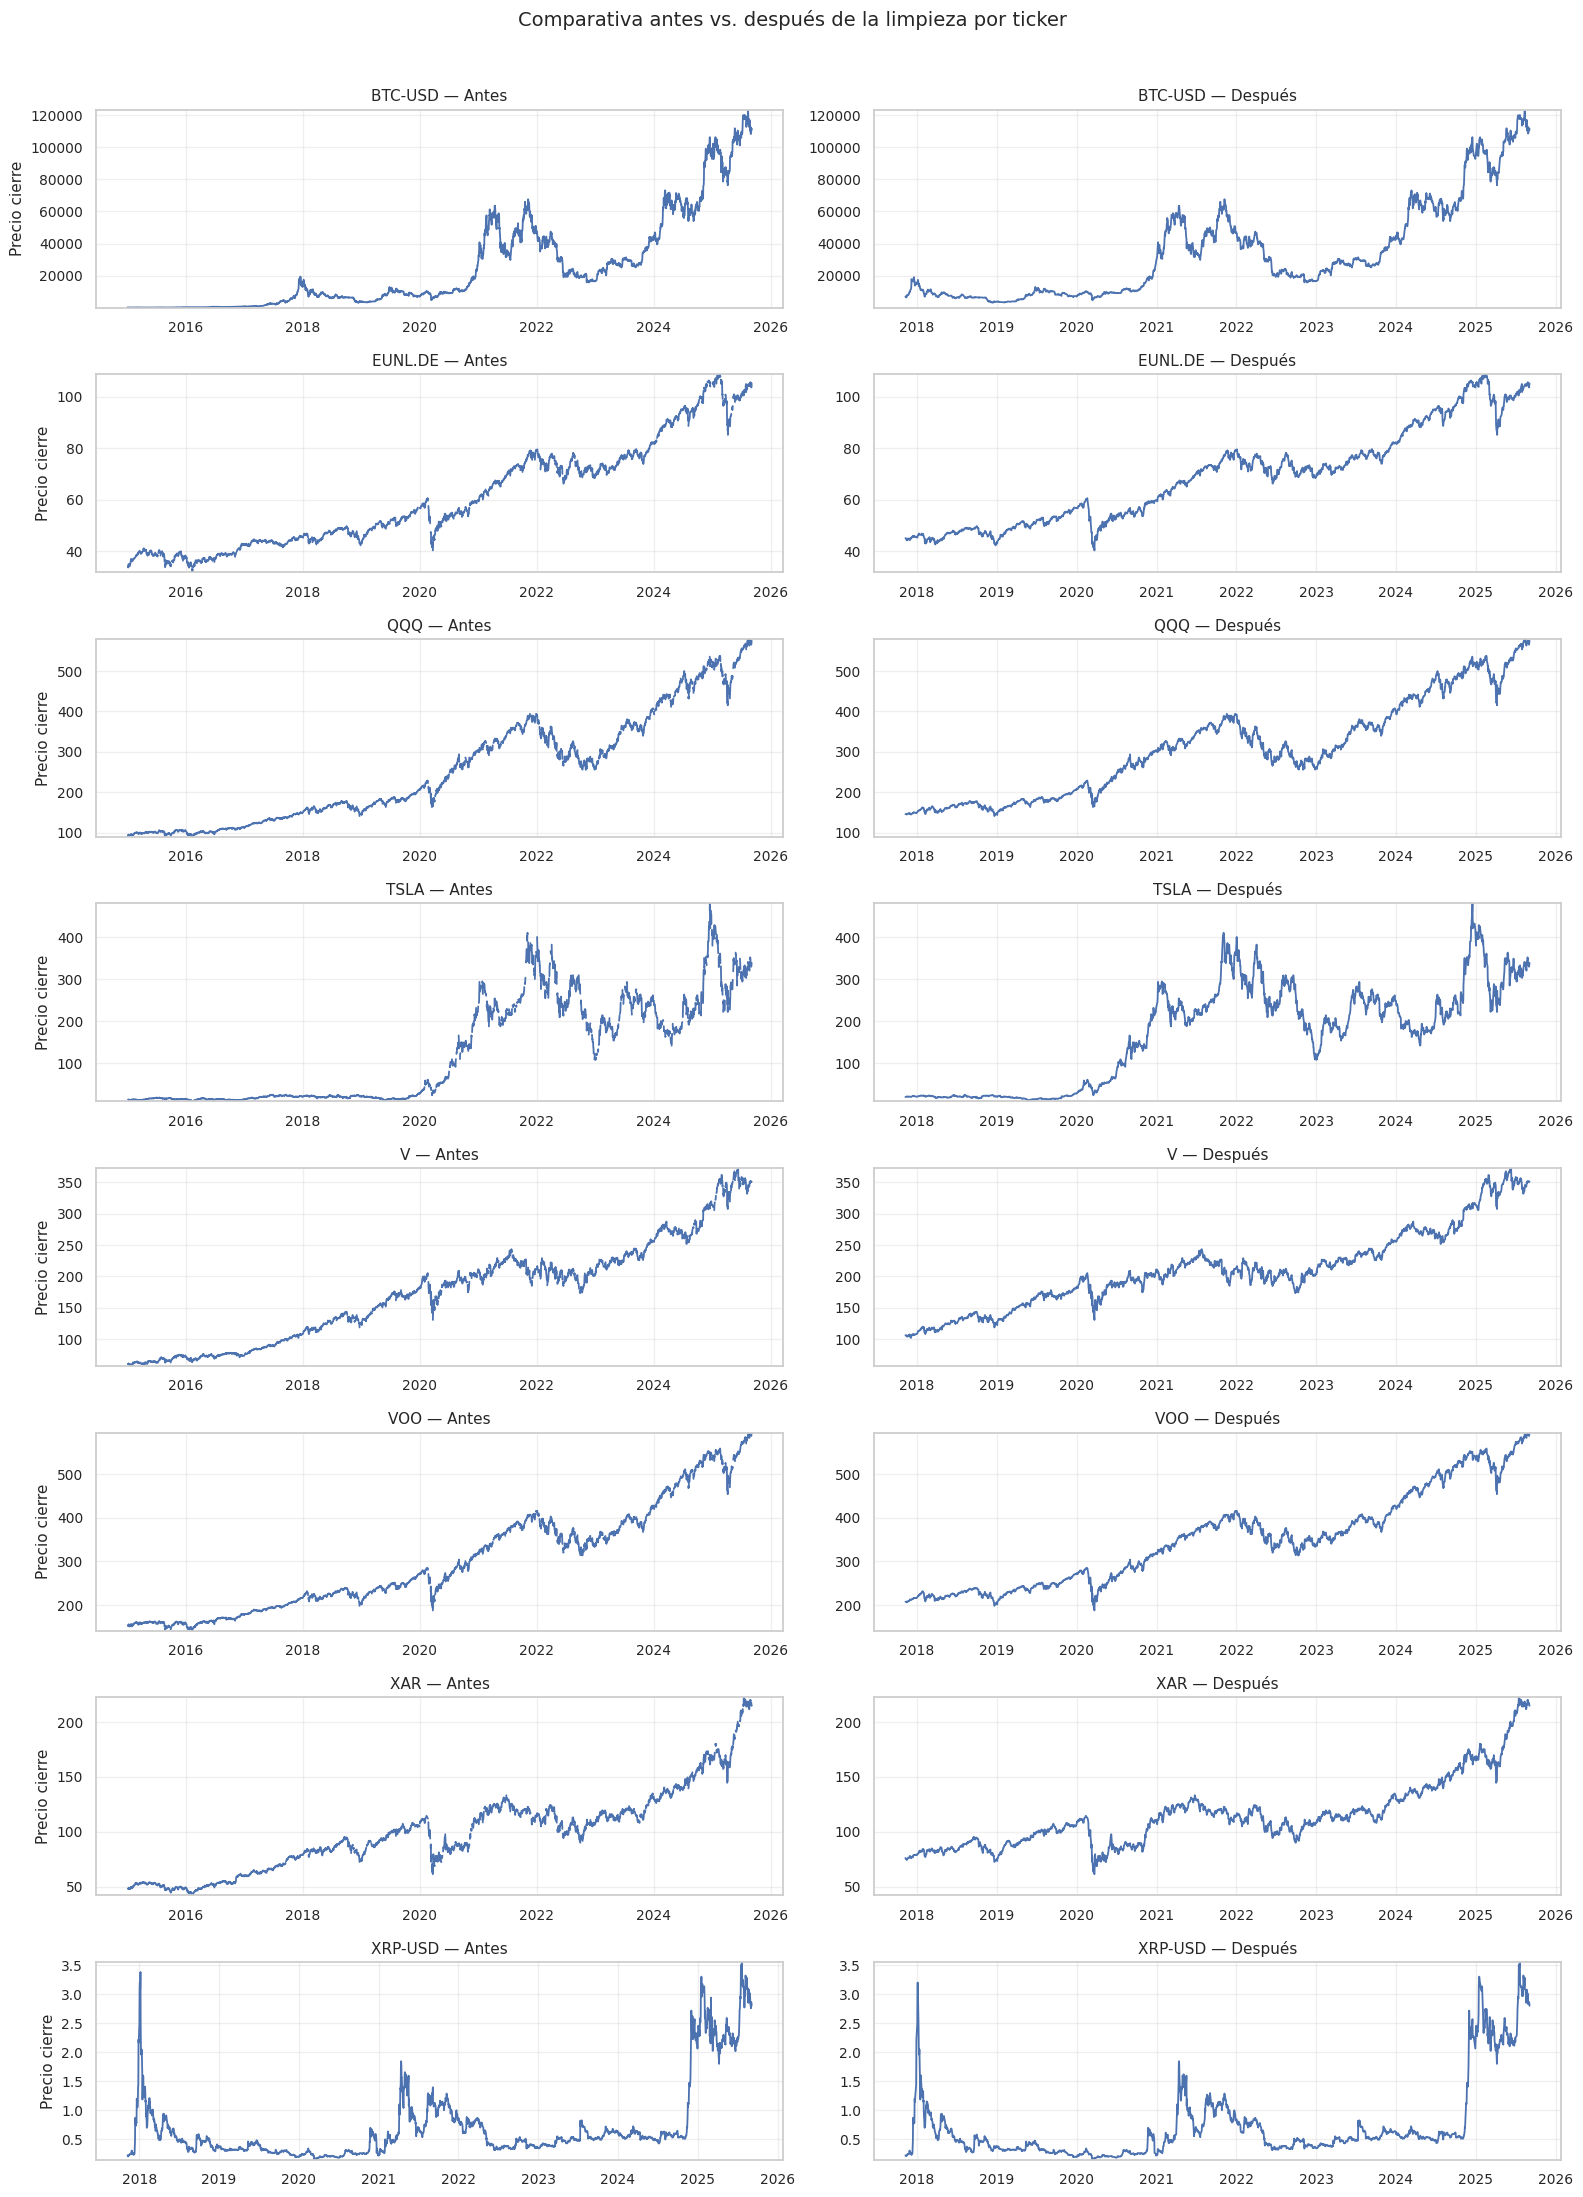

In [23]:
"""Comparativa de graficas por ticker"""
plot_before_after_timeseries(market_df, market_df_clean)

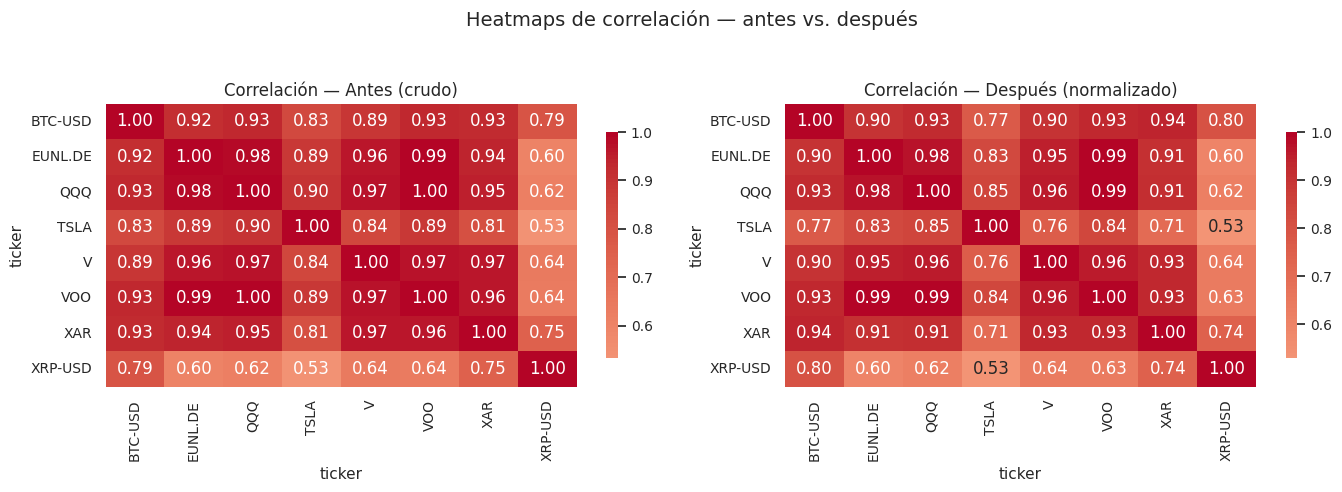

In [24]:
"""Compativas de heatmaps de correlación lado a lado"""
plot_before_after_corr(market_df, market_df_clean)

<!-- Análisis previo de las series -->
<details open>
<summary><h1 style="display:inline; font-size:36px; color:#38a169">5. Análisis previo de las series</h1></summary>

En esta fase realizaremos un diagnóstico detallado de cada serie de tiempo **antes de aplicar modelos predictivos**.  
El objetivo es determinar si cumplen las condiciones estadísticas necesarias y, en caso contrario, aplicar las transformaciones adecuadas.

---

#Objetivos del análisis

1. **Identificar la tendencia**  
   - Visualizar la serie en el tiempo.  
   - Agregar medias y desviaciones móviles (rolling mean/std).  
   - Reconocer si los precios presentan crecimiento sostenido o estabilidad.  

2. **Evaluar la estacionariedad**  
   - Aplicar la prueba ADF (Dickey-Fuller aumentada).  
   - Comparar en tres versiones:
     - Precios originales  
     - Diferencia de precios (Δ)  
     - Rendimientos logarítmicos  
   - Concluir si la serie es o no estacionaria en media.  

3. **Revisar heterocedasticidad (varianza no constante)**  
   - Visualizar rendimientos y rendimientos².  
   - Detectar *clustering* de volatilidad (periodos de calma vs. turbulencia).  

4. **Analizar autocorrelaciones**  
   - Calcular y graficar ACF y PACF en rendimientos.  
   - Calcular y graficar ACF en rendimientos² para evaluar correlación en la varianza.  

5. **Definir transformaciones necesarias**  
   - Decidir si trabajar con Δprecios o rendimientos logarítmicos.  
   - Justificar la aplicación de modelos de volatilidad (ARCH/GARCH) en caso de heterocedasticidad.  

---

<h2 style="font-size:28px; color:#38a169"> Entregables</h2>

- Gráficos por ticker:
  - Serie original con rolling mean/std  
  - Rendimientos y rendimientos²  
  - Funciones ACF y PACF  
- Tabla resumen por ticker:
  - Resultados de la prueba ADF (p-values)  
  - Conclusión de estacionariedad  
  - Transformación recomendada (Δprecio, log-retorno, etc.)  

---

<h2 style="font-size:28px; color:#38a169"> Consideraciones</h2>

- La mayoría de los **precios no son estacionarios**, por lo que deben transformarse.  
- Los **rendimientos suelen ser estacionarios en media**, pero muestran **volatilidad agrupada**, lo cual motiva modelos GARCH.  
- Este análisis es un paso previo y obligatorio: **no podemos aplicar ARIMA o GARCH sin comprobar estas condiciones**.  

</details>


In [25]:
"""
Paso 1: Calcular los rendimientos para cada ticker
"""


# Copiamos el DataFrame limpio
df_returns = market_df_clean.copy()

# Cálculo de rendimientos logarítmicos por ticker
df_returns["log_return"] = (
    df_returns.groupby("ticker")["close"]
    .apply(lambda x: np.log(x) - np.log(x.shift(1))).reset_index(level=0, drop=True)
)

# Cálculo de rendimientos al cuadrado
df_returns["Squared_return"] = df_returns["log_return"] ** 2

# Eliminamos las filas con NaN (primer valor de cada ticker)
df_returns = df_returns.dropna(subset=["log_return"]).reset_index(drop=True)

# Mostramos el nuevo dataframe creado
display(df_returns.groupby("ticker").head(2))  # primeras filas de cada ticker

date   ticker asset_class        close currency  log_return  \
0      2017-11-10  BTC-USD      Crypto  6618.140137      USD   -0.076400   
1      2017-11-13  BTC-USD      Crypto  6559.490234      USD   -0.008901   
1930   2017-11-10  EUNL.DE         ETF    44.880001      EUR   -0.002003   
1931   2017-11-13  EUNL.DE         ETF    44.820000      EUR   -0.001338   
3860   2017-11-10      QQQ         ETF   145.729889      USD   -0.000065   
3861   2017-11-13      QQQ         ETF   145.910019      USD    0.001235   
5790   2017-11-10     TSLA       Stock    20.199333      USD    0.000000   
5791   2017-11-13     TSLA       Stock    21.026667      USD    0.040142   
7720   2017-11-10        V       Stock   105.868759      USD   -0.002321   
7721   2017-11-13        V       Stock   105.414551      USD   -0.004300   
9650   2017-11-10      VOO         ETF   207.851822      USD   -0.000591   
9651   2017-11-13      VOO         ETF   208.097366      USD    0.001181   
11580  2017-11-10      XAR         ETF    75.530838      USD   -0.008699   
11581  2017-11-13      XAR         ETF    74.880341      USD   -0.008650   
13510  2017-11-10  XRP-USD      Crypto     0.206483      USD   -0.051926   
13511  2017-11-13  XRP-USD      Crypto     0.203442      USD   -0.014837   

       Squared_return  
0        5.836911e-03  
1        7.923657e-05  
1930     4.013383e-06  
1931     1.789772e-06  
3860     4.227638e-09  
3861     1.525943e-06  
5790     0.000000e+00  
5791     1.611370e-03  
7720     5.387175e-06  
7721     1.848593e-05  
9650     3.490339e-07  
9651     1.393926e-06  
11580    7.566986e-05  
11581    7.481632e-05  
13510    2.696267e-03  
13511    2.201404e-04

In [26]:
"""
Creamos las ventanas móviles para el análisis
"""
# Ventanas móviles para precio: corta y larga (en días hábiles)
window_short = 20   # ~ 1 mes
window_long  = 60   # ~ 3 meses

# Tickers a graficar (usa todos o filtra una lista)
tickers_to_plot = sorted(df_returns["ticker"].unique())
# tickers_to_plot = ["VOO", "QQQ", "BTC-USD"]  # ejemplo de subset
# ============================================================================

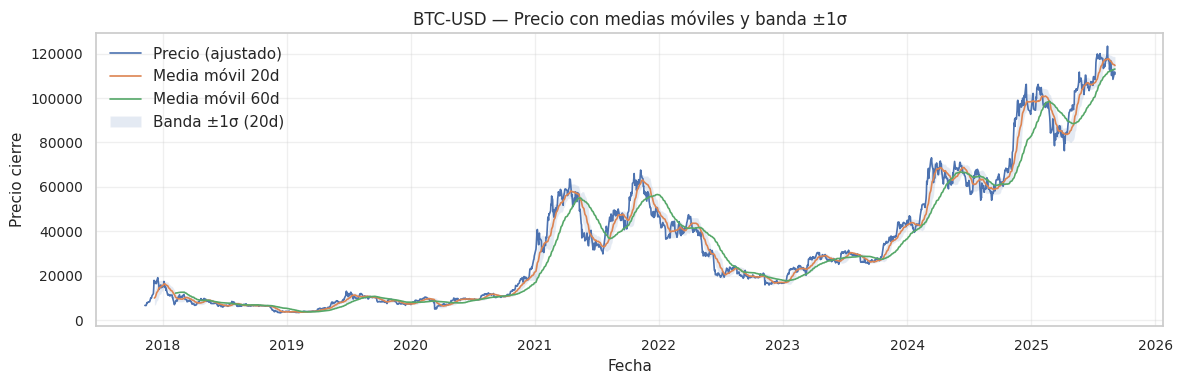

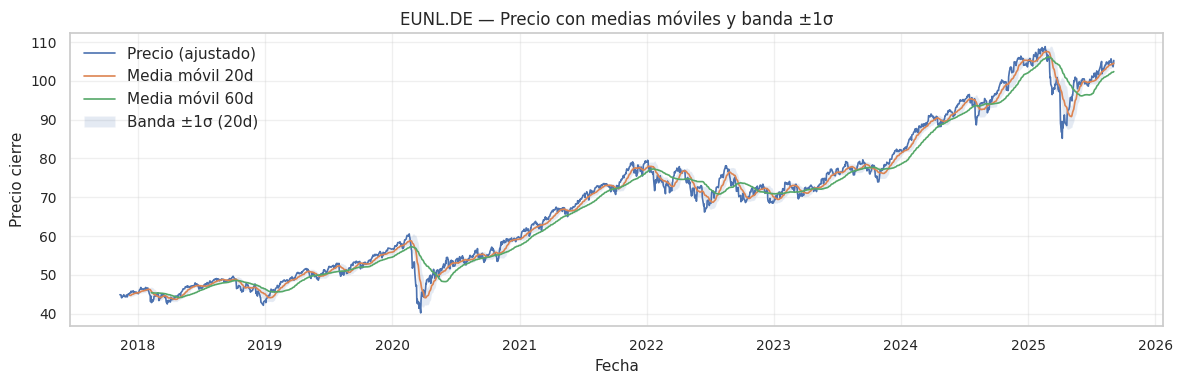

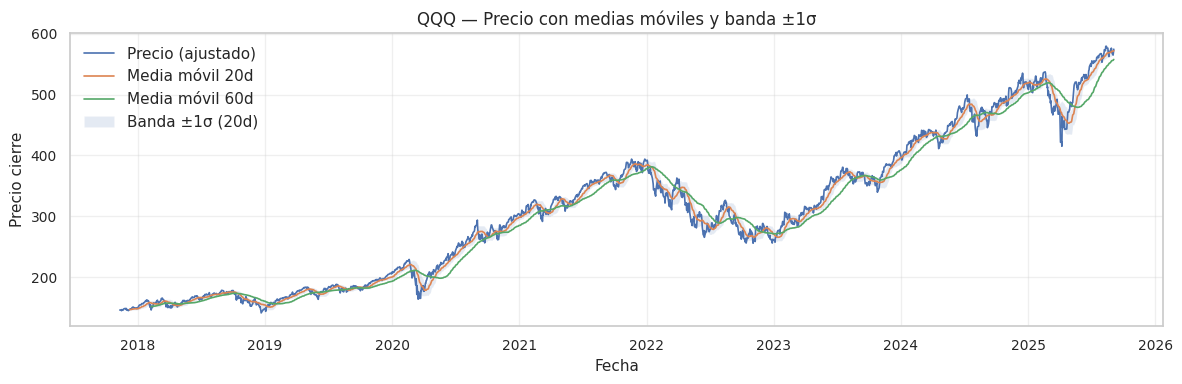

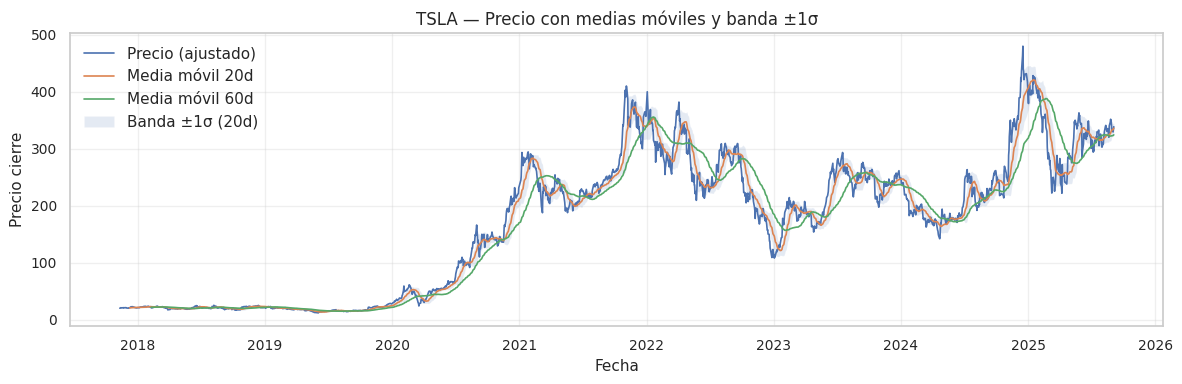

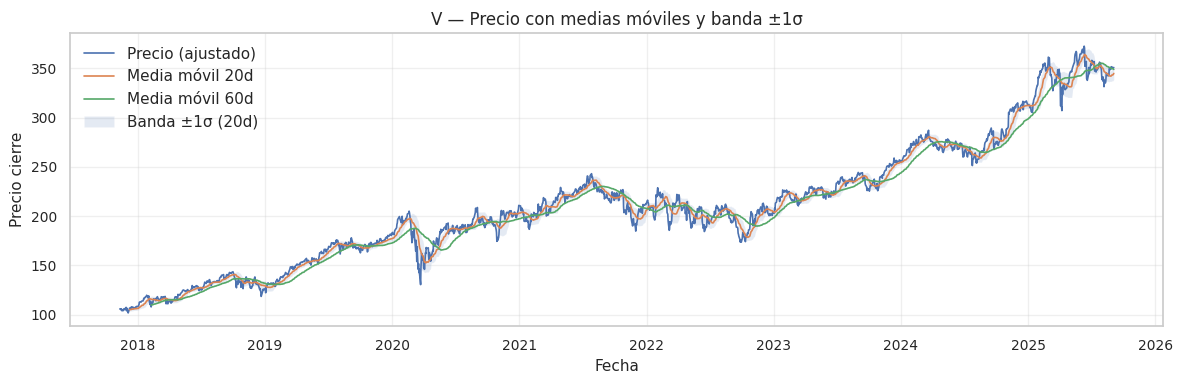

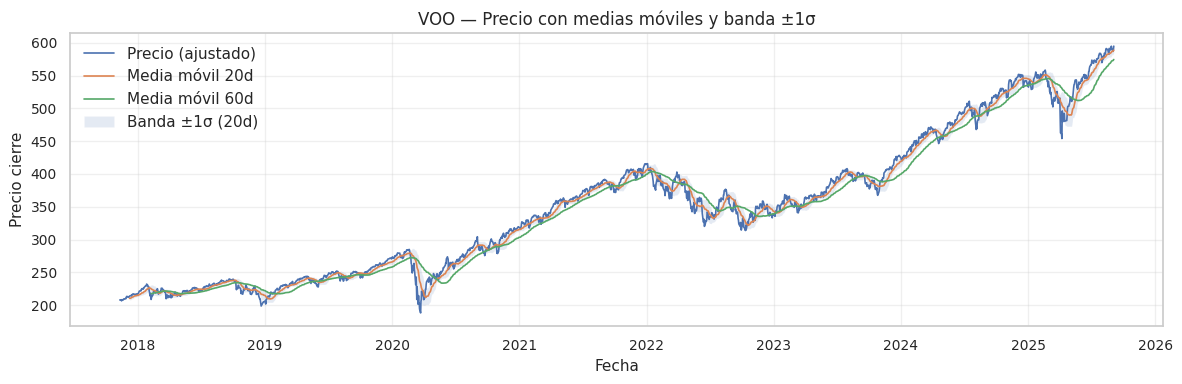

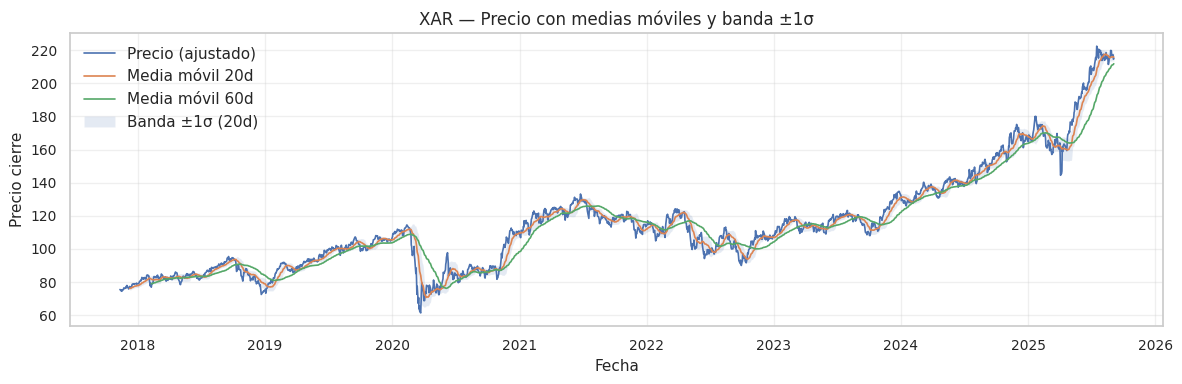

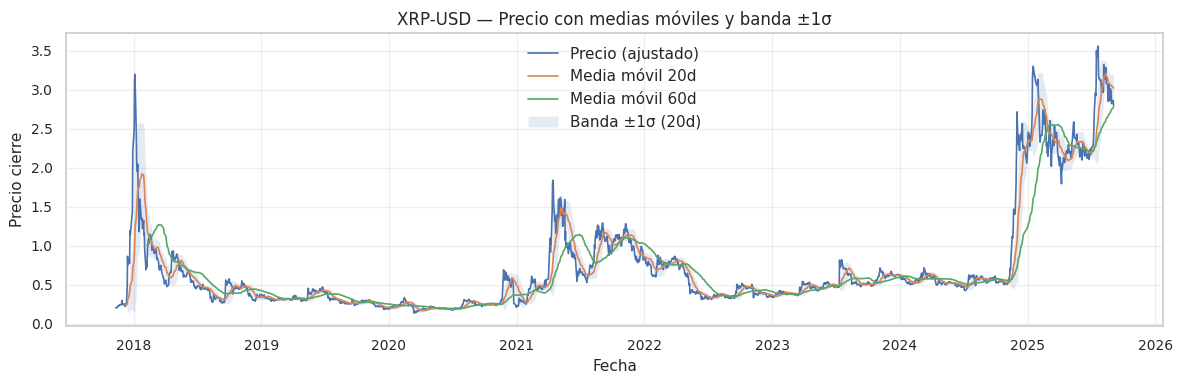

In [27]:

"""
Creamos el rolling mean y roalling std para cada ticker
"""
for tk in tickers_to_plot:
    data_tk = (df_returns[df_returns["ticker"] == tk]
               .sort_values("date")
               .copy())

    # Rolling mean y std sobre precio
    data_tk["roll_mean_s"] = data_tk["close"].rolling(window_short, min_periods=window_short).mean()
    data_tk["roll_std_s"]  = data_tk["close"].rolling(window_short, min_periods=window_short).std()

    data_tk["roll_mean_l"] = data_tk["close"].rolling(window_long, min_periods=window_long).mean()
    data_tk["roll_std_l"]  = data_tk["close"].rolling(window_long, min_periods=window_long).std()

    # Banda simple: media corta ± 1*std corta (solo con fines ilustrativos)
    upper_band = data_tk["roll_mean_s"] + data_tk["roll_std_s"]
    lower_band = data_tk["roll_mean_s"] - data_tk["roll_std_s"]

    plt.figure(figsize=(12, 4))
    plt.plot(data_tk["date"], data_tk["close"], label="Precio (ajustado)", lw=1.2)
    plt.plot(data_tk["date"], data_tk["roll_mean_s"], label=f"Media móvil {window_short}d", lw=1.2)
    plt.plot(data_tk["date"], data_tk["roll_mean_l"], label=f"Media móvil {window_long}d", lw=1.2)

    # Banda ±1 std (sombreado)
    plt.fill_between(
        data_tk["date"],
        lower_band,
        upper_band,
        alpha=0.15,
        label=f"Banda ±1σ ({window_short}d)"
    )

    plt.title(f"{tk} — Precio con medias móviles y banda ±1σ")
    plt.ylabel("Precio cierre")
    plt.xlabel("Fecha")
    plt.grid(True, alpha=0.3)
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

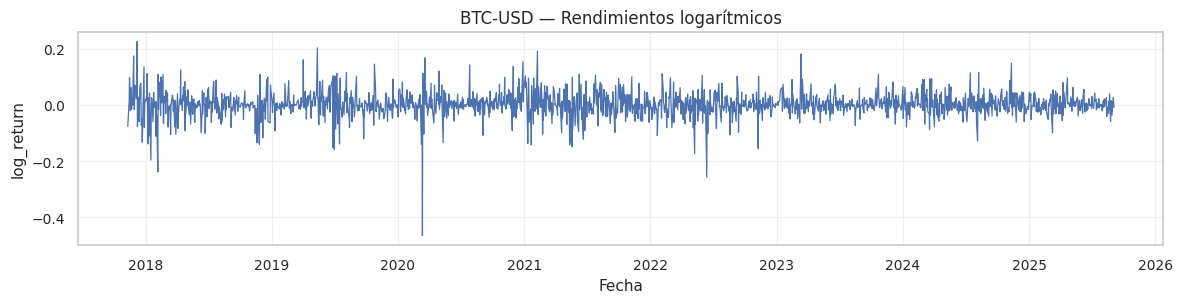

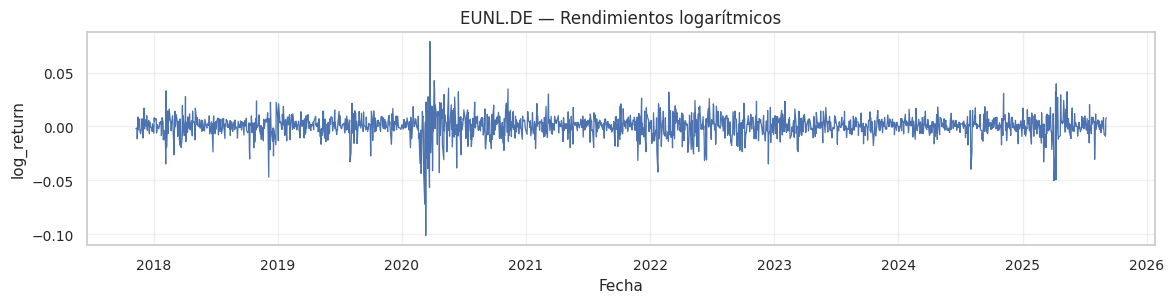

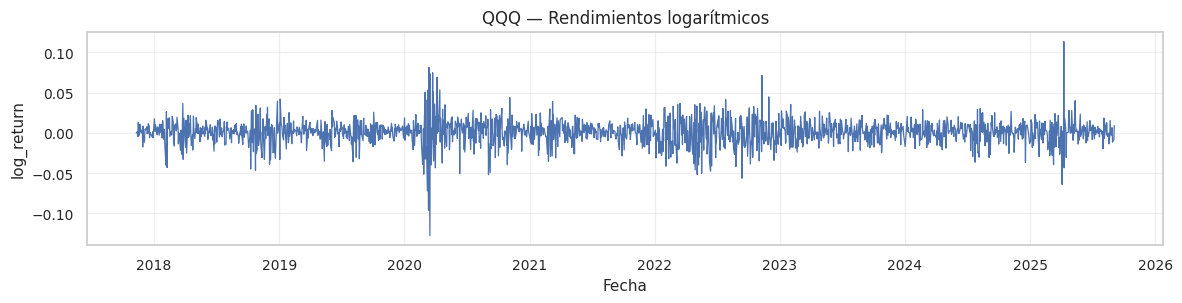

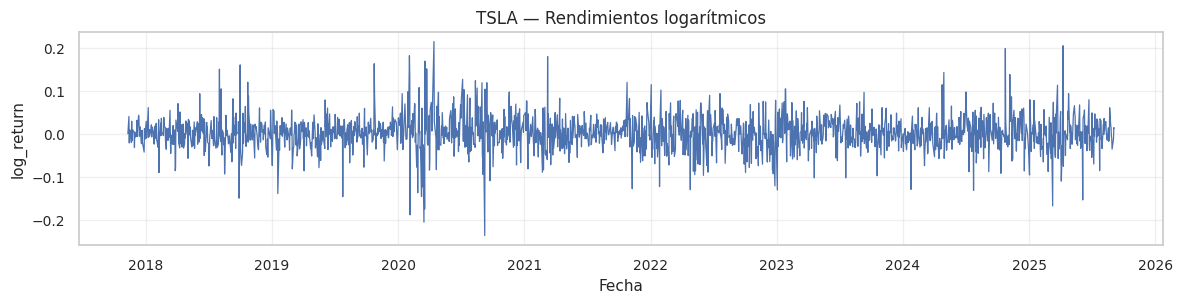

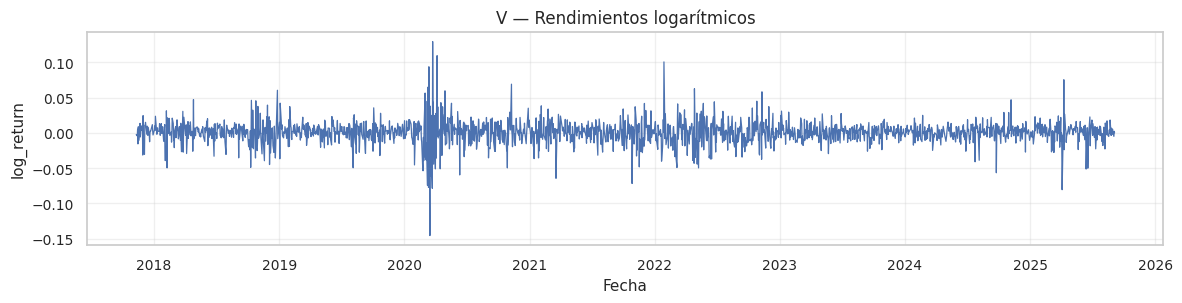

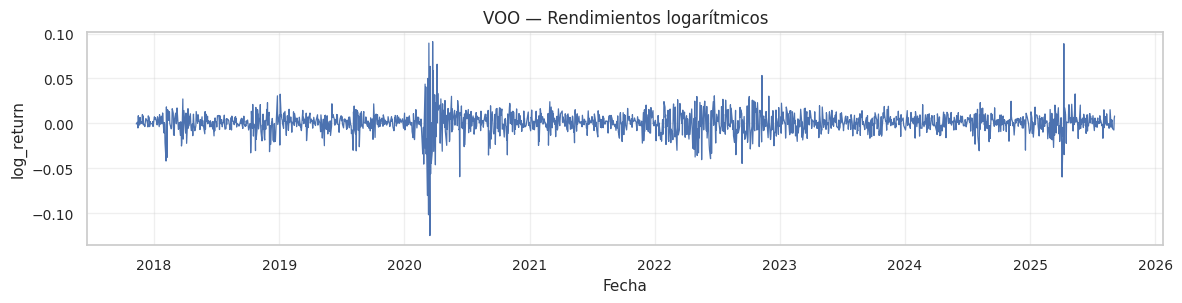

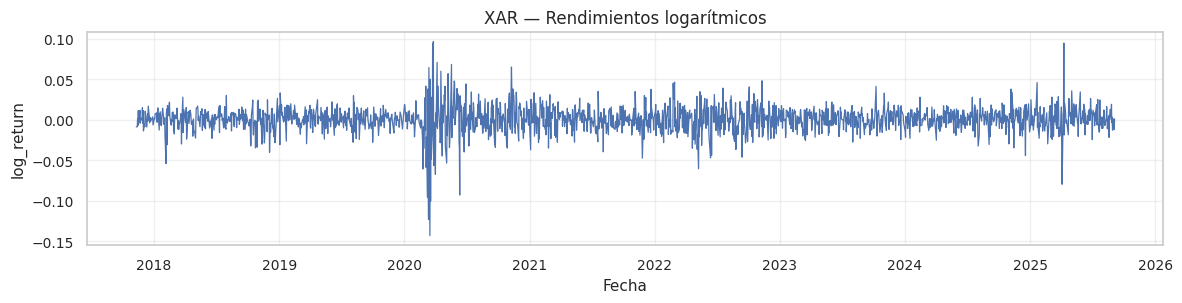

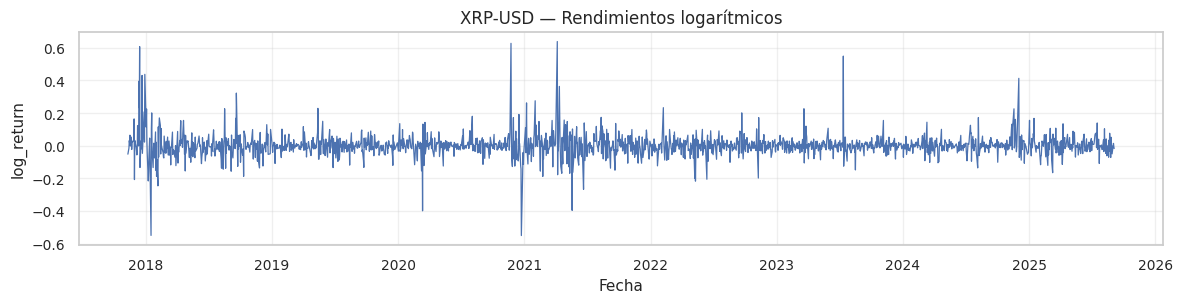

In [28]:
"""
Graficamos los rendimientos logaritmicos para cada ticker
"""
for tk in tickers_to_plot:
    data_tk = (df_returns[df_returns["ticker"] == tk]
               .sort_values("date")
               .copy())

    plt.figure(figsize=(12, 3.2))
    plt.plot(data_tk["date"], data_tk["log_return"], lw=0.9)
    plt.title(f"{tk} — Rendimientos logarítmicos")
    plt.ylabel("log_return")
    plt.xlabel("Fecha")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

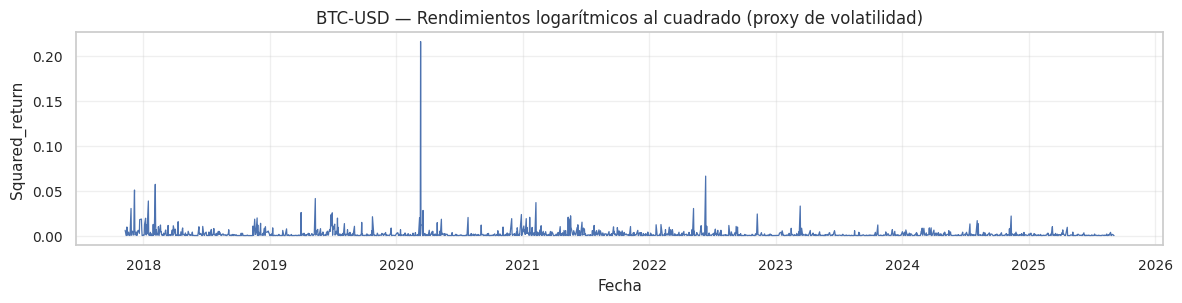

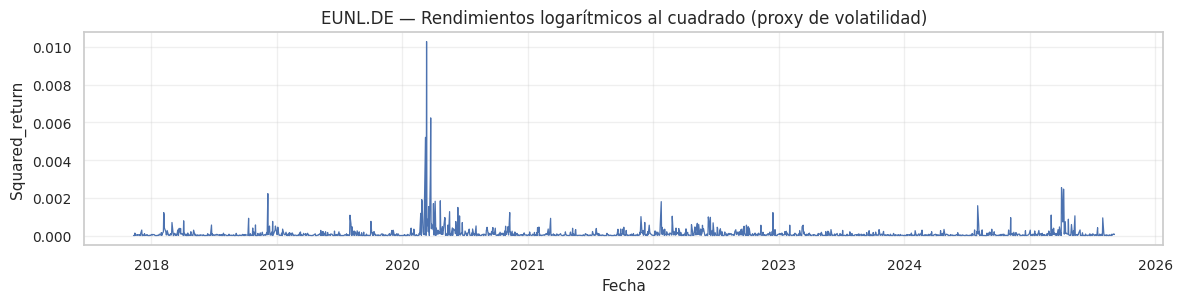

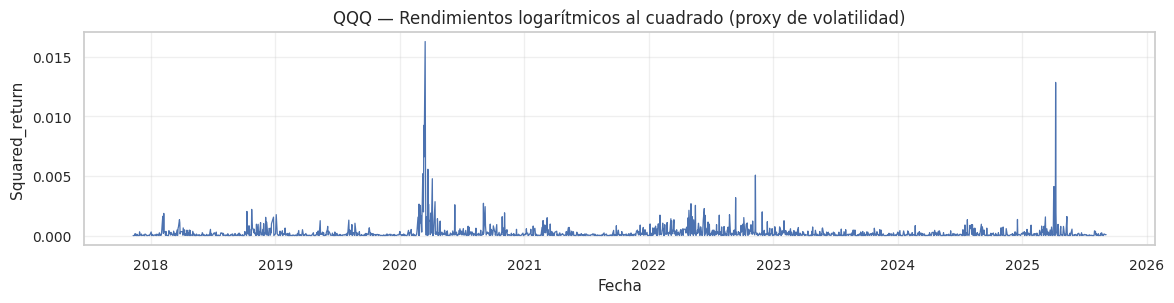

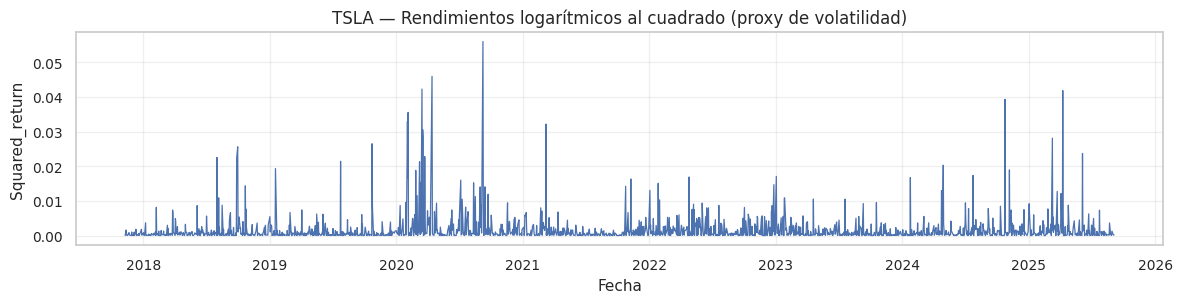

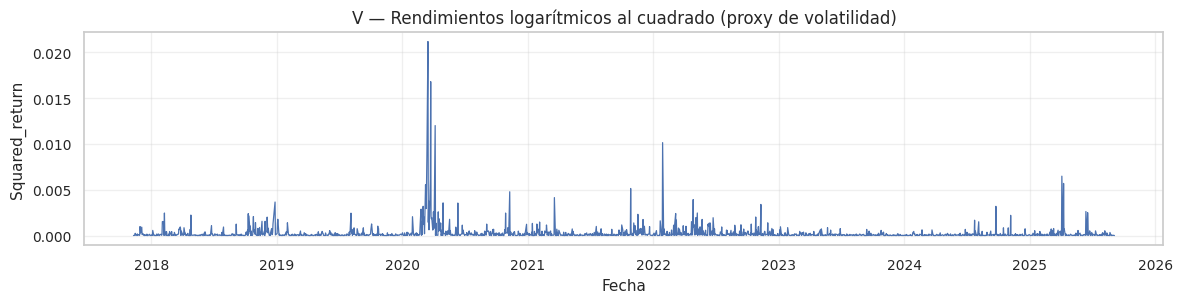

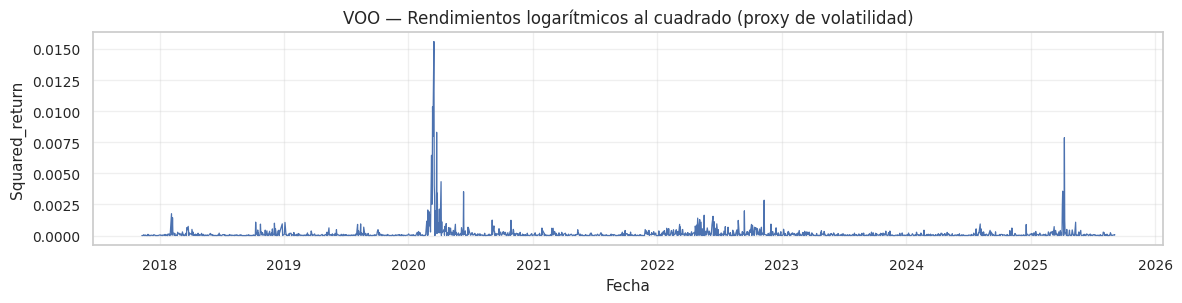

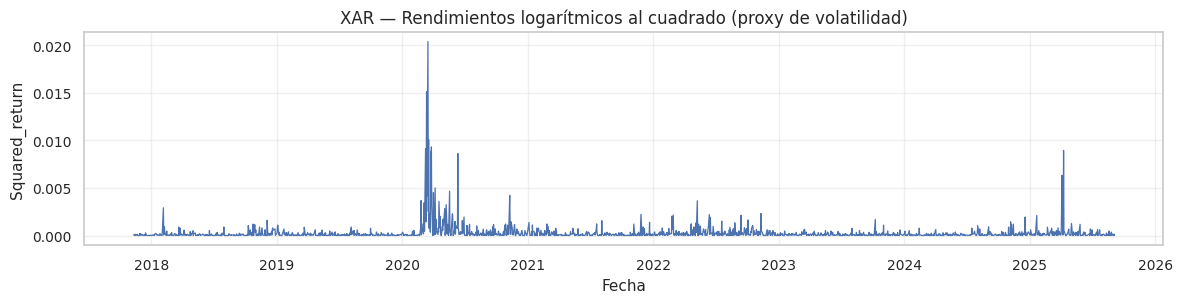

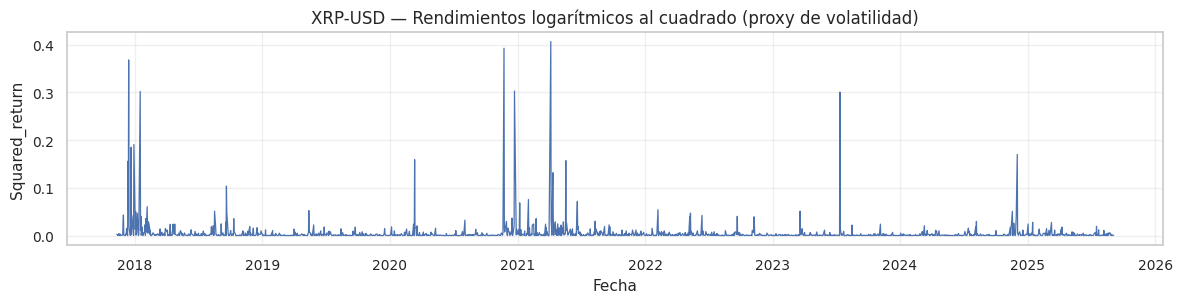

In [29]:
"""
Graficamos los rendimientos al cuadrado para cada ticker
"""
for tk in tickers_to_plot:
    data_tk = (df_returns[df_returns["ticker"] == tk]
               .sort_values("date")
               .copy())

    plt.figure(figsize=(12, 3.2))
    plt.plot(data_tk["date"], data_tk["Squared_return"], lw=0.9)
    plt.title(f"{tk} — Rendimientos logarítmicos al cuadrado (proxy de volatilidad)")
    plt.ylabel("Squared_return")
    plt.xlabel("Fecha")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [30]:
"""
Prueba de estacionariedad con ADF (Dickey-Fuller Aumentada)
 ----------------------------------------------------------------------------
 Objetivo:
 - Evaluar si las series de tiempo son estacionarias.
 - Aplicar ADF a:
     1) Serie de precios
     2) Serie de diferencias de precios
     3) Rendimientos logarítmicos
"""

# Función auxiliar: devuelve el p-value del test ADF
def adf_pvalue(series):
    try:
        result = adfuller(series.dropna(), autolag="AIC")
        return result[1]   # p-value
    except Exception:
        return np.nan

# Lista para resultados
adf_results = []

# Iteramos por cada ticker
for tk in sorted(df_returns["ticker"].unique()):
    subset = df_returns[df_returns["ticker"] == tk].sort_values("date")

    # --- 1) Precios
    p_close = adf_pvalue(subset["close"])

    # --- 2) Diferencia de precios
    p_diff = adf_pvalue(subset["close"].diff())

    # --- 3) Rendimientos logarítmicos
    p_logret = adf_pvalue(subset["log_return"])

    adf_results.append({
        "ticker": tk,
        "p_close": p_close,
        "p_diff_close": p_diff,
        "p_log_return": p_logret
    })

# Convertimos a DataFrame
adf_df = pd.DataFrame(adf_results).sort_values("ticker").reset_index(drop=True)

# Mostramos tabla comparativa
display(adf_df)

ticker   p_close  p_diff_close  p_log_return
0  BTC-USD  0.925186  9.183527e-11  0.000000e+00
1  EUNL.DE  0.944511  0.000000e+00  1.752700e-23
2      QQQ  0.976494  8.942531e-16  1.587501e-26
3     TSLA  0.485317  4.290553e-15  0.000000e+00
4        V  0.922906  3.973248e-30  1.348206e-25
5      VOO  0.985186  3.903094e-16  1.099588e-25
6      XAR  0.989083  4.397467e-27  2.301593e-22
7  XRP-USD  0.738074  1.090657e-19  2.583331e-18

In [31]:
df_returns["log_return_sq"] = df_returns["log_return"] ** 2


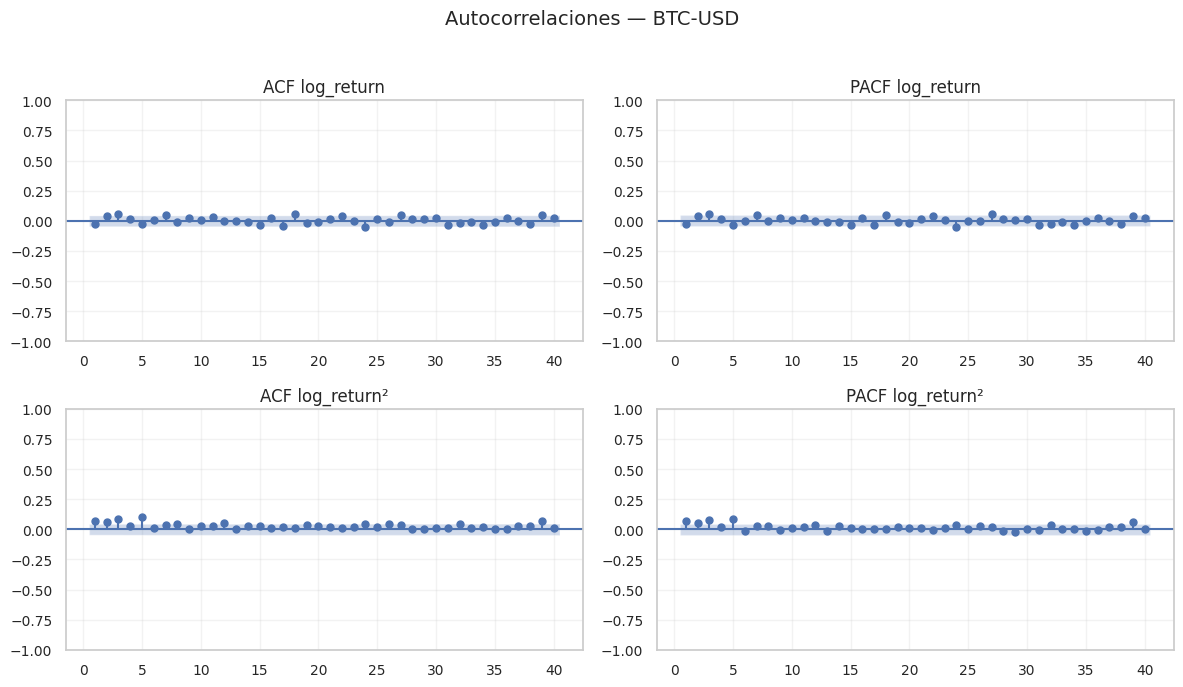

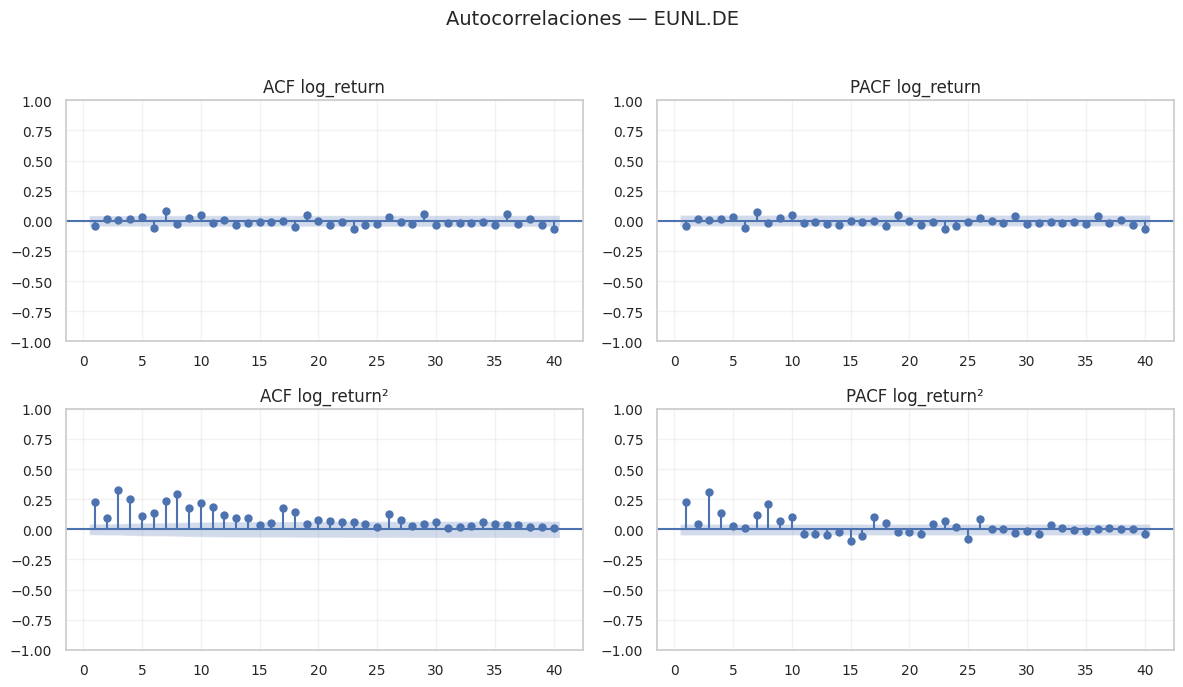

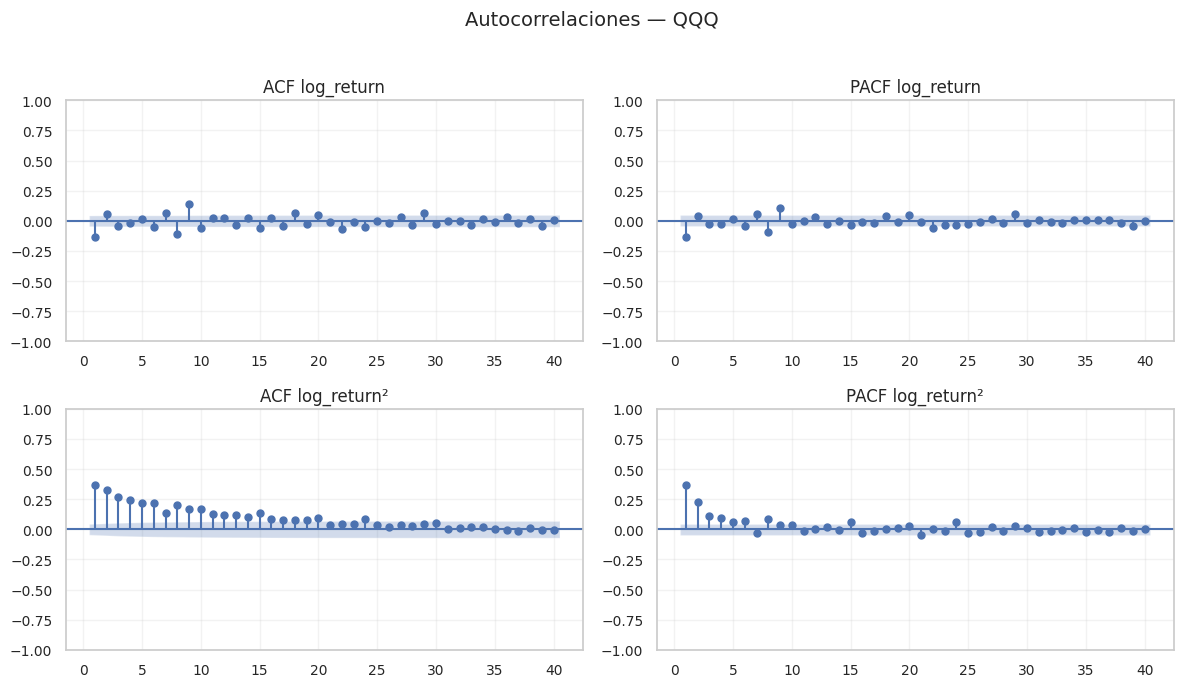

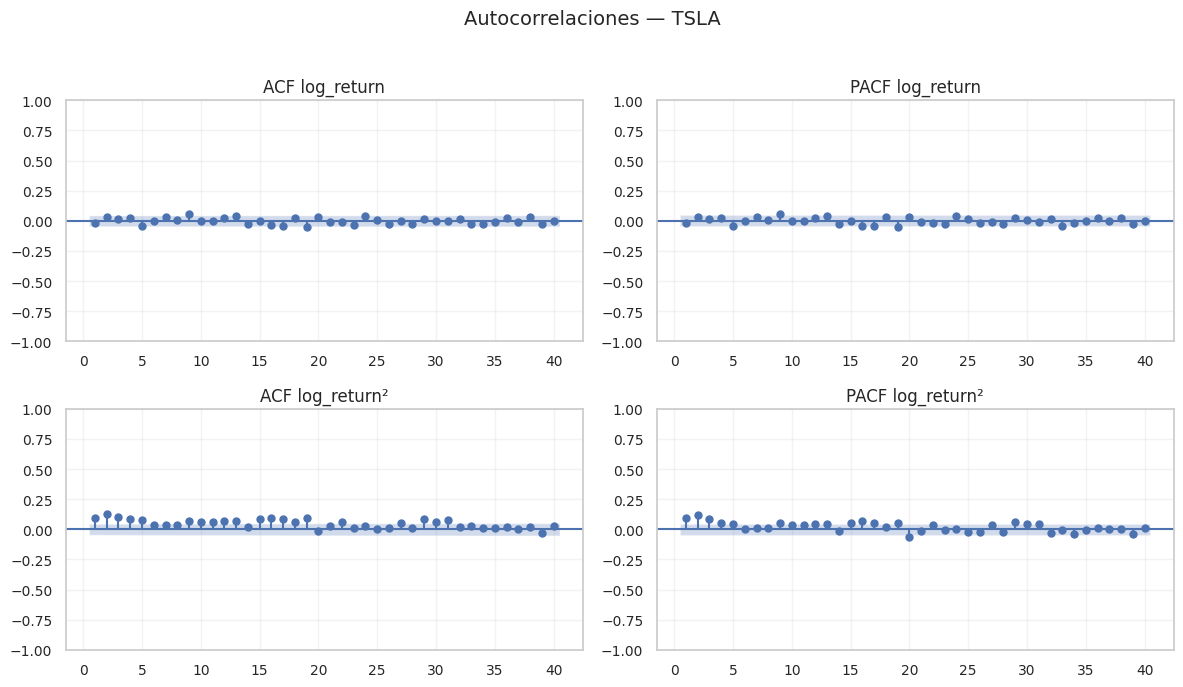

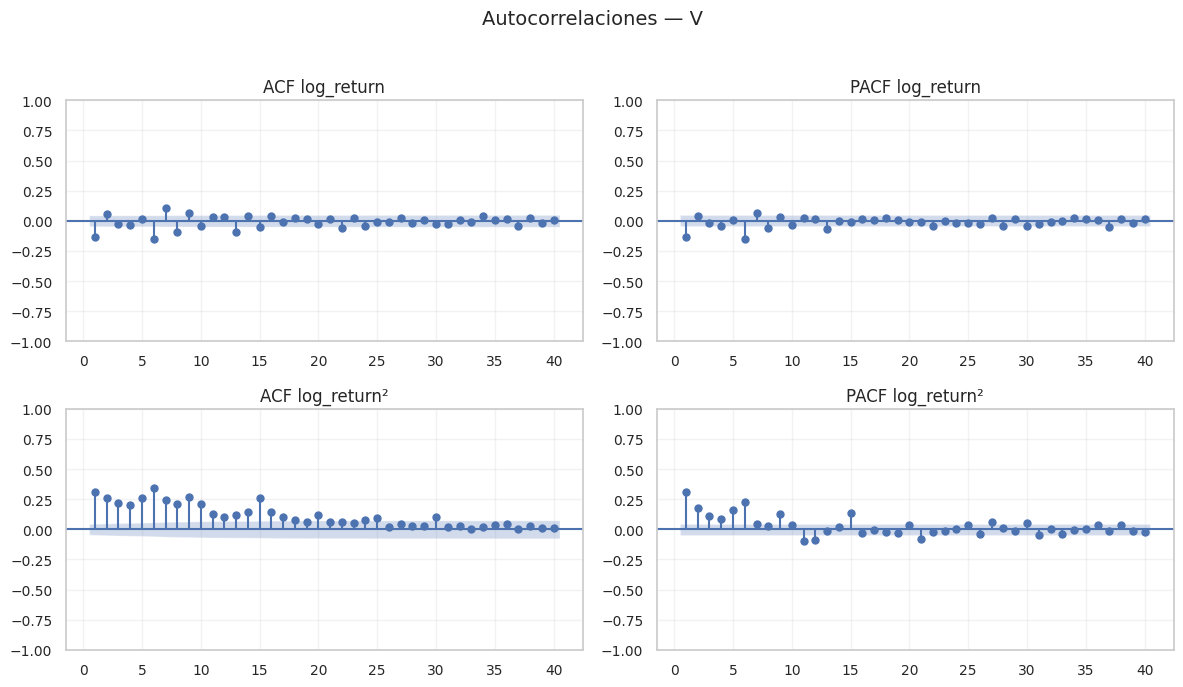

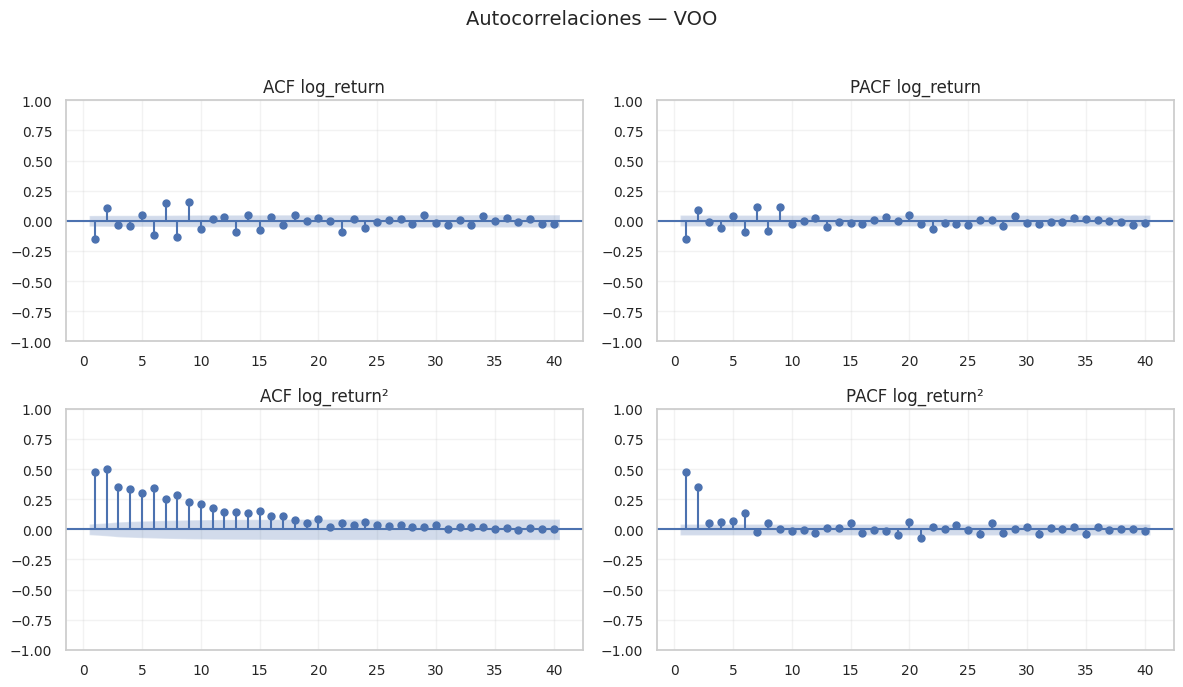

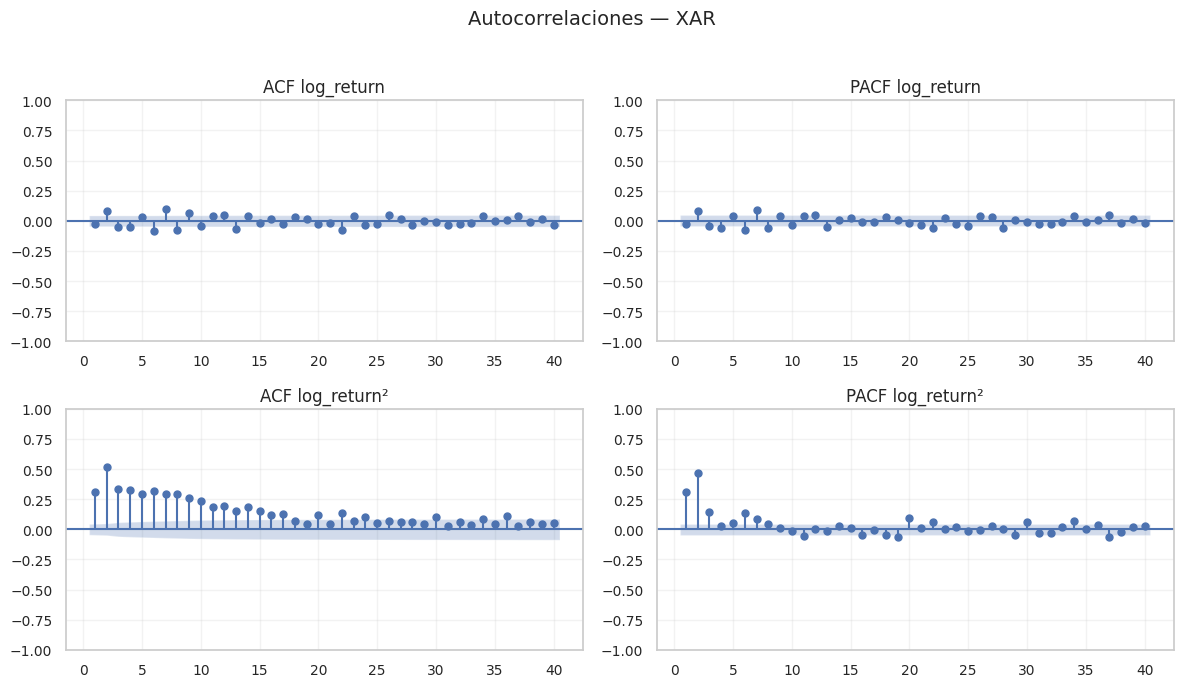

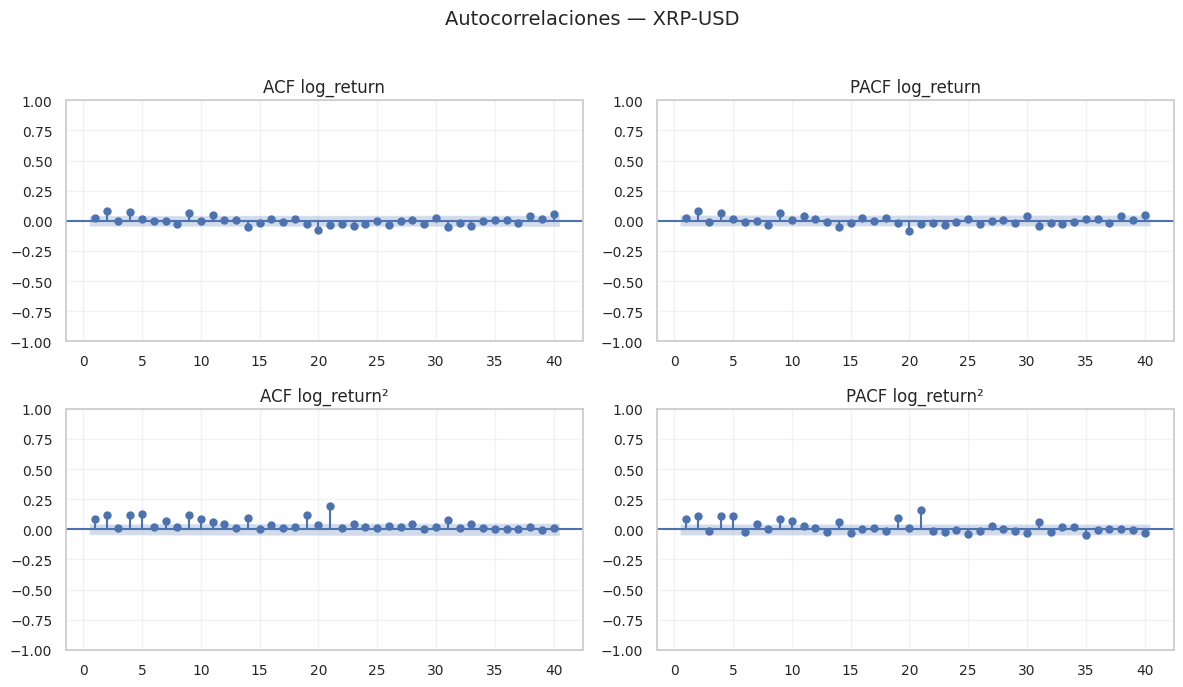

In [32]:
"""
Autocorrelaciones (ACF y PACF)
# ----------------------------------------------------------------------------
# Objetivo:
# - Analizar dependencias en la media (log_return) y en la varianza (log_return_sq).
# - Usamos:
#     • ACF y PACF de log_return  → guía para AR/MA/ARIMA
#     • ACF y PACF de log_return_sq → evidencia de heterocedasticidad (GARCH)
#
# Notas:
# - Protegemos contra series vacías tras limpieza (dropna).
# - 'lags=40' es estándar para diarios; puedes ajustarlo.

"""

# --- Selección de activos a graficar (todos por defecto)
tickers_to_plot = sorted(df_returns["ticker"].unique())
# tickers_to_plot = ["VOO", "QQQ", "BTC-USD"]  # <- ejemplo de subset

# --- Número de rezagos a mostrar ---
nlags = 40

for tk in tickers_to_plot:
    # Subconjunto ordenado por fecha para el ticker
    sub = (df_returns[df_returns["ticker"] == tk]
           .sort_values("date")
           .copy())

    # Series para ACF/PACF (sin nulos)
    lr   = sub["log_return"].dropna()
    lrsq = sub["log_return_sq"].dropna()

    # Si por alguna razón la serie quedó muy corta, saltamos
    if len(lr) < 10 or len(lrsq) < 10:
        print(f" {tk}: datos insuficientes para ACF/PACF (len={len(lr)}, len_sq={len(lrsq)}).")
        continue

    # Figura 2x2: ACF/PACF en log_return y en log_return_sq
    fig, axes = plt.subplots(2, 2, figsize=(12, 7))
    fig.suptitle(f"Autocorrelaciones — {tk}", fontsize=14)

    # --- Media: ACF/PACF de rendimientos ---
    plot_acf(lr, ax=axes[0, 0], lags=nlags, zero=False)
    axes[0, 0].set_title("ACF log_return")

    # Método 'ywm' (Yule-Walker modificado) es estable para PACF
    plot_pacf(lr, ax=axes[0, 1], lags=nlags, zero=False, method="ywm")
    axes[0, 1].set_title("PACF log_return")

    # --- Varianza: ACF/PACF de rendimientos² ---
    plot_acf(lrsq, ax=axes[1, 0], lags=nlags, zero=False)
    axes[1, 0].set_title("ACF log_return²")

    plot_pacf(lrsq, ax=axes[1, 1], lags=nlags, zero=False, method="ywm")
    axes[1, 1].set_title("PACF log_return²")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()




In [33]:

"""
Tabla resumen por activo
# ----------------------------------------------------------------------------
# Objetivo:
# - Combinar resultados del test ADF (paso 3) con evidencia de heterocedasticidad
#   (autocorrelación en rendimientos²) y definir la transformación recomendada.
"""


summary_rows = []

# Parámetros para ACF de rendimientos²
acf_lags = 20
acf_threshold = 0.2   # si la autocorrelación media > 0.2 ⇒ heterocedasticidad notable

for tk in sorted(df_returns["ticker"].unique()):
    sub = df_returns[df_returns["ticker"] == tk].sort_values("date")

    # --- ADF sobre precios, Δprecios y log_return ---
    try:
        p_close = adf_pvalue(sub["close"])
        p_diff  = adf_pvalue(sub["close"].diff())
        p_lr    = adf_pvalue(sub["log_return"])
    except Exception:
        p_close, p_diff, p_lr = np.nan, np.nan, np.nan

    # --- ACF de rendimientos² (heterocedasticidad) ---
    try:
        acf_vals = acf(sub["log_return_sq"].dropna(), nlags=acf_lags)
        mean_acf_sq = np.mean(np.abs(acf_vals[1:]))   # promedio de autocorrelaciones (sin lag 0)
        hetero = "Sí" if mean_acf_sq > acf_threshold else "No"
    except Exception:
        mean_acf_sq, hetero = np.nan, "Desconocido"

    # --- Transformación recomendada ---
    if p_close >= 0.05 and p_lr < 0.05:
        transform = "Rendimientos logarítmicos"
    elif p_close >= 0.05 and p_diff < 0.05:
        transform = "Diferencia de precios (Δclose)"
    elif p_close < 0.05:
        transform = "Precios (ya estacionarios)"
    else:
        transform = "Revisar manualmente"

    summary_rows.append({
        "ticker": tk,
        "ADF_p_close": p_close,
        "ADF_p_diff": p_diff,
        "ADF_p_log_return": p_lr,
        "Heterocedasticidad": hetero,
        "Transformación recomendada": transform
    })

# Convertimos a DataFrame y ordenamos
summary_df = pd.DataFrame(summary_rows).sort_values("ticker").reset_index(drop=True)

# Mostramos resultados
display(summary_df.style.format({
    "ADF_p_close": "{:.4f}",
    "ADF_p_diff": "{:.4f}",
    "ADF_p_log_return": "{:.4f}"
}).set_caption("📊 Resumen de estacionariedad y transformaciones por activo"))


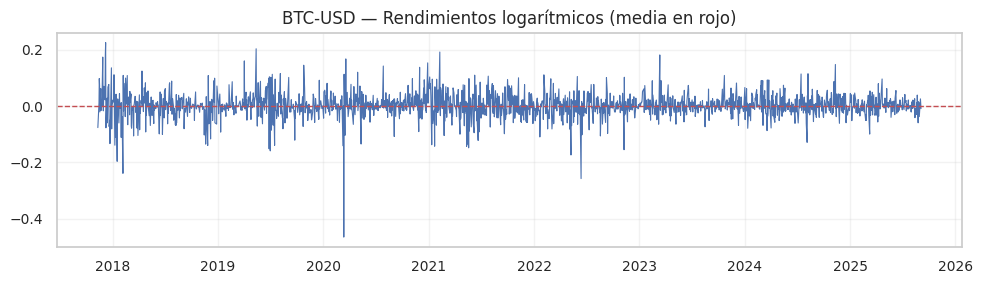

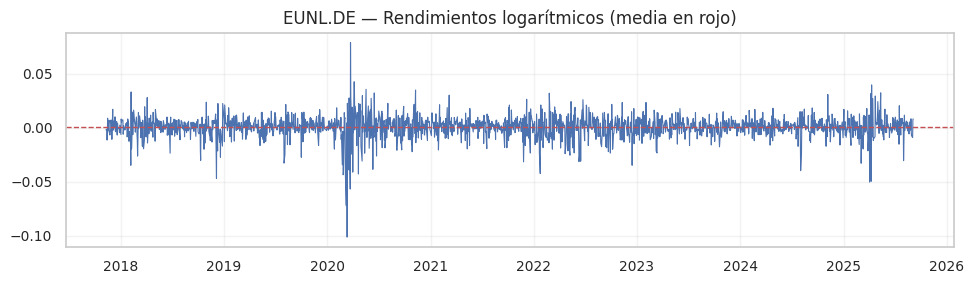

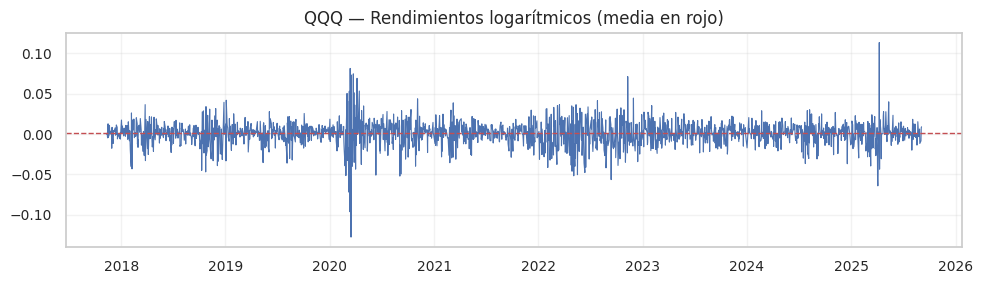

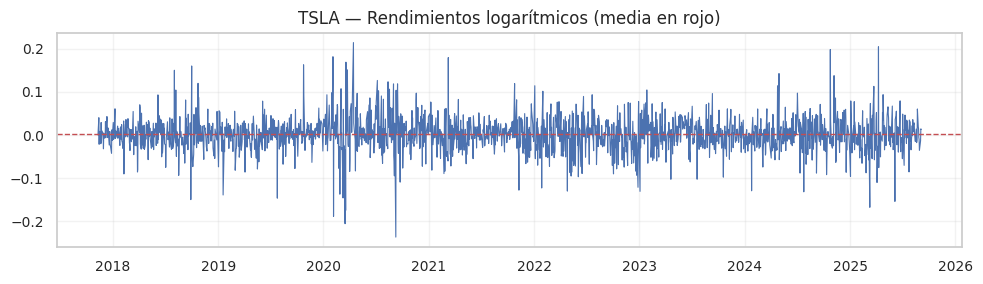

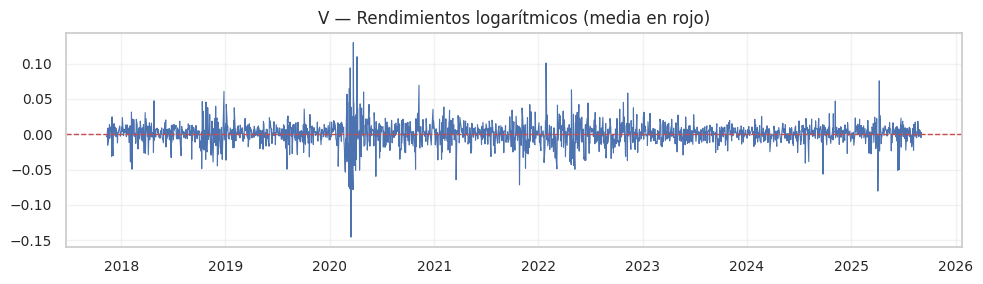

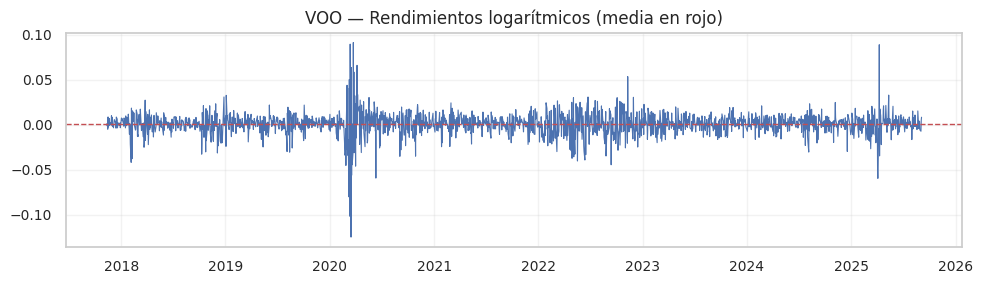

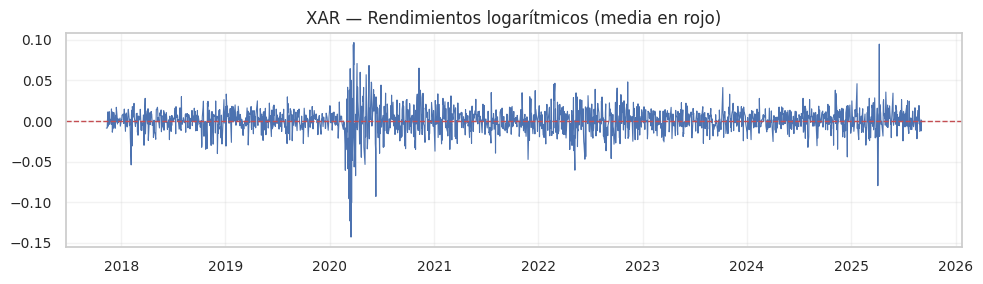

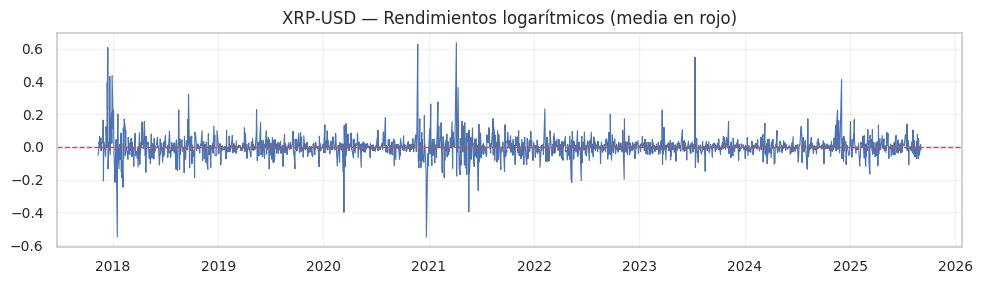

In [34]:
for tk in sorted(df_returns["ticker"].unique()):
    sub = df_returns[df_returns["ticker"] == tk]
    plt.figure(figsize=(10,3))
    plt.plot(sub["date"], sub["log_return"], lw=0.8)
    plt.axhline(y=sub["log_return"].mean(), color='r', linestyle='--', lw=1)
    plt.title(f"{tk} — Rendimientos logarítmicos (media en rojo)")
    plt.tight_layout()
    plt.show()


### 🔹 Transformación y verificación de estacionariedad de las series de tiempo

De acuerdo con los resultados obtenidos en la **prueba ADF inicial**, ninguna de las series de precios (`p_close`) es estacionaria, ya que todas presentan valores de *p* superiores a 0.05.  
Esto indica que las series presentan **tendencia** y **varianza no constante**, características comunes en activos financieros y que impiden aplicar directamente modelos de predicción como ARIMA o GARCH.

Para garantizar la validez de los modelos de series temporales, es necesario aplicar transformaciones que estabilicen la media y la varianza, logrando así series estacionarias.

#### Transformaciones aplicadas

1. **Diferenciación de primer orden**  
   Esta transformación elimina la tendencia y ayuda a estabilizar la media:
   \[
   y'_t = y_t - y_{t-1}
   \]

   \

2. **Retornos logarítmicos**  
   Esta transformación estabiliza la varianza y permite trabajar en términos relativos de cambio:
   \[
   r_t = \ln\left(\frac{y_t}{y_{t-1}}\right)
   \]

Ambas transformaciones se aplicarán a las series y se volverá a evaluar su estacionariedad mediante la prueba ADF.

#### Prueba ADF posterior a las transformaciones

Luego de aplicar las transformaciones (`p_diff_close` y `p_log_return`), se ejecutará nuevamente la **prueba de Dickey-Fuller aumentada (ADF)** sobre cada serie transformada para verificar su estacionariedad.

**Criterio de decisión:**
- Si *p-value* < 0.05 → se **rechaza H₀**, la serie **es estacionaria**.
- Si *p-value* ≥ 0.05 → la serie sigue **no estacionaria**, por lo que podría requerir una segunda diferenciación o una combinación log + diff.

Este paso permitirá seleccionar la versión transformada adecuada de cada activo financiero para la construcción de los modelos predictivos posteriores.


In [35]:
# ===================== Detección de precios + Transformaciones + ADF (robusto) =====================

ALPHA = 0.05

# ------------------------- utilidades -------------------------
def _is_datetime_index(df: pd.DataFrame) -> bool:
    return isinstance(df.index, (pd.DatetimeIndex,)) or np.issubdtype(df.index.dtype, np.datetime64)

def _looks_like_metrics_index(df: pd.DataFrame) -> bool:
    # evita tablas que tengan filas tipo mean/std/var/etc.
    metric_words = {"mean","std","var","min","max","count","n_rows","n_missing","median","p25","p75"}
    idx_vals = {str(x).strip().lower() for x in df.index.tolist()[:10]}
    return len(metric_words & idx_vals) > 0

def _score_df(name: str, df: pd.DataFrame) -> int:
    score = 0
    # tamaño
    if df.shape[0] >= 100: score += 3
    if df.shape[1] >= 3:   score += 2
    # índice tiempo
    if _is_datetime_index(df): score += 4
    # numérico
    if df.select_dtypes(include=[np.number]).shape[1] >= max(1, int(0.7*df.shape[1])): score += 2
    # nombres que sugieren precios
    nm = name.lower()
    if any(k in nm for k in ["price","prices","close","adj","cierre","cot"]): score += 2
    # columnas multiindex con Close/Adj Close
    if isinstance(df.columns, pd.MultiIndex):
        last = df.columns.get_level_values(-1)
        if any(l in {"close","adj close","adj_close","adjclose","cierre"} for l in map(str.lower, last)):
            score += 3
    # evitar tablas de métricas
    if _looks_like_metrics_index(df): score -= 5
    return score

def _pick_prices_df(ns: dict) -> pd.DataFrame | None:
    # 1) candidatos por nombre
    preferred_names = [
        "prices","prices_df","df_prices","df_precios","precios","close","close_df","df_close",
        "panel_prices","panel","data","df"
    ]
    candidates = []
    for k,v in ns.items():
        if isinstance(v, pd.DataFrame) and not v.empty:
            candidates.append((k, v))
    if not candidates:
        return None

    # prioriza nombres "preferidos"
    candidates.sort(key=lambda kv: (kv[0].lower() in preferred_names, _score_df(kv[0], kv[1])), reverse=True)

    # intenta procesar cada candidato hasta obtener ancho por columnas= tickers
    for name, df in candidates:
        cand = df.copy()

        # si es MultiIndex en columnas, intenta extraer 'Close' o 'Adj Close'
        if isinstance(cand.columns, pd.MultiIndex):
            last = cand.columns.get_level_values(-1)
            low = [str(x).lower() for x in last]
            if "close" in low:
                cand = cand.xs(cand.columns[low.index("close")][ -1 ], axis=1, level=-1, drop_level=True)
            elif "adj close" in low:
                cand = cand.xs(cand.columns[low.index("adj close")][ -1 ], axis=1, level=-1, drop_level=True)
            elif "adj_close" in low:
                cand = cand.xs(cand.columns[low.index("adj_close")][ -1 ], axis=1, level=-1, drop_level=True)
            else:
                # se queda con el último nivel (típico de wide con muchos tickers)
                cand = cand.droplevel(list(range(cand.columns.nlevels-1)), axis=1)

        # si tiene columnas tipo ['date','ticker','close'] (formato largo), pivotear
        cols_lower = {c.lower() for c in cand.columns}
        has_long = {"date","fecha"}.intersection(cols_lower) and {"ticker","symbol","activo"}.intersection(cols_lower) and {"close","adj close","adj_close","price","precio"}.intersection(cols_lower)
        if has_long:
            # normaliza nombres
            ren = {}
            for c in cand.columns:
                cl = c.lower()
                if cl in ["date","fecha"]:  ren[c] = "date"
                elif cl in ["ticker","symbol","activo"]: ren[c] = "ticker"
                elif cl in ["close","adj close","adj_close","price","precio"]: ren[c] = "close"
            cand = cand.rename(columns=ren)
            cand["date"] = pd.to_datetime(cand["date"], errors="coerce")
            cand = cand.dropna(subset=["date","ticker","close"])
            cand = cand.pivot_table(index="date", columns="ticker", values="close", aggfunc="last")

        # debe tener índice datetime y ser mayormente numérico
        if not _is_datetime_index(cand):
            # intenta convertir índice a fecha
            try:
                cand.index = pd.to_datetime(cand.index, errors="coerce")
            except Exception:
                continue
        cand = cand[~cand.index.isna()]
        if cand.empty or _looks_like_metrics_index(cand):
            continue
        if cand.select_dtypes(include=[np.number]).shape[1] < 1:
            continue

        # filtra columnas completamente NaN
        cand = cand.select_dtypes(include=[np.number]).dropna(axis=1, how="all")
        if cand.shape[1] == 0 or cand.shape[0] < 50:
            continue

        return cand.sort_index()

    return None

def adf_pvalue(series, autolag='AIC'):
    s = pd.Series(series).dropna()
    if s.size < 20:
        return np.nan
    try:
        return float(adfuller(s.values, autolag=autolag)[1])
    except Exception:
        return np.nan

# ------------------------- detección del DF de precios -------------------------
# toma el namespace global del notebook (excluye módulos)
_ns = {k: v for k, v in globals().items() if not isinstance(v, ModuleType)}

prices = _pick_prices_df(_ns)
if prices is None:
    raise ValueError(
        "No pude detectar automáticamente el DataFrame de precios.\n"
        "Por favor indica explícitamente: prices = <tu_dataframe_de_precios> (índice datetime, columnas=tickers)."
    )

# ------------------------- diagnóstico -------------------------
print("=== Diagnóstico del DataFrame de precios detectado ===")
print(f"Forma: {prices.shape} (filas x columnas)")
print(f"Índice (min -> max): {prices.index.min()}  ->  {prices.index.max()}")
print(f"Primeras columnas: {list(prices.columns[:8])}")
print("NaNs por columna (top 5):")
print(prices.isna().sum().sort_values(ascending=False).head())
print("------------------------------------------------------------------")

# en caso de que vengan columnas no numéricas, forzar numérico
prices = prices.apply(pd.to_numeric, errors='coerce')
prices = prices.dropna(axis=1, how='all')

# ------------------------- transformaciones -------------------------
diff_close = prices.diff()
log_prices = np.log(prices.replace({0: np.nan}))
log_return = log_prices.diff()

# limpia NaN inicial por diff
diff_close = diff_close.dropna(how='all')
log_return = log_return.dropna(how='all')

# si no queda nada util, avisar
if diff_close.empty and log_return.empty:
    raise ValueError("Tras las transformaciones, no quedaron datos válidos. Revisa que los precios no sean todos NaN o constantes.")

# ------------------------- ADF -------------------------
p_close = prices.apply(adf_pvalue)
p_diff_close = diff_close.apply(adf_pvalue) if not diff_close.empty else pd.Series(index=prices.columns, dtype=float)
p_log_return = log_return.apply(adf_pvalue) if not log_return.empty else pd.Series(index=prices.columns, dtype=float)

adf_summary = pd.DataFrame({
    'p_close': p_close.reindex(prices.columns),
    'p_diff_close': p_diff_close.reindex(prices.columns),
    'p_log_return': p_log_return.reindex(prices.columns),
})

def recomendar(row, alpha=ALPHA):
    p_close, p_diff, p_log = row['p_close'], row['p_diff_close'], row['p_log_return']
    if pd.notna(p_close) and p_close < alpha: return 'usar_close (ya estacionaria)'
    if (pd.notna(p_diff) and p_diff < alpha) and (pd.notna(p_log) and p_log < alpha):
        return 'diff_close (ARIMA) / log_return (GARCH)'
    if pd.notna(p_diff) and p_diff < alpha: return 'diff_close'
    if pd.notna(p_log) and p_log < alpha:   return 'log_return'
    return 'revisar: quizá 2ª diferencia / transformaciones adicionales'

adf_summary['recomendacion'] = adf_summary.apply(recomendar, axis=1)
adf_summary = adf_summary[['p_close','p_diff_close','p_log_return','recomendacion']]

print("=== Resumen ADF tras transformaciones ===")
try:
    display(adf_summary.style.format({
        'p_close': '{:.3e}',
        'p_diff_close': '{:.3e}',
        'p_log_return': '{:.3e}',
    }).background_gradient(subset=['p_close','p_diff_close','p_log_return'], cmap='Blues'))
except Exception:
    print(adf_summary)

# ------------------------- listas útiles -------------------------
usar_para_arima = [c for c, r in adf_summary['recomendacion'].items() if 'diff_close' in r]
usar_para_garch = [c for c, r in adf_summary['recomendacion'].items() if 'log_return' in r]

print(f"\nSeries sugeridas para ARIMA (diff_close): {usar_para_arima}")
print(f"Series sugeridas para GARCH (log_return): {usar_para_garch}")

# ------------------------- export opcional -------------------------
adf_summary.to_csv('adf_summary_post_transform.csv', index=True)
diff_close.to_csv('diff_close.csv')
log_return.to_csv('log_return.csv')
# ===================================================================================================


=== Diagnóstico del DataFrame de precios detectado ===
Forma: (3899, 8) (filas x columnas)
Índice (min -> max): 2015-01-02 00:00:00  ->  2025-09-04 00:00:00
Primeras columnas: ['BTC-USD', 'EUNL.DE', 'QQQ', 'TSLA', 'V', 'VOO', 'XAR', 'XRP-USD']
NaNs por columna (top 5):
ticker
TSLA    1215
QQQ     1215
VOO     1215
V       1215
XAR     1215
dtype: int64
------------------------------------------------------------------
=== Resumen ADF tras transformaciones ===



Series sugeridas para ARIMA (diff_close): ['BTC-USD', 'EUNL.DE', 'QQQ', 'TSLA', 'V', 'VOO', 'XAR', 'XRP-USD']
Series sugeridas para GARCH (log_return): ['BTC-USD', 'EUNL.DE', 'QQQ', 'TSLA', 'V', 'VOO', 'XAR', 'XRP-USD']


<!-- ===================== BLOQUE HTML MEJORADO: Transformaciones para lograr estacionariedad ===================== -->
<!-- Carga de MathJax -->
<script>
  window.MathJax = {
    tex: {inlineMath: [['\\(','\\)']], displayMath: [['\\[','\\]']]},
    svg: {fontCache: 'global'}
  };
</script>
<script src="https://cdn.jsdelivr.net/npm/mathjax@3/es5/tex-mml-chtml.js" async></script>

<section style="font-family:'Segoe UI',Roboto,Arial;line-height:1.6;color:#111;max-width:900px;margin:auto;padding:1rem;">
  <h2 style="color:#0056b3;margin-bottom:0.5rem;">📘 Transformaciones para lograr la estacionariedad</h2>
  <p style="font-size:1.05rem;margin-bottom:1rem;">
    Para lograr que las series de precios sean <strong>estacionarias</strong> —es decir, que su media y varianza permanezcan estables en el tiempo— se aplican dos transformaciones fundamentales: la <em>transformación logarítmica</em> y la <em>diferenciación de primer orden</em>.
    En algunos casos se combinan para formar la <strong>diferencia logarítmica</strong>, ampliamente usada en finanzas.
  </p>

  <hr style="border:none;border-top:1px solid #ccc;margin:1.2rem 0;"/>

  <h3 style="color:#003366;margin-bottom:0.4rem;">1️⃣ Transformación logarítmica</h3>
  <p style="margin-bottom:0.8rem;">
    La transformación logarítmica estabiliza la <strong>varianza</strong> de la serie y reduce la influencia de valores extremos:
  </p>
  <div style="text-align:center;margin:1rem 0;">
    <span style="font-size:1.2rem;">
      \[
        L_t = \ln(P_t)
      \]
    </span>
  </div>
  <p style="margin-bottom:1rem;">
    Donde \( P_t \) representa el precio en el periodo \( t \) y \( L_t \) su valor transformado en logaritmo natural.  
    Esta operación convierte las variaciones porcentuales en diferencias aproximadamente lineales.
  </p>

  <hr style="border:none;border-top:1px solid #ccc;margin:1.2rem 0;"/>

  <h3 style="color:#003366;margin-bottom:0.4rem;">2️⃣ Diferenciación de primer orden</h3>
  <p style="margin-bottom:0.8rem;">
    La diferenciación elimina la <strong>tendencia</strong> de la serie, estabilizando su media y permitiendo trabajar con cambios entre periodos:
  </p>
  <div style="text-align:center;margin:1rem 0;">
    <span style="font-size:1.2rem;">
      \[
        \Delta P_t = P_t - P_{t-1}
      \]
    </span>
  </div>
  <p style="margin-bottom:1rem;">
    Esta transformación produce una nueva serie basada en las variaciones absolutas del precio, útil cuando la tendencia es lineal o suavemente creciente.
  </p>

  <hr style="border:none;border-top:1px solid #ccc;margin:1.2rem 0;"/>

  <h3 style="color:#003366;margin-bottom:0.4rem;">3️⃣ Diferencia logarítmica (retornos logarítmicos)</h3>
  <p style="margin-bottom:0.8rem;">
    Cuando se combinan las dos transformaciones anteriores —es decir, primero el logaritmo y luego la diferencia— se obtiene la <strong>diferencia logarítmica</strong> o <strong>retorno logarítmico</strong>:
  </p>
  <div style="text-align:center;margin:1rem 0;">
    <span style="font-size:1.3rem;">
      \[
        \Delta L_t = L_t - L_{t-1}
      \]
      \[
        \Delta L_t = \ln(P_t) - \ln(P_{t-1}) = \ln\!\left(\frac{P_t}{P_{t-1}}\right)
      \]
    </span>
  </div>
  <p style="margin-bottom:1rem;">
    Esta forma combina lo mejor de ambas técnicas:  
    - Elimina la tendencia (por la diferencia).  
    - Estabiliza la varianza (por el logaritmo).  
    <br><br>
    En la práctica, es la versión más utilizada en análisis financiero, pues los retornos logarítmicos tienden a ser <strong>más estacionarios</strong> y permiten interpretar los cambios de forma porcentual acumulativa.
  </p>

  <hr style="border:none;border-top:1px solid #ccc;margin:1.2rem 0;"/>

  <h3 style="color:#0056b3;">💡 Aplicación práctica</h3>
  <ul style="font-size:1rem;margin-left:1.5rem;">
    <li><strong>Modelos ARIMA:</strong> utilizan preferiblemente la <code>diferencia logarítmica</code> o <code>diferencia simple</code> si la serie no presenta alta varianza.</li>
    <li><strong>Modelos GARCH:</strong> trabajan casi siempre con <code>retornos logarítmicos</code> para capturar la dinámica de la volatilidad.</li>
  </ul>
</section>
<!-- ======================================================================================================= -->


=== Diagnóstico precios detectados ===
Forma: (3899, 8) | Rango: 2015-01-02 00:00:00 → 2025-09-04 00:00:00
Tickers (hasta 10): ['BTC-USD', 'EUNL.DE', 'QQQ', 'TSLA', 'V', 'VOO', 'XAR', 'XRP-USD']


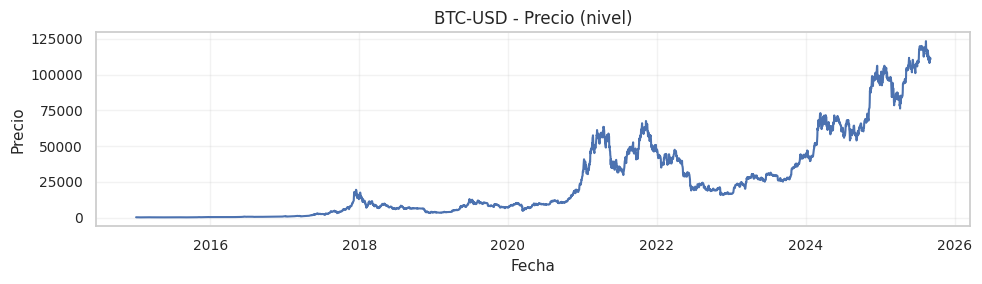

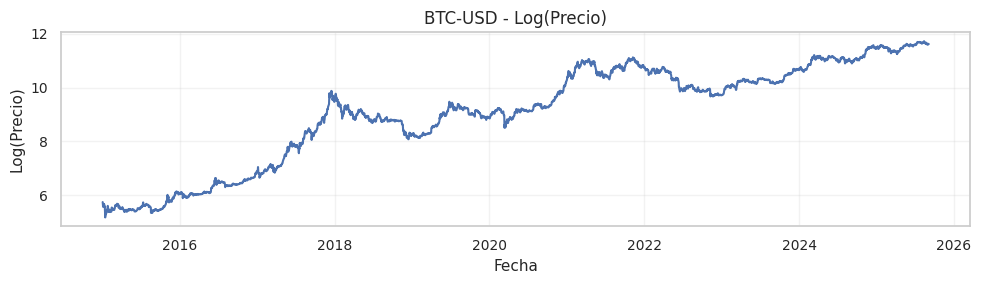

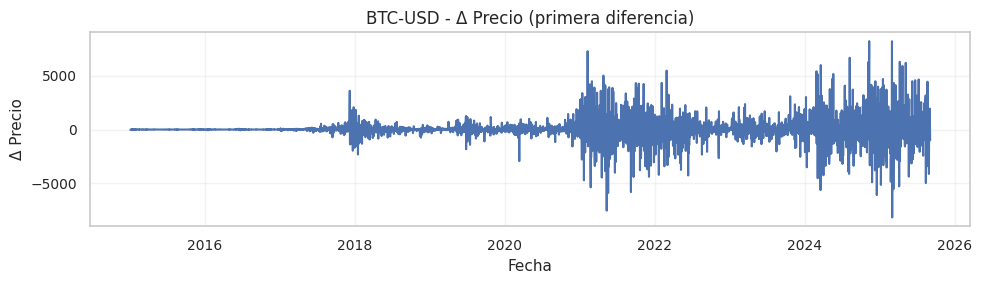

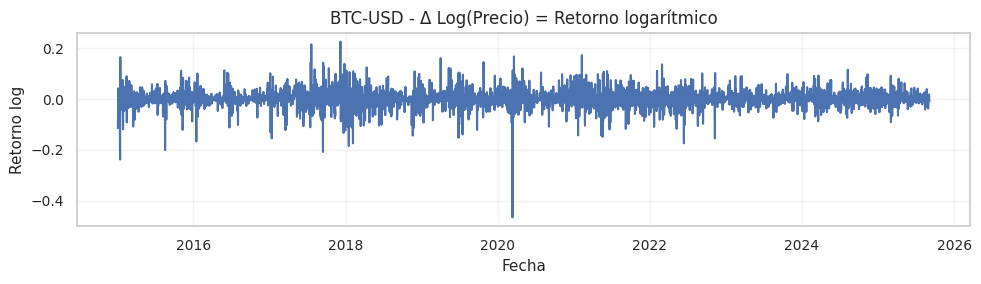

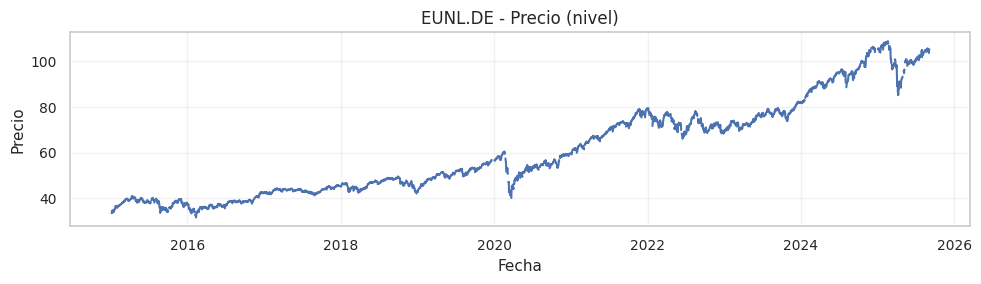

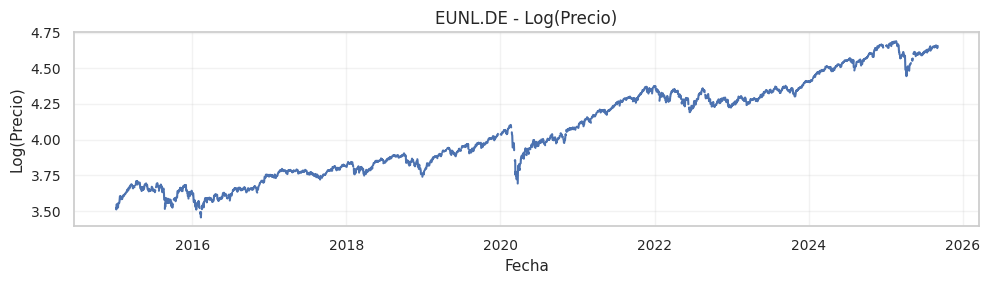

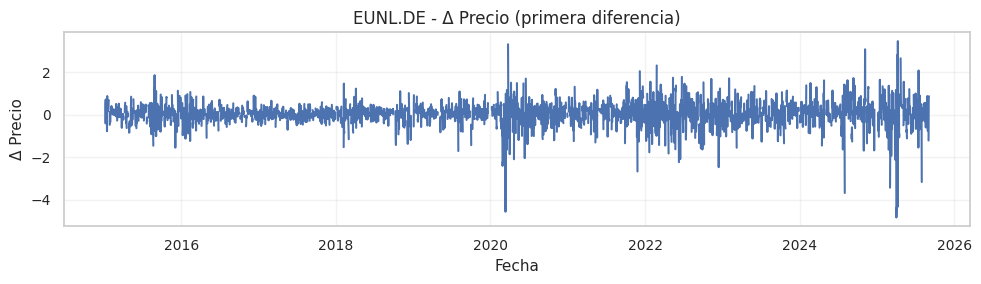

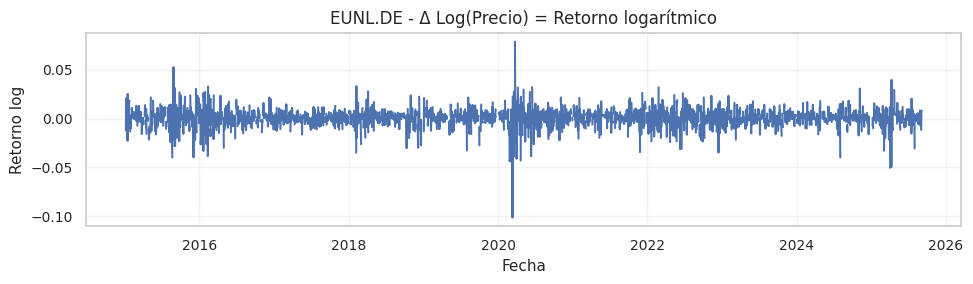

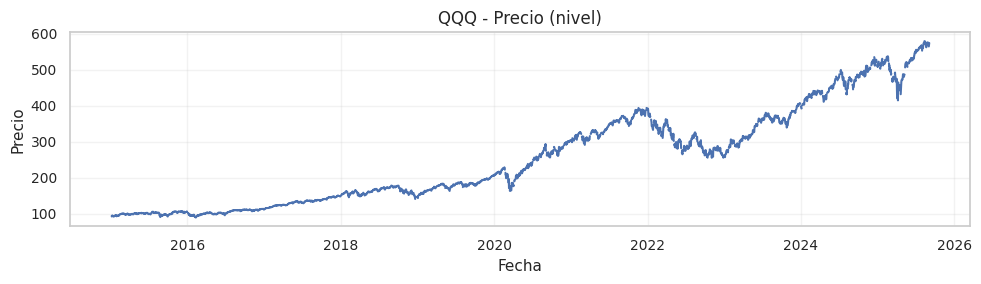

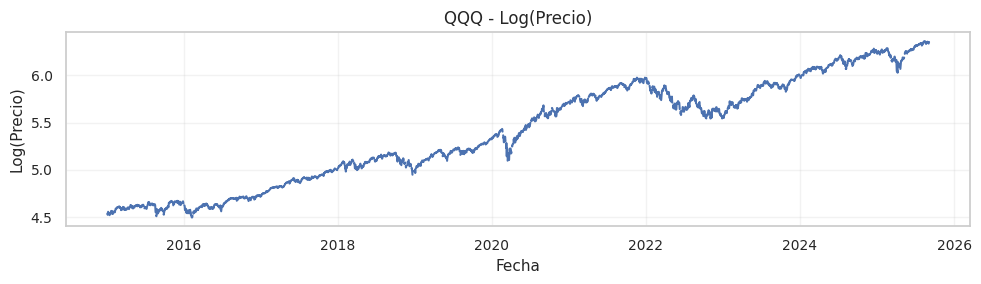

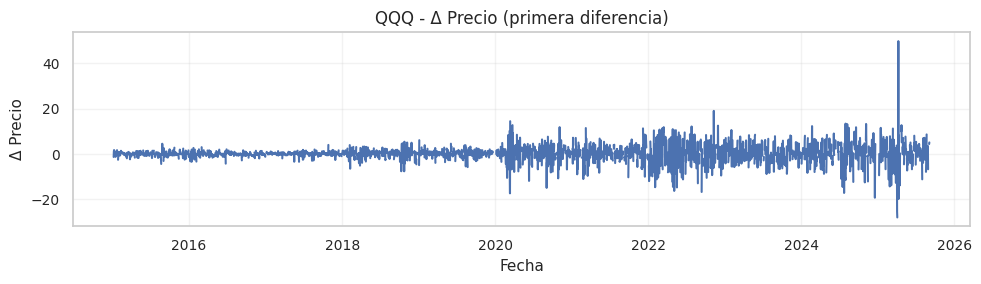

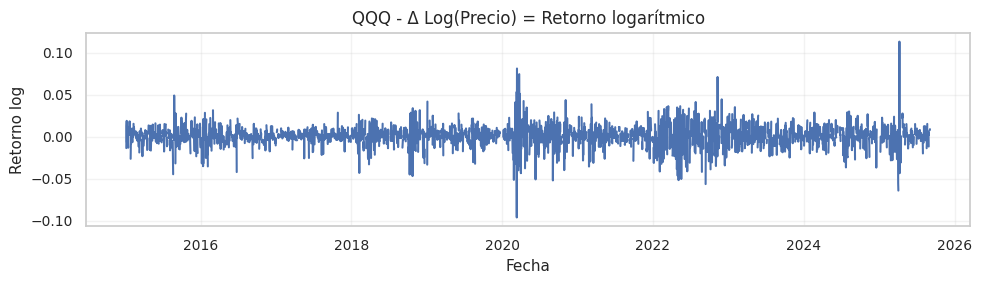

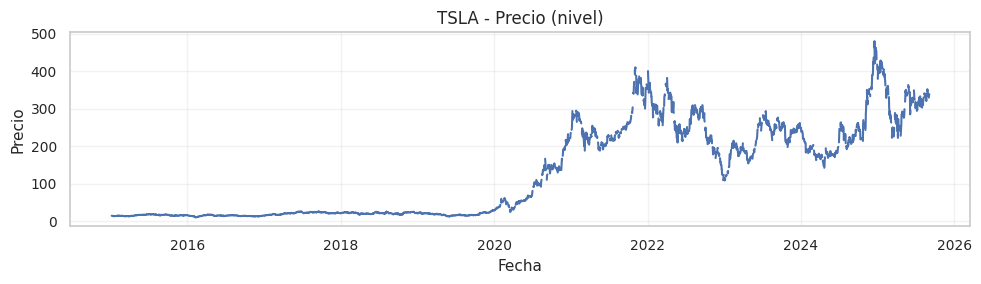

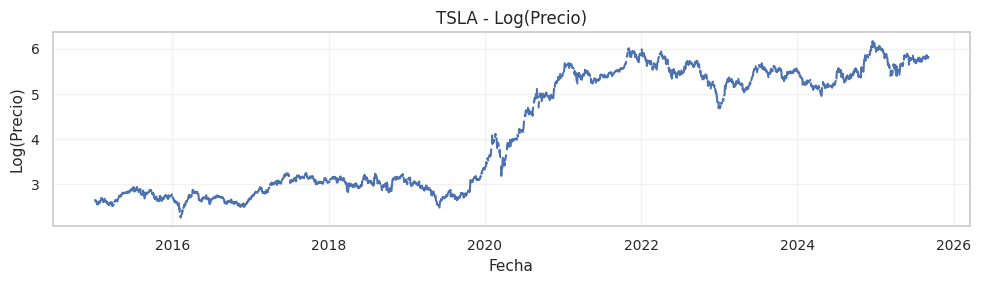

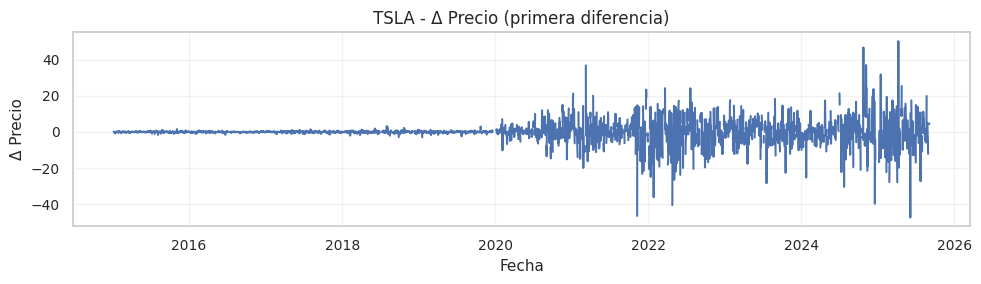

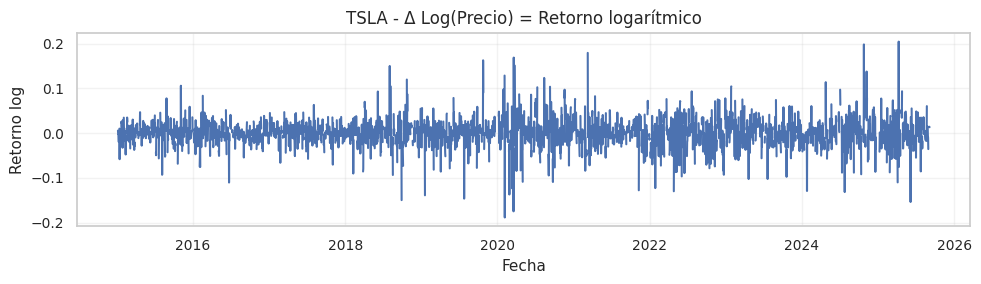

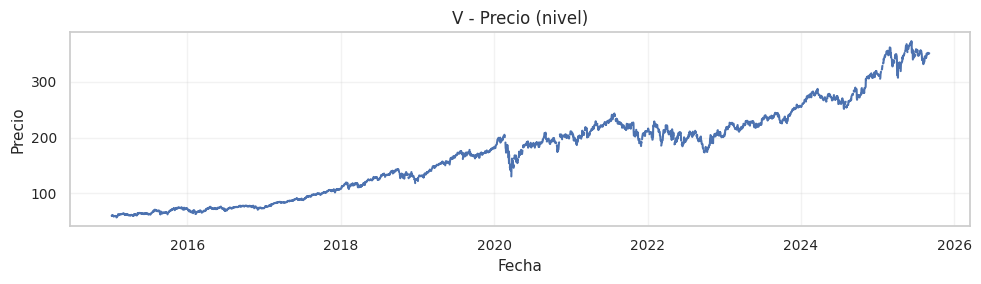

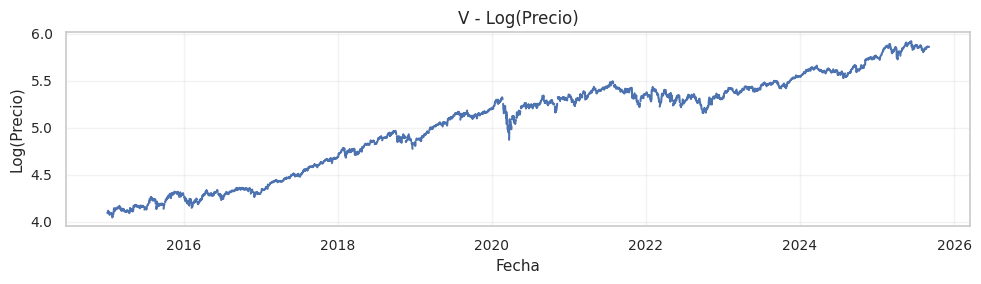

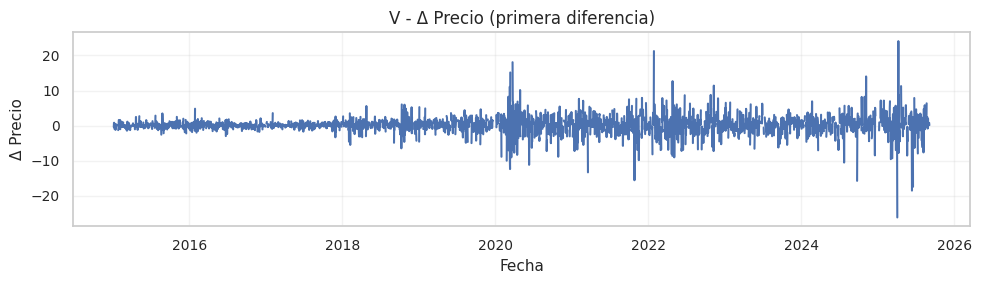

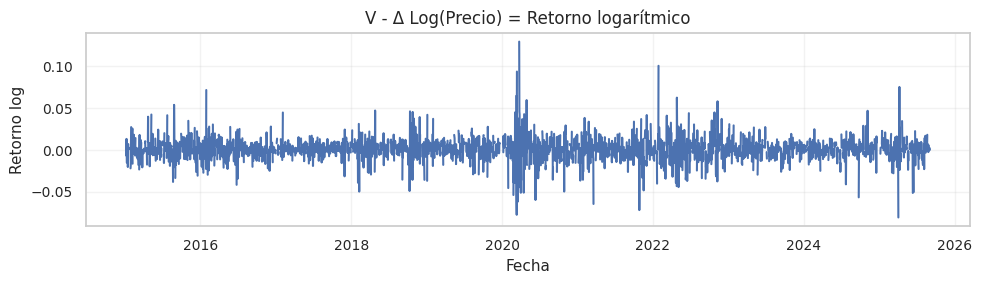

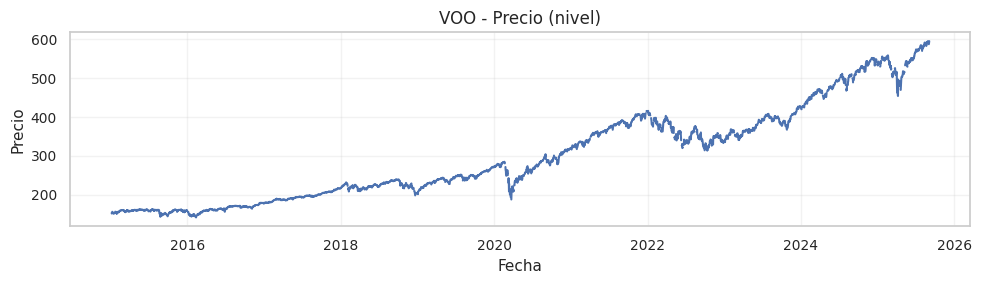

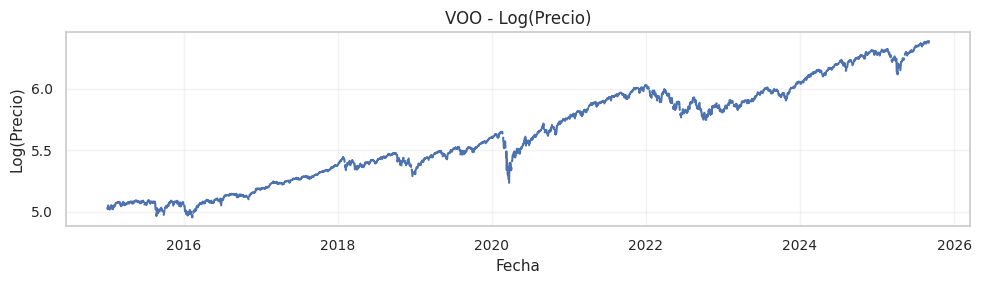

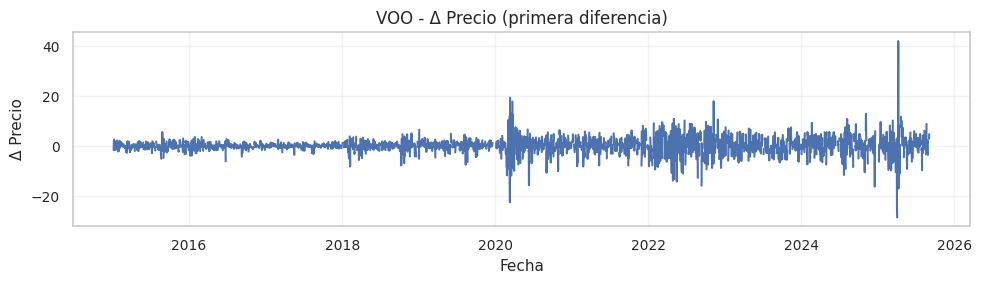

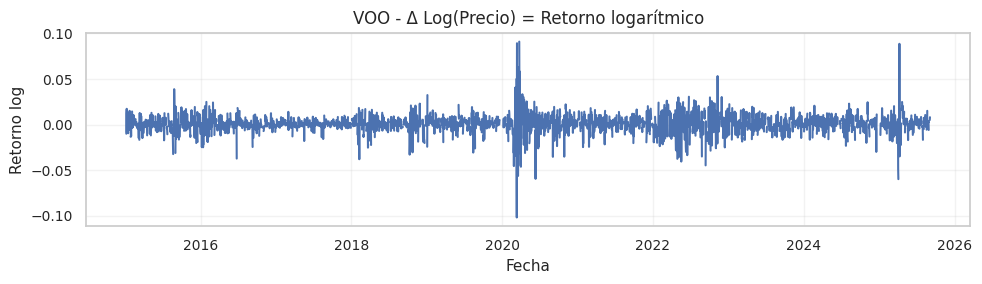


Listo ✅ Transformaciones generadas:
- log_prices  -> Logaritmo de precios
- diff_close  -> Diferencia de primer orden de precios
- log_diff    -> Diferencia logarítmica (retornos log)


In [36]:
# ===================== Transformaciones (log, diff, log+diff) + Gráficas =====================


# -------------------------------------------------------------------
# (A) Autodetección del DataFrame de precios (puedes reemplazarlo por: prices = tu_df)
# -------------------------------------------------------------------
def _pick_prices_df(ns: dict) -> pd.DataFrame | None:
    preferred = [
        "prices","prices_df","df_prices","df_precios","precios",
        "close","close_df","df_close","panel_prices","panel","data","df"
    ]
    cands = []
    for k, v in ns.items():
        if isinstance(v, pd.DataFrame) and not v.empty:
            cands.append((k, v))
    if not cands:
        return None
    # prioriza nombres conocidos
    def _score(name, df):
        s = 0
        if name.lower() in preferred: s += 2
        if isinstance(df.columns, pd.MultiIndex): s += 1
        if df.shape[0] >= 200: s += 2
        if df.shape[1] >= 3: s += 1
        return s
    cands.sort(key=lambda kv: _score(kv[0], kv[1]), reverse=True)

    for name, df in cands:
        cand = df.copy()
        # Si es MultiIndex, intenta extraer 'Close' o el último nivel
        if isinstance(cand.columns, pd.MultiIndex):
            last = cand.columns.get_level_values(-1)
            low = [str(x).lower() for x in last]
            if "close" in low:
                cand = cand.xs("Close", axis=1, level=-1)
            elif "adj close" in low:
                cand = cand.xs("Adj Close", axis=1, level=-1)
            else:
                cand = cand.droplevel(list(range(cand.columns.nlevels-1)), axis=1)
        # Asegura índice datetime y columnas numéricas
        if not np.issubdtype(cand.index.dtype, np.datetime64):
            try:
                cand.index = pd.to_datetime(cand.index, errors="coerce")
            except Exception:
                continue
        cand = cand[~cand.index.isna()]
        cand = cand.select_dtypes(include=[np.number]).dropna(axis=1, how="all")
        if cand.shape[0] >= 100 and cand.shape[1] >= 1:
            return cand.sort_index()
    return None

_ns = {k: v for k, v in globals().items() if not isinstance(v, ModuleType)}
prices = _pick_prices_df(_ns)
if prices is None:
    raise ValueError("No encontré un DataFrame de precios. Asigna manualmente: prices = <tu_df>")

# Ordena y limpia
prices = prices.sort_index()
if not np.issubdtype(prices.index.dtype, np.datetime64):
    prices.index = pd.to_datetime(prices.index, errors="coerce")
prices = prices[~prices.index.isna()]
prices = prices.select_dtypes(include=[np.number]).dropna(axis=1, how="all")

print("=== Diagnóstico precios detectados ===")
print(f"Forma: {prices.shape} | Rango: {prices.index.min()} → {prices.index.max()}")
print(f"Tickers (hasta 10): {list(prices.columns[:10])}")

# -------------------------------------------------------------------
# (B) Transformaciones
# -------------------------------------------------------------------
# 1) Logaritmo
log_prices = np.log(prices.replace({0: np.nan}))

# 2) Diferencia simple de precios
diff_close = prices.diff()

# 3) Diferencia logarítmica (retornos log) = diff(log(precio))
log_diff = log_prices.diff()

# Limpia primeras filas NaN por las diferencias
diff_close = diff_close.dropna(how="all")
log_diff = log_diff.dropna(how="all")

# -------------------------------------------------------------------
# (C) Gráficas comparativas por ticker
#     - Una figura por gráfico (requisito)
#     - Sin estilos ni colores específicos
# -------------------------------------------------------------------
# Selecciona un subconjunto de tickers para visualizar (o comenta esta línea para todos)
tickers_to_plot = list(prices.columns[:6])  # ajusta el número a gusto

for col in tickers_to_plot:
    # Serie original
    plt.figure(figsize=(10, 3))
    plt.plot(prices.index, prices[col])
    plt.title(f"{col} - Precio (nivel)")
    plt.xlabel("Fecha")
    plt.ylabel("Precio")
    plt.tight_layout()
    plt.show()

    # Logaritmo
    if col in log_prices.columns:
        plt.figure(figsize=(10, 3))
        plt.plot(log_prices.index, log_prices[col])
        plt.title(f"{col} - Log(Precio)")
        plt.xlabel("Fecha")
        plt.ylabel("Log(Precio)")
        plt.tight_layout()
        plt.show()

    # Diferencia simple
    if col in diff_close.columns:
        plt.figure(figsize=(10, 3))
        plt.plot(diff_close.index, diff_close[col])
        plt.title(f"{col} - Δ Precio (primera diferencia)")
        plt.xlabel("Fecha")
        plt.ylabel("Δ Precio")
        plt.tight_layout()
        plt.show()

    # Diferencia logarítmica (retornos log)
    if col in log_diff.columns:
        plt.figure(figsize=(10, 3))
        plt.plot(log_diff.index, log_diff[col])
        plt.title(f"{col} - Δ Log(Precio) = Retorno logarítmico")
        plt.xlabel("Fecha")
        plt.ylabel("Retorno log")
        plt.tight_layout()
        plt.show()

print("\nListo ✅ Transformaciones generadas:")
print("- log_prices  -> Logaritmo de precios")
print("- diff_close  -> Diferencia de primer orden de precios")
print("- log_diff    -> Diferencia logarítmica (retornos log)")
# ==============================================================================================


In [37]:
# ===================== Verificación ADF antes y después de transformaciones =====================

# -------------------------------------------------------------------
# Función robusta para calcular el p-value del test ADF
# -------------------------------------------------------------------
def adf_pvalue(series, autolag='AIC'):
    s = pd.Series(series).dropna()
    if s.size < 20:
        return np.nan
    try:
        return float(adfuller(s.values, autolag=autolag)[1])  # p-value
    except Exception:
        return np.nan

# -------------------------------------------------------------------
# Evaluación ADF: precios originales, diff y log_diff
# -------------------------------------------------------------------
print("=== Evaluando estacionariedad con prueba ADF ===")

p_close = prices.apply(adf_pvalue)
p_diff_close = diff_close.apply(adf_pvalue)
p_log_diff = log_diff.apply(adf_pvalue)

adf_results = pd.DataFrame({
    'p_close': p_close,
    'p_diff_close': p_diff_close,
    'p_log_diff': p_log_diff
})

# -------------------------------------------------------------------
# Clasificación según nivel de estacionariedad
# -------------------------------------------------------------------
ALPHA = 0.05

def interpretar(row):
    p1, p2, p3 = row['p_close'], row['p_diff_close'], row['p_log_diff']

    if pd.notna(p1) and p1 < ALPHA:
        return "Estacionaria sin transformación"
    elif (pd.notna(p2) and p2 < ALPHA) and (pd.notna(p3) and p3 < ALPHA):
        return "Ambas transformaciones logran estacionariedad"
    elif pd.notna(p2) and p2 < ALPHA:
        return "Estacionaria con diferencia simple"
    elif pd.notna(p3) and p3 < ALPHA:
        return "Estacionaria con diferencia logarítmica"
    else:
        return "No estacionaria (requiere más transformaciones)"

adf_results['interpretación'] = adf_results.apply(interpretar, axis=1)

# -------------------------------------------------------------------
# Presentación de resultados
# -------------------------------------------------------------------
print("\n=== Resumen Prueba ADF ===")
try:
    display(adf_results.style.format({
        'p_close': '{:.3e}',
        'p_diff_close': '{:.3e}',
        'p_log_diff': '{:.3e}'
    }).background_gradient(subset=['p_close','p_diff_close','p_log_diff'], cmap='Blues'))
except Exception:
    print(adf_results)

# -------------------------------------------------------------------
# Guardado opcional de resultados
# -------------------------------------------------------------------
adf_results.to_csv('adf_transformaciones_resumen.csv')

# -------------------------------------------------------------------
# Identificación rápida de series estacionarias
# -------------------------------------------------------------------
estacionarias_con_diff = [col for col, row in adf_results.iterrows() if row['interpretación'] == 'Estacionaria con diferencia simple']
estacionarias_con_log = [col for col, row in adf_results.iterrows() if row['interpretación'] == 'Estacionaria con diferencia logarítmica']

print("\n✅ Series estacionarias con diferencia simple:", estacionarias_con_diff)
print("✅ Series estacionarias con diferencia logarítmica:", estacionarias_con_log)
# ===============================================================================================


=== Evaluando estacionariedad con prueba ADF ===

=== Resumen Prueba ADF ===



✅ Series estacionarias con diferencia simple: []
✅ Series estacionarias con diferencia logarítmica: []


=== ACF/PACF sobre Δ log(precio) (retornos log) ===


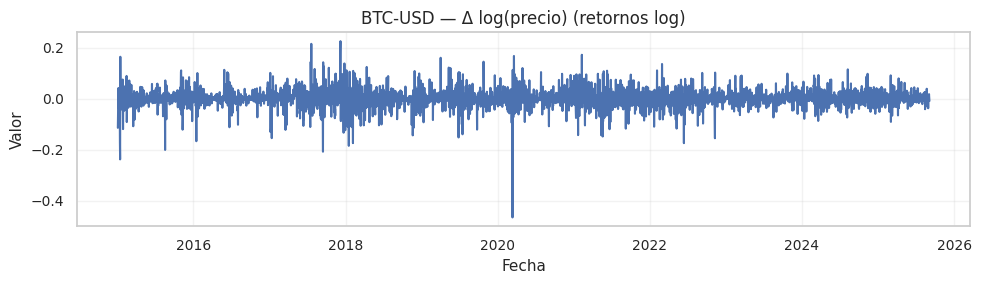

<Figure size 1000x300 with 0 Axes>

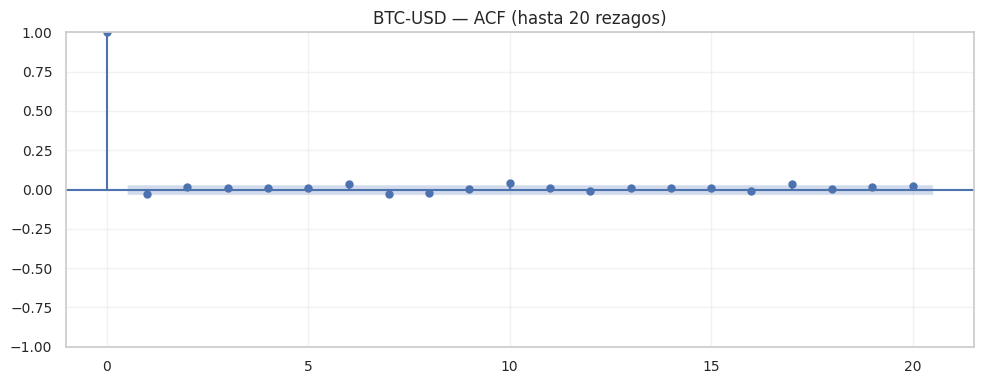

<Figure size 1000x300 with 0 Axes>

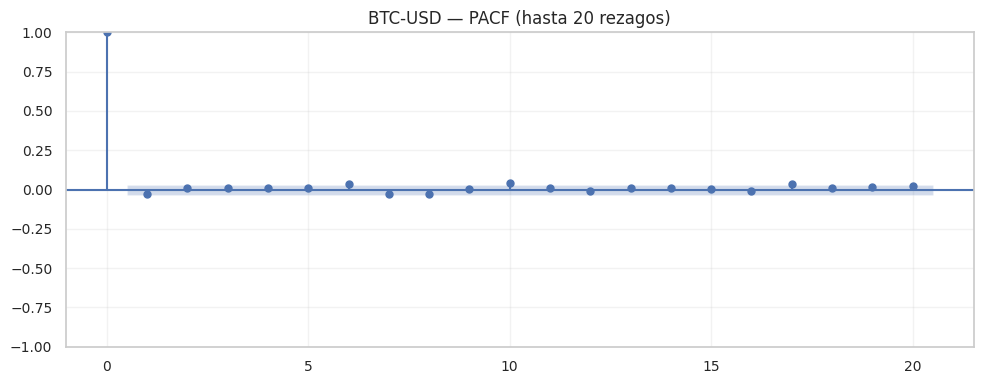

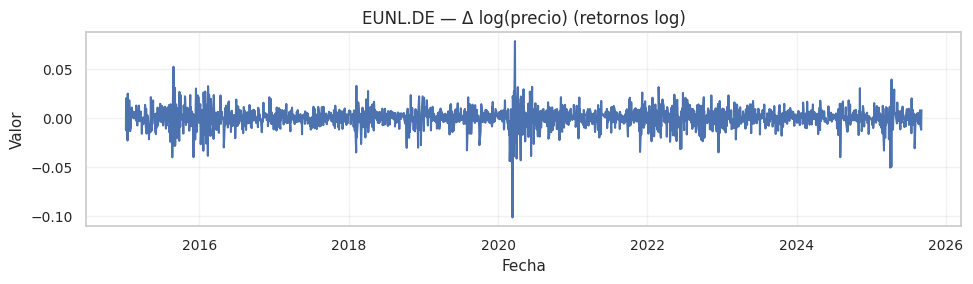

<Figure size 1000x300 with 0 Axes>

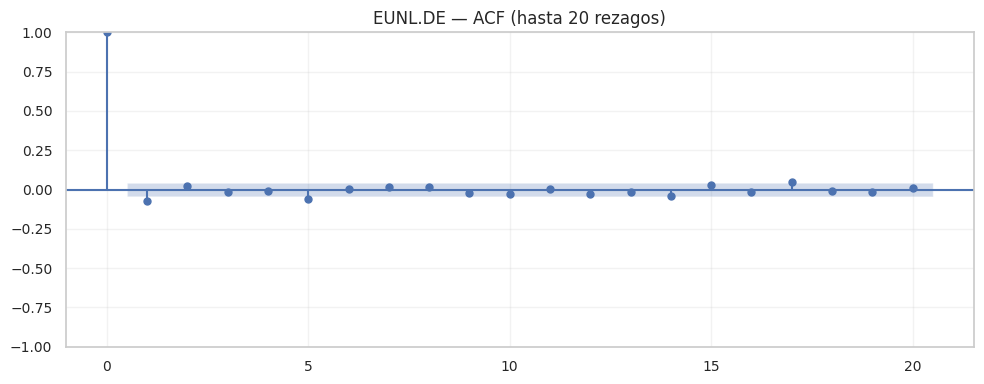

<Figure size 1000x300 with 0 Axes>

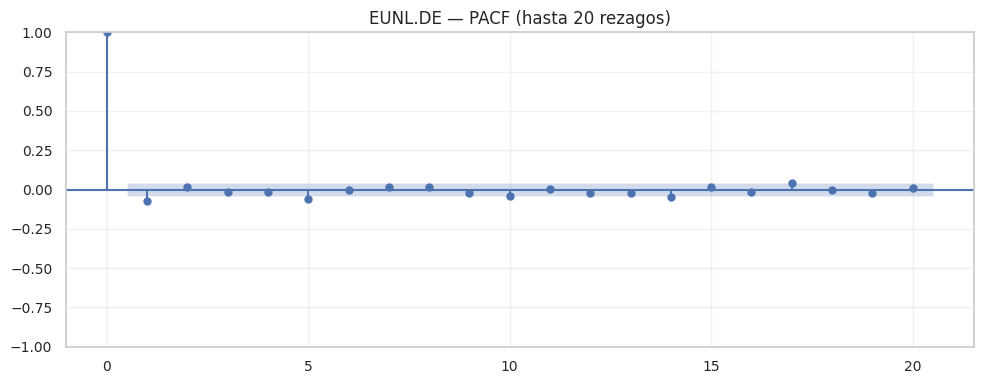

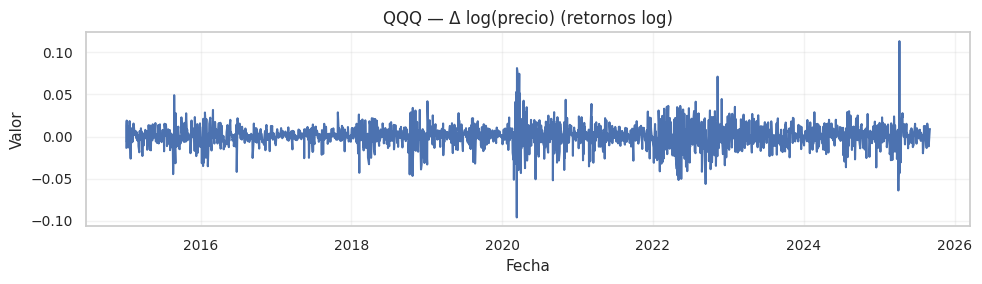

<Figure size 1000x300 with 0 Axes>

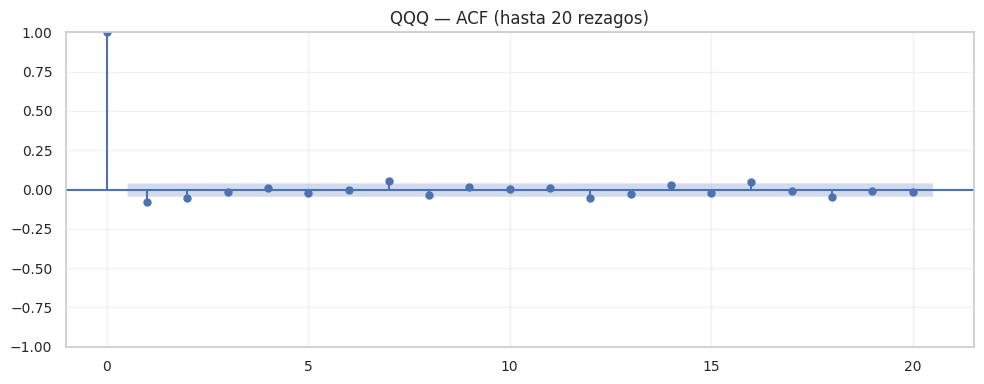

<Figure size 1000x300 with 0 Axes>

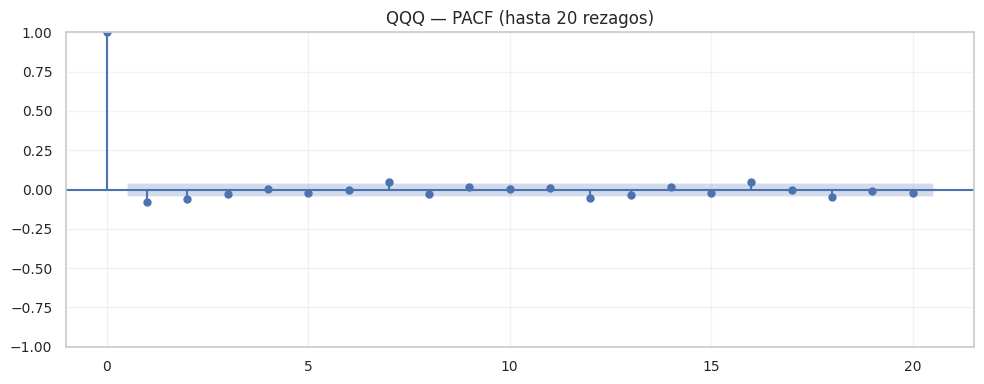

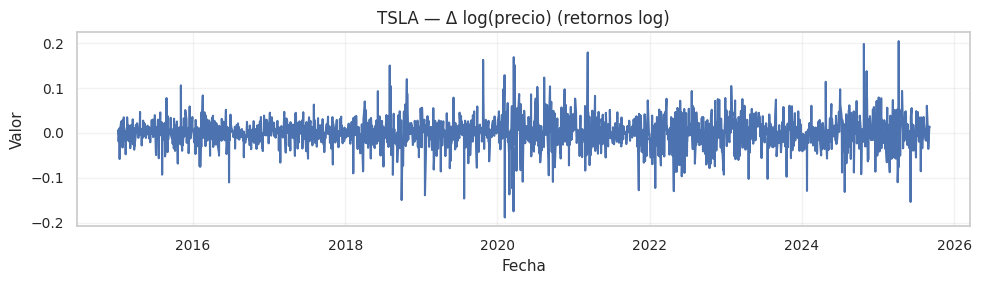

<Figure size 1000x300 with 0 Axes>

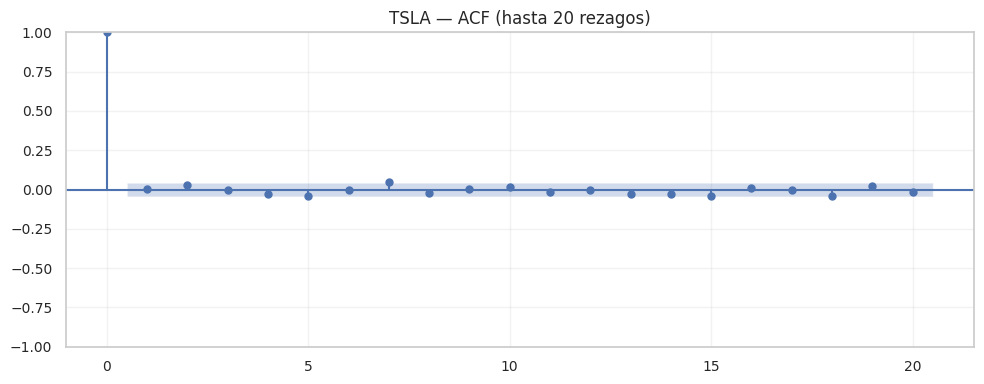

<Figure size 1000x300 with 0 Axes>

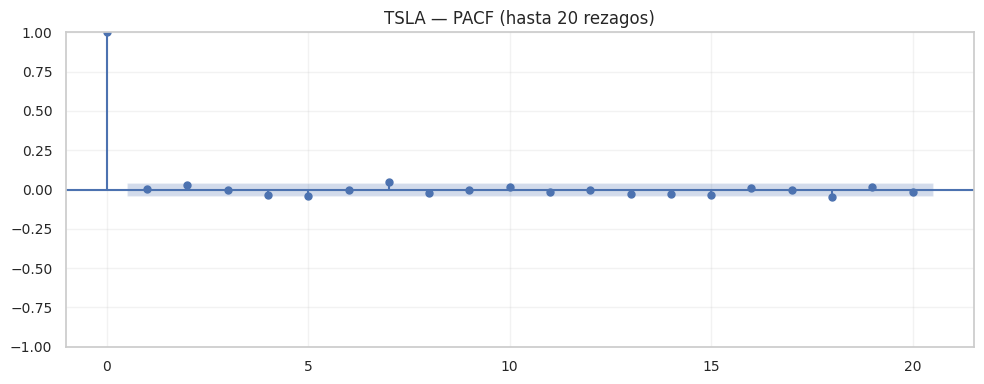

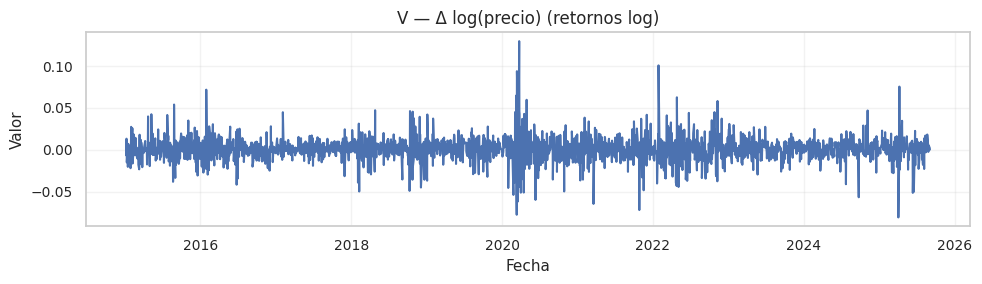

<Figure size 1000x300 with 0 Axes>

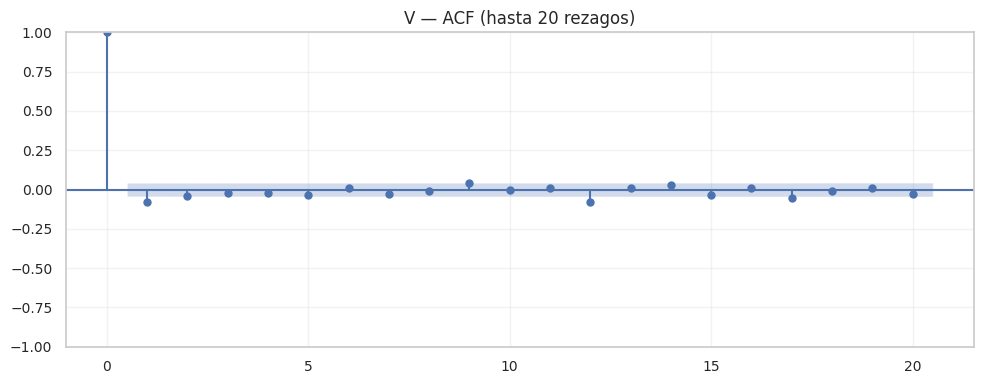

<Figure size 1000x300 with 0 Axes>

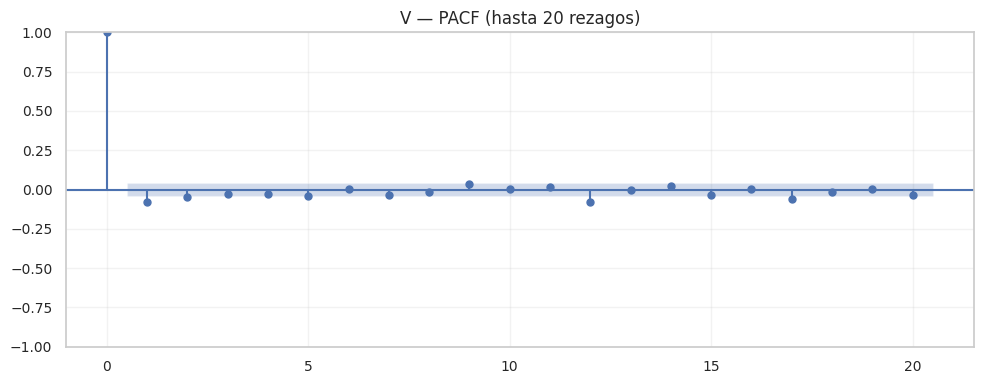

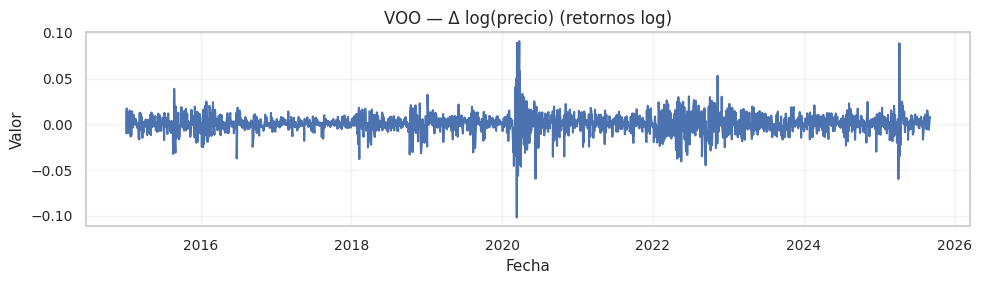

<Figure size 1000x300 with 0 Axes>

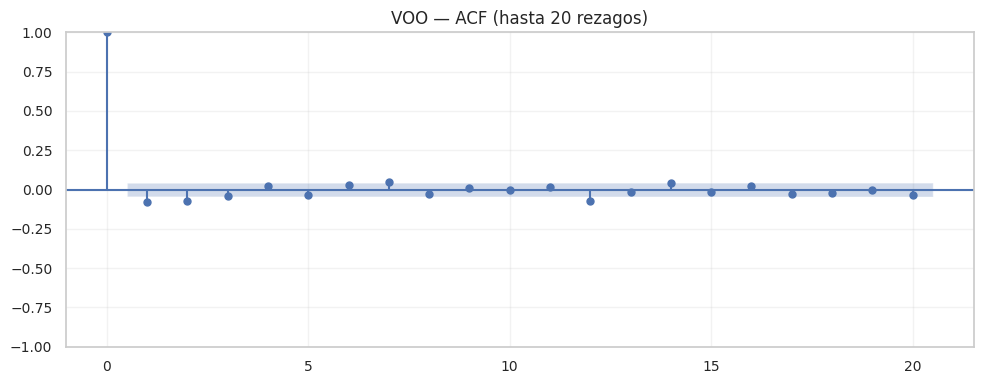

<Figure size 1000x300 with 0 Axes>

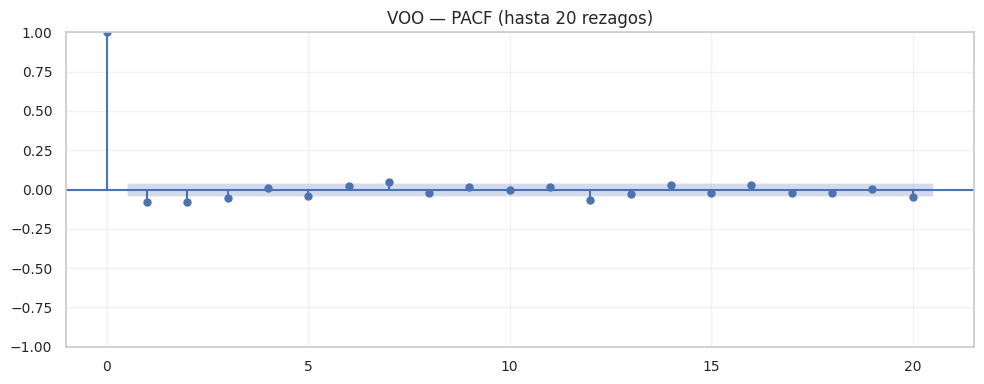


=== Sugerencias de órdenes (p, q) para ARIMA ===


p_sugerido  q_sugerido ARIMA_sobre_nivel  \
ticker                                              
BTC-USD           1           1      ARIMA(1,1,1)   
EUNL.DE           1           1      ARIMA(1,1,1)   
QQQ               1           1      ARIMA(1,1,1)   
TSLA              1           1      ARIMA(1,1,1)   
V                 1           1      ARIMA(1,1,1)   
VOO               1           1      ARIMA(1,1,1)   

                                                  nota  
ticker                                                  
BTC-USD  Patrón poco definido → usar (1,1) como inicio  
EUNL.DE  Patrón poco definido → usar (1,1) como inicio  
QQQ      Patrón poco definido → usar (1,1) como inicio  
TSLA     Patrón poco definido → usar (1,1) como inicio  
V        Patrón poco definido → usar (1,1) como inicio  
VOO      Patrón poco definido → usar (1,1) como inicio

In [38]:
# ===================== ACF & PACF + sugerencias (p, q) para ARIMA =====================


# -------------------------------------------------------------------
# 1) Selección de la serie estacionaria para ARIMA
#     - Preferimos log_diff (retornos log) si existe; sino, diff_close
# -------------------------------------------------------------------
if 'log_diff' in globals() and isinstance(log_diff, pd.DataFrame) and not log_diff.empty:
    target_df = log_diff.copy()
    d_assumed = 1  # ya hicimos una diferencia (en log)
    transform_tag = "Δ log(precio) (retornos log)"
elif 'diff_close' in globals() and isinstance(diff_close, pd.DataFrame) and not diff_close.empty:
    target_df = diff_close.copy()
    d_assumed = 1  # ya hicimos una diferencia
    transform_tag = "Δ precio (primera diferencia)"
else:
    raise ValueError("No encuentro 'log_diff' ni 'diff_close'. Ejecuta primero el bloque de transformaciones.")

# Opción: limitar el set de tickers a graficar
tickers_to_plot = list(target_df.columns[:6])  # ajusta el número según prefieras

# -------------------------------------------------------------------
# 2) Funciones auxiliares para sugerir p y q según ACF/PACF
# -------------------------------------------------------------------
def _first_cutoff_lag(vals, conf_low, conf_high):
    """
    Devuelve el primer rezago k>=1 donde la correlación 'sale' del intervalo de confianza.
    Si no encuentra corte claro, devuelve 0.
    """
    for k in range(1, len(vals)):
        if (vals[k] < conf_low[k]) or (vals[k] > conf_high[k]):
            return k
    return 0

def _tailing(vals, conf_low, conf_high, max_k=20, thresh_frac=0.25):
    """
    Heurística: considera 'tailing' cuando más de 'thresh_frac' de los primeros max_k
    rezagos son significativos (fuera del intervalo).
    """
    K = min(max_k, len(vals)-1)
    sig = 0
    for k in range(1, K+1):
        if (vals[k] < conf_low[k]) or (vals[k] > conf_high[k]):
            sig += 1
    return (sig / max(1, K)) >= thresh_frac

def suggest_pq(series, nlags=20, alpha=0.05):
    """
    Sugerencia heurística de (p, q) a partir de ACF y PACF:
      - Si PACF 'corta' en k y ACF 'tailing' -> AR(k), q=0
      - Si ACF 'corta' en k y PACF 'tailing' -> MA(k), p=0
      - Si ambos cortan -> ARMA(p,q) pequeños (elige (1,1) como inicio)
      - Si ambos 'tailing' -> quizá requiere más diferenciación/estacionalidad
    """
    s = pd.Series(series).dropna()
    if s.size < 50:
        return {"p": 0, "q": 0, "note": "serie muy corta para sugerir"}

    # ACF y PACF con bandas de confianza
    acf_vals, acf_conf = sm_acf(s, nlags=nlags, alpha=alpha, fft=True)
    pacf_vals, pacf_conf = sm_pacf(s, nlags=nlags, alpha=alpha, method='ywm')

    acf_low, acf_high = acf_conf[:,0], acf_conf[:,1]
    pacf_low, pacf_high = pacf_conf[:,0], pacf_conf[:,1]

    # cortes iniciales
    cut_acf = _first_cutoff_lag(acf_vals, acf_low, acf_high)
    cut_pacf = _first_cutoff_lag(pacf_vals, pacf_low, pacf_high)

    # caídas/tails
    tail_acf = _tailing(acf_vals, acf_low, acf_high, max_k=nlags)
    tail_pacf = _tailing(pacf_vals, pacf_low, pacf_high, max_k=nlags)

    note = []
    if cut_pacf > 0 and tail_acf:
        # AR puro
        return {"p": cut_pacf, "q": 0, "note": "PACF corta, ACF tailing → AR(p)"}
    if cut_acf > 0 and tail_pacf:
        # MA puro
        return {"p": 0, "q": cut_acf, "note": "ACF corta, PACF tailing → MA(q)"}
    if cut_pacf > 0 and cut_acf > 0:
        note.append("ACF y PACF cortan → ARMA pequeño")
        p = min(cut_pacf, 3)
        q = min(cut_acf, 3)
        return {"p": p, "q": q, "note": "; ".join(note)}
    if tail_acf and tail_pacf:
        return {"p": 1, "q": 1, "note": "Ambos tailing → revisar d/estacionalidad; sugerir (1,1) como inicio"}
    # Si nada claro, punto de partida básico
    return {"p": 1, "q": 1, "note": "Patrón poco definido → usar (1,1) como inicio"}

# -------------------------------------------------------------------
# 3) Gráficas ACF/PACF y tabla de sugerencias
# -------------------------------------------------------------------
nlags = 20
sugerencias = []

print(f"=== ACF/PACF sobre {transform_tag} ===")
for col in tickers_to_plot:
    s = target_df[col].dropna()

    # Serie (para ver estacionariedad visual)
    plt.figure(figsize=(10, 3))
    plt.plot(s.index, s.values)
    plt.title(f"{col} — {transform_tag}")
    plt.xlabel("Fecha"); plt.ylabel("Valor")
    plt.tight_layout(); plt.show()

    # ACF
    plt.figure(figsize=(10, 3))
    plot_acf(s, lags=nlags)
    plt.title(f"{col} — ACF (hasta {nlags} rezagos)")
    plt.tight_layout(); plt.show()

    # PACF
    plt.figure(figsize=(10, 3))
    plot_pacf(s, lags=nlags, method='ywm')
    plt.title(f"{col} — PACF (hasta {nlags} rezagos)")
    plt.tight_layout(); plt.show()

    # Sugerencia p,q
    sug = suggest_pq(s, nlags=nlags, alpha=0.05)
    sugerencias.append({
        "ticker": col,
        "p_sugerido": sug["p"],
        "q_sugerido": sug["q"],
        # Nota: ya aplicamos 1 diferencia, por eso d=1 sobre el nivel original
        "ARIMA_sobre_nivel": f"ARIMA({sug['p']},1,{sug['q']})",
        "nota": sug["note"]
    })

sug_df = pd.DataFrame(sugerencias).set_index("ticker")
print("\n=== Sugerencias de órdenes (p, q) para ARIMA ===")
try:
    display(sug_df)
except Exception:
    print(sug_df)

# Guardar a CSV (opcional)
sug_df.to_csv("sugerencias_arima_acf_pacf.csv")
# ==============================================================================================


<!-- Implementación y validación de modelos predictivos -->
<details open>
<summary><h1 style="display:inline; font-size:36px; color:#3182ce">6. Implementación y Validación de Modelos Predictivos</h1></summary>

En esta sección iniciaremos la **fase de modelado y validación** del proyecto <strong>EduFinance – Simulator</strong>, donde aplicaremos diferentes enfoques estadísticos y de aprendizaje profundo para predecir el comportamiento futuro de los activos financieros seleccionados.

####El objetivo principal es <strong>evaluar y comparar la capacidad predictiva</strong> de tres familias de modelos:

1. <strong>ARIMA (AutoRegressive Integrated Moving Average):</strong>  
   Modelo estadístico clásico que permite capturar dependencias lineales en series temporales estacionarias.  
   Se aplicará para predecir precios o log-precios transformados de cada activo y evaluar su desempeño mediante las métricas <em>AIC</em>, <em>BIC</em>, <em>RMSE</em> y <em>MAPE</em>.

2. <strong>GARCH (Generalized AutoRegressive Conditional Heteroskedasticity):</strong>  
   Modelo especializado en estimar la <strong>volatilidad condicional</strong> de los rendimientos financieros, útil para medir riesgo y fluctuaciones en el tiempo.  
   Se implementará opcionalmente sobre los rendimientos para analizar la estabilidad del mercado y la sensibilidad de los activos.

3. <strong>LSTM (Long Short-Term Memory):</strong>  
   Red neuronal recurrente capaz de capturar relaciones <strong>no lineales</strong> y dependencias de largo plazo en las series.  
   Este modelo servirá como base para la fase final del proyecto, donde se construirá una <strong>herramienta de simulación predictiva</strong>.

---

<h2 style="font-size:28px; color:#3182ce">Objetivos específicos de esta sección</h2>

1. Entrenar y validar el modelo <strong>ARIMA</strong> para cada activo del conjunto piloto.  
2. Calcular métricas de error (<em>RMSE</em> y <em>MAPE</em>) y criterios de información (<em>AIC</em> y <em>BIC</em>).  
3. Visualizar las predicciones frente a los valores reales en ventanas de validación.  
4. (Opcional) Implementar un primer <strong>modelo GARCH</strong> sobre los rendimientos para analizar la volatilidad.  
5. Preparar los datos y establecer la arquitectura inicial del <strong>modelo LSTM</strong> que será utilizado en la siguiente etapa.

---

<h2 style="font-size:28px; color:#3182ce">Metodología general</h2>

1. Dividir las series en conjuntos de <strong>entrenamiento (train)</strong> y <strong>validación (test)</strong>, reservando los últimos 30 días para evaluación.  
2. Ajustar un <strong>modelo ARIMA(1,1,1)</strong> base y evaluar su capacidad predictiva.  
3. Visualizar las predicciones de corto plazo y analizar los resultados numéricos y gráficos.  
4. Documentar los hallazgos obtenidos para cada activo antes de avanzar a modelos más complejos.  

---

<h2 style="font-size:28px; color:#3182ce">Resultados esperados</h2>

- Identificación del modelo ARIMA óptimo para cada activo según AIC y BIC.  
- Métricas de desempeño cuantitativas (RMSE, MAPE) y gráficas de validación.  
- Validación visual de los pronósticos de corto plazo (últimos 30 días).  
- Base analítica para implementar modelos LSTM y simulaciones financieras.

---

<h2 style="font-size:28px; color:#3182ce">Consideraciones</h2>

- Los modelos ARIMA se aplican sobre series transformadas (log o diferencias) previamente validadas como estacionarias.  
- Los modelos GARCH permiten analizar la <em>volatilidad agrupada</em> en los retornos, complementando el análisis de riesgo.  
- El modelo LSTM requerirá una preparación especial de los datos (normalización y secuencias de entrada).  
- Esta fase marca la transición desde el análisis exploratorio hacia el modelado predictivo, preparando el entorno para el simulador financiero final.

</details>


In [39]:
log_prices

ticker        BTC-USD   EUNL.DE       QQQ      TSLA         V       VOO  \
date                                                                      
2015-01-02   5.752674  3.533978  4.552893  2.682436  4.118427  5.050869   
2015-01-03   5.638646       NaN       NaN       NaN       NaN       NaN   
2015-01-04   5.576687       NaN       NaN       NaN       NaN       NaN   
2015-01-05   5.614857  3.524594  4.538115  2.639486  4.096106  5.033144   
2015-01-06   5.656652  3.512441  4.524616  2.645134  4.089641  5.023262   
...               ...       ...       ...       ...       ...       ...   
2025-08-31  11.592076       NaN       NaN       NaN       NaN       NaN   
2025-09-01  11.601400  4.652531       NaN       NaN       NaN       NaN   
2025-09-02  11.619091  4.640875  6.336764  5.797151  5.858133  6.375078   
2025-09-03  11.623780  4.648134  6.344601  5.811410  5.860416  6.380178   
2025-09-04  11.614792  4.656338  6.353611  5.824613  5.860758  6.388374   

ticker           XAR   XRP-USD  
date                            
2015-01-02  3.889795       NaN  
2015-01-03       NaN       NaN  
2015-01-04       NaN       NaN  
2015-01-05  3.873578       NaN  
2015-01-06  3.869058       NaN  
...              ...       ...  
2025-08-31       NaN  1.021242  
2025-09-01       NaN  1.012944  
2025-09-02  5.380874  1.051471  
2025-09-03  5.368767  1.045526  
2025-09-04  5.369696  1.028128  

[3899 rows x 8 columns]

VOO: train=2654, test=30
QQQ: train=2654, test=30
EUNL.DE: train=2685, test=30
XAR: train=2654, test=30
TSLA: train=2654, test=30
V: train=2654, test=30
BTC-USD: train=3869, test=30
XRP-USD: train=2827, test=30


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p


=== Resultados del modelo ARIMA(1,1,1) ===


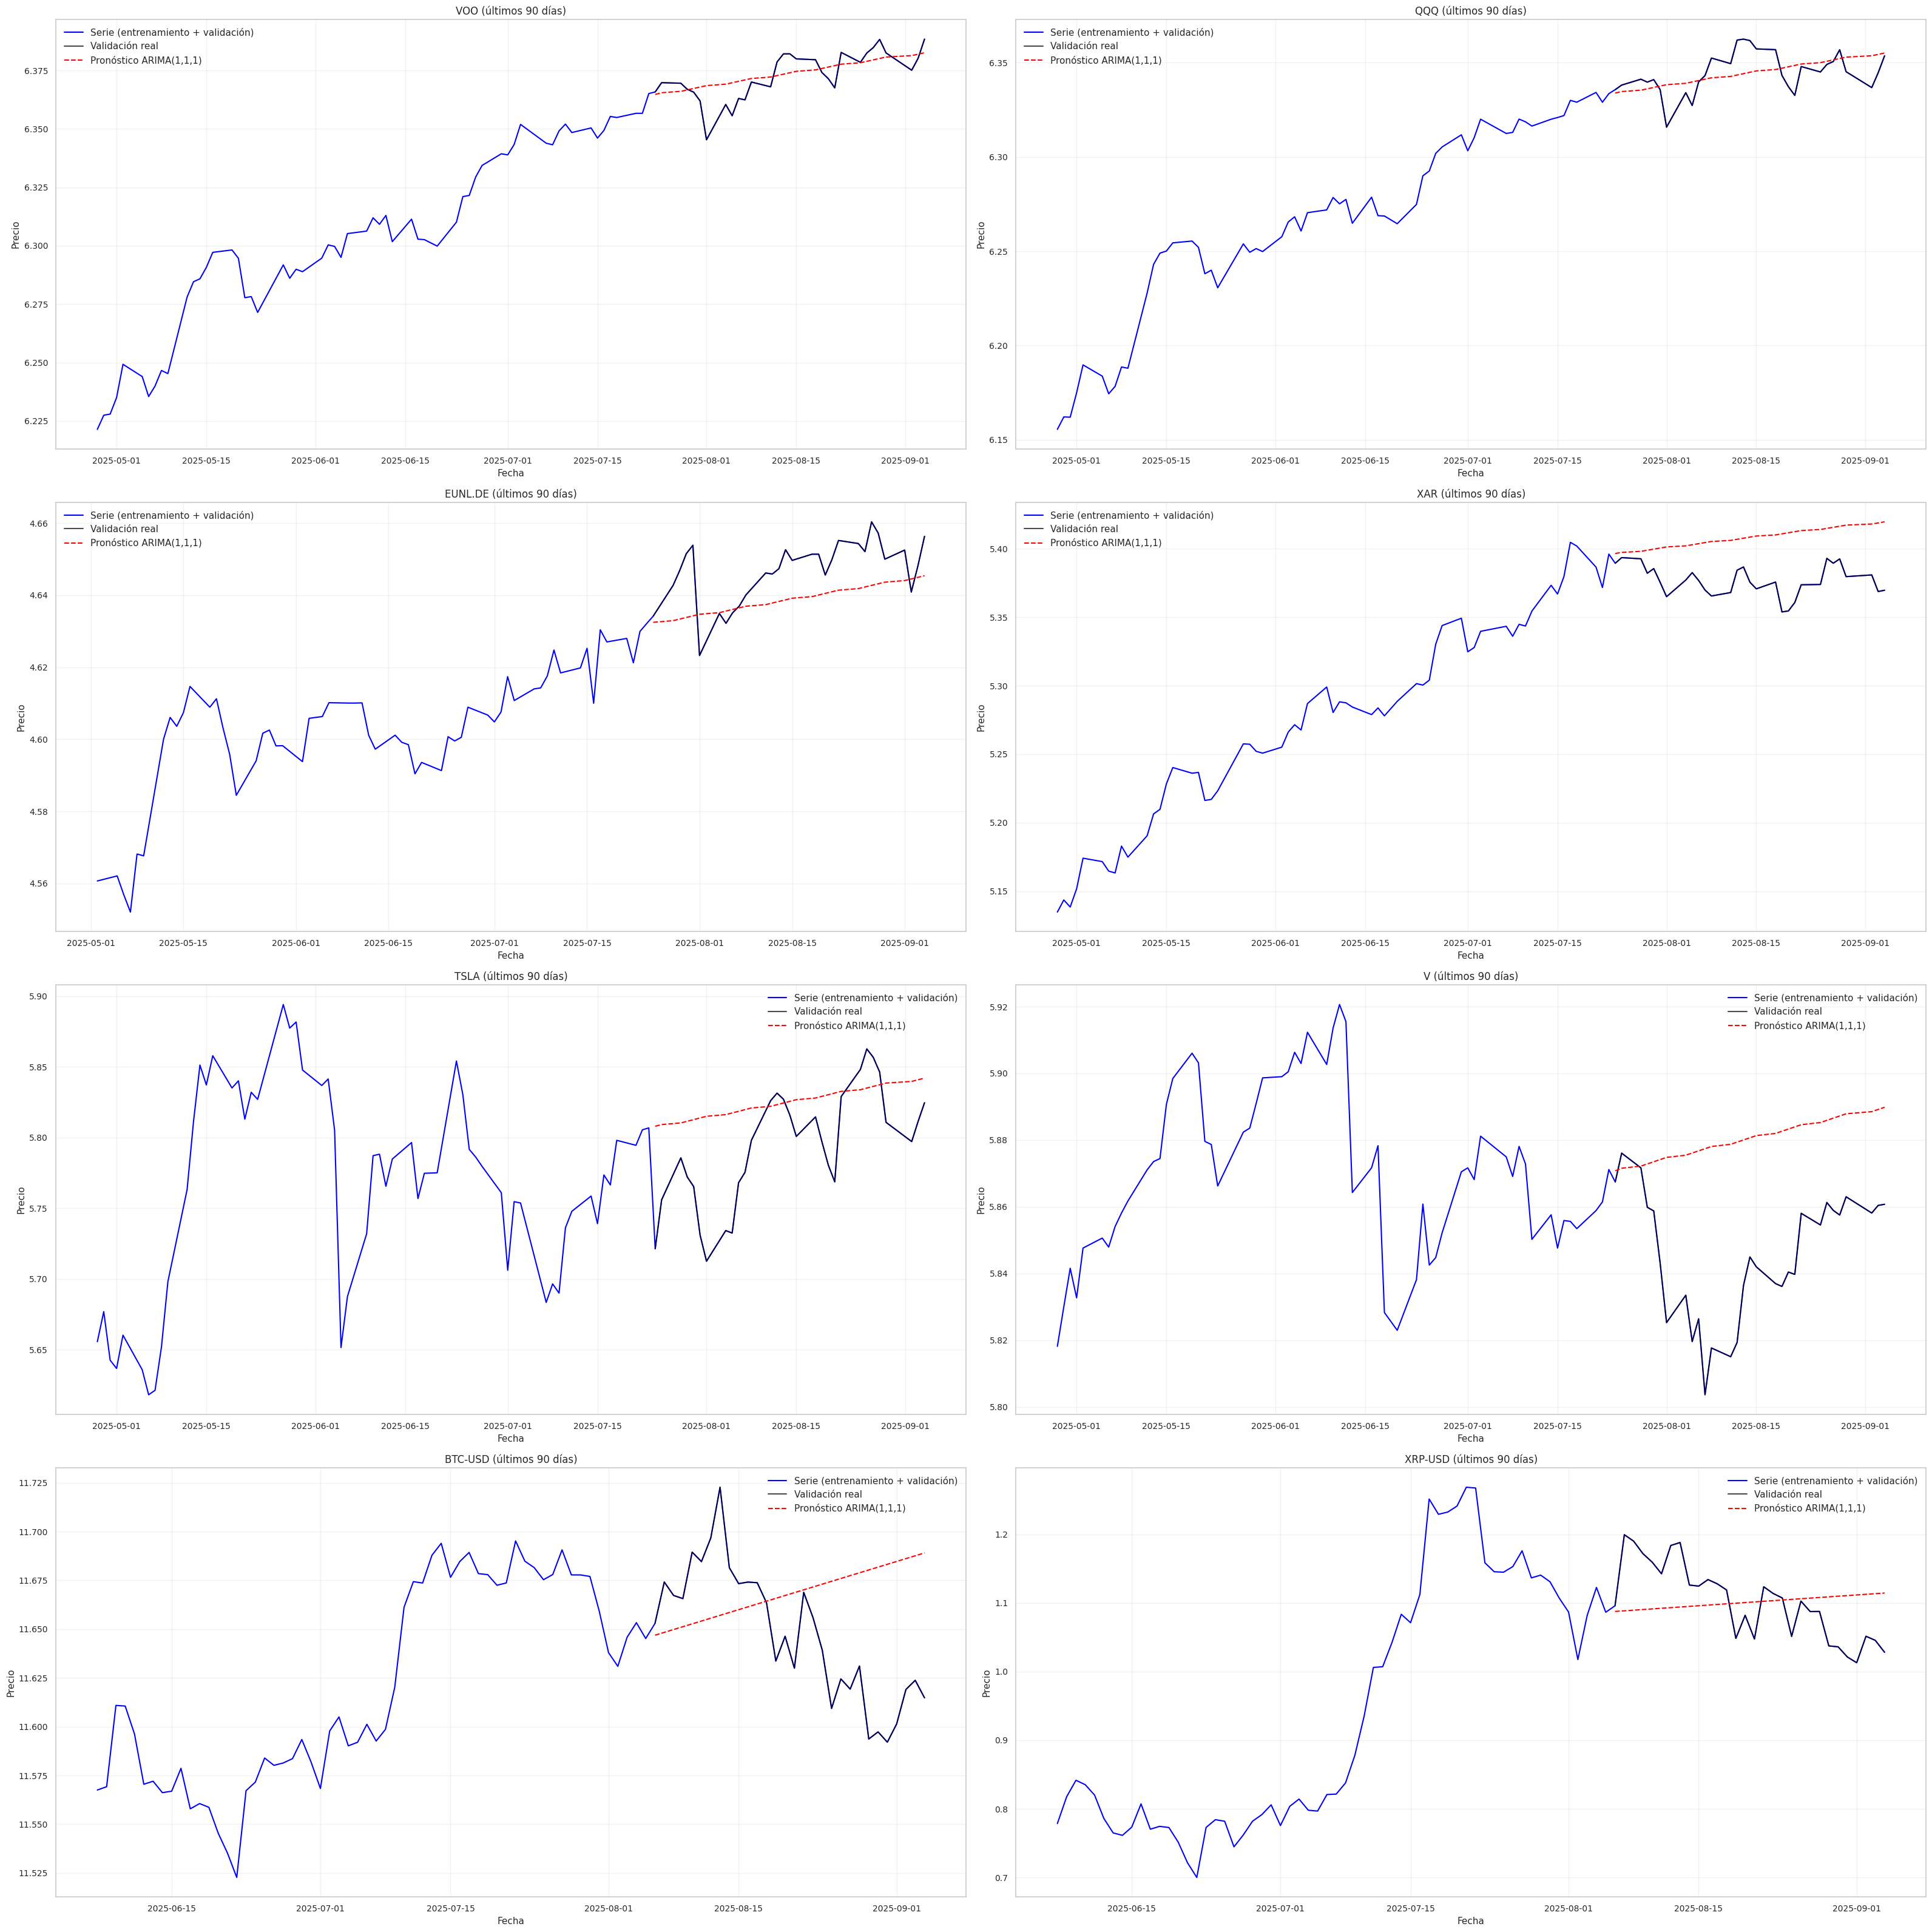

In [40]:
"""
Aplicación modelo ARIMA
"""

#Selección de parametros y división de datos

tickers = [
    "VOO",      # Vanguard S&P 500 ETF (EE. UU., 500 grandes empresas)
    "QQQ",      # Invesco Nasdaq-100 ETF (tecnología/crecimiento)
    "EUNL.DE",  # iShares MSCI World (Xetra, EUR; exposición global desarrollados)
    "XAR",      # SPDR Aerospace & Defense ETF (sector defensa)
    "TSLA",     # Tesla Inc. (vehículos eléctricos / energía)
    "V",        # Visa Inc. (pagos electrónicos)
    "BTC-USD",  # Bitcoin en USD (cripto 24/7)
    "XRP-USD"   # XRP en USD (cripto 24/7)
]
dias_validacion = 30  # cantidad de días para validar
train_data, test_data = {}, {}

for t in tickers:
    serie = log_prices[t].dropna()
    train_data[t] = serie.iloc[:-dias_validacion]  # todo menos los últimos 30
    test_data[t] = serie.iloc[-dias_validacion:]   # los últimos 30 días
    print(f"{t}: train={len(train_data[t])}, test={len(test_data[t])}")

#Entrenamiento y validacion del modelo

resultados = {}

for t in tickers:
    serie_train = train_data[t]
    serie_test = test_data[t]

    # Entrenar modelo ARIMA(1,2,1)
    modelo = ARIMA(serie_train, order=(1,2,1))
    resultado = modelo.fit()

    # Pronosticar exactamente los próximos 30 días
    pasos = len(serie_test)
    pred = resultado.forecast(steps=pasos)

    # Calculo de errores
    rmse = np.sqrt(mean_squared_error(serie_test, pred))
    mape = mean_absolute_percentage_error(serie_test, pred) * 100

    # Guardar resultados
    resultados[t] = {
        "AIC": resultado.aic,
        "BIC": resultado.bic,
        "RMSE": rmse,
        "MAPE (%)": mape,
        "Predicciones": pred,
        "Modelo": resultado
    }

#Tabla de resultados
resumen = pd.DataFrame({
    t: {
        "AIC": resultados[t]["AIC"],
        "BIC": resultados[t]["BIC"],
        "RMSE": resultados[t]["RMSE"],
        "MAPE (%)": resultados[t]["MAPE (%)"]
    }
    for t in resultados
}).T

print("\n=== Resultados del modelo ARIMA(1,1,1) ===")
display(resumen.style.background_gradient(cmap="Blues").format(precision=4))

#Visualización por activos

# Determine the number of rows needed for subplots
n_tickers = len(tickers)
ncols = 2
nrows = (n_tickers + 1) // ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(32, 8 * nrows))
axes = axes.flatten() if n_tickers > 1 else np.array([axes]) # Ensure axes is iterable

# Remove unused subplots if any
if n_tickers < len(axes):
    for i in range(n_tickers, len(axes)):
        fig.delaxes(axes[i])


for i, t in enumerate(tickers):
    serie_train = train_data[t]
    serie_test = test_data[t]
    pred = resultados[t]["Predicciones"]

    # --- NUEVO: unir entrenamiento + validación para obtener últimos 90 días
    serie_total = pd.concat([serie_train, serie_test])
    ultimos_90 = serie_total.iloc[-90:]  # <- últimos 90 registros

    # Extraer el índice común para predicciones (últimos 30 días del test)
    fechas_pred = serie_test.index[-len(pred):]

    axes[i].plot(ultimos_90.index, serie_total.loc[ultimos_90.index],
                 label="Serie (entrenamiento + validación)", color="blue")
    axes[i].plot(serie_test.index, serie_test,
                 label="Validación real", color="black", alpha=0.7)
    axes[i].plot(fechas_pred, pred,
                 label="Pronóstico ARIMA(1,1,1)", color="red", linestyle="--")

    axes[i].set_title(f"{t} (últimos 90 días)")
    axes[i].legend()
    axes[i].set_xlabel("Fecha")
    axes[i].set_ylabel("Precio")



plt.tight_layout()
plt.show()